# Add in situ temp to newer files beimg run 

In [1]:
import numpy as np
from os import listdir
import os
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from os import listdir
import matplotlib.patches as mpatches
import cmocean
import cmocean.cm as cmo
import numpy.ma as ma
import gsw 
import geopy.distance
import matplotlib.cm as cm

In [2]:
#Load all of the nc datasets into the notebook from my Desktop 

path = '/Users/Lauryn/THESIS/CPROOF_Work/Files/'
dist_path = '/Users/Lauryn/THESIS/CPROOF_Work/Files/corrected_location/'
fine_path = '/Users/Lauryn/THESIS/CPROOF_Work/Files/fine_grid/'


files = [
'dfo-walle652-20190718_grid.nc','dfo-walle652-20191209_grid.nc' ,'dfo-walle652-20210121_grid.nc'
        ,'dfo-rosie713-20220531_grid.nc','dfo-rosie713-20230810_grid.nc','dfo-walle652-20231116_grid.nc']

name = ['walle2019_jul', 'walle2019_dec', 'walle2021','rosie2022','rosie2023','walle2023']

In [3]:
climate = '/Users/Lauryn/THESIS/CPROOF_Work/Climatology/LineP_climatology_1956to2012.nc'  

with xr.open_dataset(climate) as climate:
        #find distance from Station 1
    climate['distance'] =[geopy.distance.geodesic((48.56127328, -125.53143223), (climate.latitude[i],climate.longitude[i])).km for i in range(len(climate.longitude))]

    

In [4]:
def v_distance(section): 
    
        ####### find the distance at each point #####
        ######## calculate distance for each depth along glider V track 
        
        #Do a dot product to find the closest point on line 
        
        line_point1 = np.array([climate.longitude[0], climate.latitude[0]])
        line_point2 = np.array([climate.longitude[26] , climate.latitude[26]])
        distance=np.empty((len(section.depth),len(section.time)))
        
        #Loop through all points 
        for i in range(len(section.depth)): 
            print(i)
            for j in range(len(section.time)):  
                target_point = np.array([section.new_lons[i,j], section.new_lats[i,j]])
                
                if (np.isnan(target_point[0]) or np.isnan(target_point[1])):
                    distance[i,j] = np.nan 
                
                else: 
                    Pline_vector = line_point2 - line_point1
                
                    # Vector from line_point1 to the target point
                    to_target_vector = target_point - line_point1
                
                    # Calculate the projection using dot product
                    projection = np.dot(to_target_vector, Pline_vector) / np.dot(Pline_vector, Pline_vector)
                
                    # Find the closest point on the line
                    closest_point = line_point1 + projection * Pline_vector
                
                    # Calculate the distance between the closest point and (lon1, lat1)
                    distance[i,j] = geopy.distance.geodesic((line_point1[1],line_point1[0]),(closest_point[1],closest_point[0])).km
        
            
        section['v_distance']=(('depth','time'), distance)
        return section 


In [5]:
def interpolate_even_dist(section, name, direction):
 
    #### if WE, flip so distance is increasing (you need this to interpolate later)
    if direction == 'WE': 
        section = section.isel(time=slice(None, None, -1))



    #Interpolate onto an even grid 

    evenly_spaced_grid = np.arange(0,climate.distance[-1],0.25) ##spaced 0.25 km apart

    ##### interpolate into evenly spaced grid
    oxygen_array = []
    pot_temp_array = []
    salinity_array = []
    pressure_array =[]
    lon_array = []
    lat_array = []
    distances=[]
    time_array = []




    for i in range(len(section.depth)):
        print(i)

        ds= section

        good_indx = ~(np.isnan(ds.potential_temperature[i,:]  ) |  np.isnan(ds.v_distance[i,:]  )) 
        old_x = ds.v_distance[i,good_indx]

        ##########

        if len(old_x)>=1: 


            oxy = ds.oxygen_concentration[i,good_indx]
            pot_temp = ds.potential_temperature[i,good_indx]
            sal = ds.salinity[i,good_indx]
            pres = ds.pressure[i,good_indx]
            lat = ds.new_lats[i,good_indx]
            lon = ds.new_lons[i,good_indx]
            time = ds.time_1970[i,good_indx]

            #interpolate 
            oxygen_array.append(np.interp(evenly_spaced_grid,old_x,oxy, left=np.nan,right=np.nan))
            pot_temp_array.append(np.interp(evenly_spaced_grid,old_x,pot_temp, left=np.nan, right=np.nan))
            salinity_array.append(np.interp(evenly_spaced_grid,old_x,sal, left=np.nan, right=np.nan))
            pressure_array.append(np.interp(evenly_spaced_grid,old_x,pres,  left=np.nan, right=np.nan))
            lon_array.append(np.interp(evenly_spaced_grid,old_x,lon,  left=np.nan, right=np.nan))
            lat_array.append(np.interp(evenly_spaced_grid,old_x,lat,  left=np.nan, right=np.nan))
            time_array.append(np.interp(evenly_spaced_grid,old_x,time,  left=np.nan, right=np.nan))

            distances.append(old_x)
        else: 
            oxygen_array.append([np.nan]*len(evenly_spaced_grid))
            pot_temp_array.append([np.nan]*len(evenly_spaced_grid))
            salinity_array.append([np.nan]*len(evenly_spaced_grid))
            pressure_array.append([np.nan]*len(evenly_spaced_grid))
            lon_array.append([np.nan]*len(evenly_spaced_grid))
            lat_array.append([np.nan]*len(evenly_spaced_grid))
            time_array.append([np.nan]*len(evenly_spaced_grid))

            distances.append([np.nan]*len(evenly_spaced_grid))



    #### put interpolated stuff into .nc file 

    interp = xr.Dataset(
        { "oxygen": (("depth","distance"), oxygen_array),
            "potential_temperature": (("depth","distance"), pot_temp_array),
            "salinity": (("depth","distance"), salinity_array),
            "pressure": (("depth","distance"), pressure_array),
         "longitude": (("depth","distance"), lon_array),
         "latitude": (("depth","distance"), lat_array),
         "time": (("depth","distance"),time_array)
    },
        coords={"depth": section.depth, "distance": evenly_spaced_grid})
    
    
    
    ##### calculate more values 
    interp['mean_temp'] = interp.potential_temperature.mean(dim=('distance'))   
    interp['var_temp'] = interp.potential_temperature.var(dim=('distance'))   
    interp['std_temp'] = interp.potential_temperature.std(dim=('distance'))   
    interp['pot_density'] = gsw.pot_rho_t_exact(interp.salinity, interp.potential_temperature, interp.pressure,0)


    #### put into isopycnal space 
    # Find mean density at each depth 
    rho_avg = (interp['pot_density'].mean(dim='distance'))
    interp['iso_density'] = xr.DataArray(rho_avg.values, dims=['depth']).expand_dims(dim={"distance": len(interp.distance)}, axis=1) 


    ##################Interpolate 
    interpolated_temps=[]; interpolated_sals=[]

    for i in range(len(interp.distance)): 
        x= np.array(rho_avg)
        xp = np.array(interp.pot_density.isel(distance=i))
        yp = np.array(interp.potential_temperature.isel(distance=i))

        #interpolate 
        interpolated_temps.append(np.interp(x,xp,yp, left=np.nan, right=np.nan))

    interp['iso_temps']= ((('distance','depth')),interpolated_temps)

    interp.to_netcdf(fine_path+ name)



# Break up data into comparable sections

walle2024

/var/folders/4f/2tlph0394xl3ljq0c7zz4t380000gn/T/ipykernel_27816/3286110532.py:10: UserWarning: Converting non-nanosecond precision timedelta values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  walle2024['gridded_time']= walle2024.time_1970.astype('timedelta64[s]') + np.datetime64('1970-01-01T00:00:00')


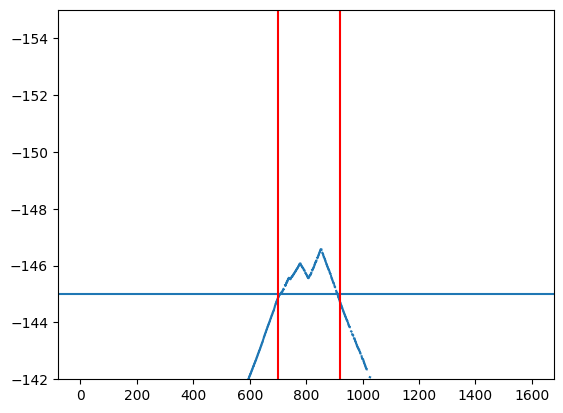

In [24]:
with xr.open_dataset(path+'dfo-walle652-20240907_grid.nc') as walle2024:
    x = np.linspace(0, len(walle2024.time), len(walle2024.time))
    plt.plot(x, walle2024.longitude[0,:])
    plt.axhline(y=-145)
    plt.ylim(-142,-155)
    
    plt.axvline(x=700, c='red')
    plt.axvline(x=920, c='red')

    walle2024['gridded_time']= walle2024.time_1970.astype('timedelta64[s]') + np.datetime64('1970-01-01T00:00:00') 

    
    walle2024_EW = walle2024.isel(time=range(0,700,1))
    
    walle2024_WE = walle2024.isel(time=range(920,len(walle2024.time),1))
    

In [37]:
section = walle2024_EW
    
true_lons = np.empty(len(section.time))
true_lons[:] = np.nan  
####
true_lats = np.empty(len(section.time))
true_lats[:] = np.nan  

####
true_times = np.empty(len(section.time))
true_times[:] = np.nan  

true_times = np.empty(len(section.time))
true_times[:] = np.nan  

for i in range(len(section.time)-1): 
    if section.profile_direction[0,i] == -1: #if ascending 
        distance_difference = np.abs(section.gridded_time[0,i+1] - section.gridded_time[0,i]) 
        time_difference = np.abs(section.gridded_time[0,i] - section.gridded_time[1,i]) 

        if time_difference >=  (np.array(37100000000)).astype('timedelta64[ns]'): #25 seconds  
            true_lats[i] = (section.latitude[0,i].values) #lat coordinate
            true_lons[i]= (section.longitude[0,i].values) #lon coordinate 
            true_times[i] = (section.gridded_time[0,i].values.astype(np.float64)/1e9 )

        elif distance_difference >=  100000000000: #consecutive profiles are 0.02 degrees longtiude apart
            true_lats[i] = (section.latitude[0,i+1].values) #lat coordinate
            true_lons[i] = (section.longitude[0,i+1].values) #lon coordinate 
            true_times[i] = (section.gridded_time[0,i+1].values.astype(np.float64)/1e9 )
        else:
            true_lats[i] = np.nan #lat coordinate
            true_lons[i] = np.nan #lon coordinate 
            true_times[i] = np.nan
    
    elif (np.isnan(section.time_1970[0,i] ) and ~np.isnan(section.time_1970[0,i+1] )):
        true_lats[i] = (section.latitude[0,i+1].values) #lat coordinate
        true_lons[i] = (section.longitude[0,i+1].values) #lon coordinate 
        true_times[i] = (section.gridded_time[0,i+1].values.astype(np.float64)/1e9 )
            
    
    else:
        true_lats[i] = np.nan #lat coordinate
        true_lons[i] = np.nan #lon coordinate 
        true_times[i] = np.nan

true_lats = true_lats[~np.isnan(true_times)]
true_lons = true_lons[~np.isnan(true_times)]
true_times = true_times[~np.isnan(true_times)]     




section['new_lons'] = (('depth','time'), np.where(np.isnan(section.potential_temperature), np.nan, np.nan))
section['new_lats'] = (('depth','time'), np.where(np.isnan(section.potential_temperature), np.nan, np.nan))


##########interpolate surface 

good_indx = ~np.isnan(section.time_1970[0,:])
sfc_time = section.time_1970[0,good_indx] 

#######
sfc_lons = np.interp(sfc_time,true_times, true_lons)
section.new_lons[0,good_indx] = sfc_lons

sfc_lats = np.interp(sfc_time, true_times ,true_lats)
section.new_lats[0,good_indx] = sfc_lats


################ interpolate other depths 
for i in range(1,len(section.depth)):
    good_indx = ~(np.isnan(section.time_1970[i,:])  )
    new_x = section.time_1970[i,good_indx]

    if len(new_x) > 0: 
        section.new_lons[i,good_indx] = np.interp(new_x,true_times, true_lons)
        section.new_lats[i,good_indx] = np.interp(new_x,true_times, true_lats)


Text(0.5, 1.0, 'walle2024_EW')

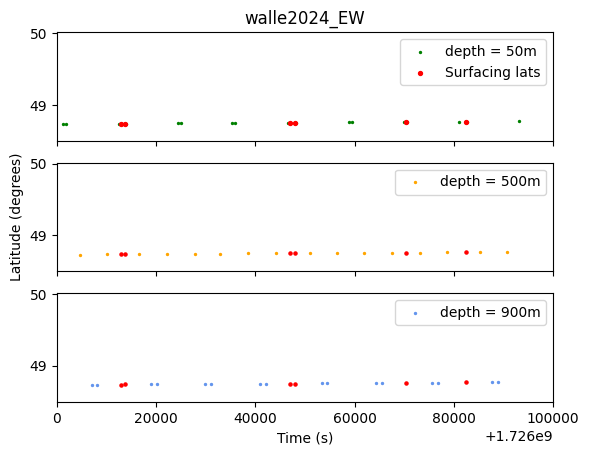

In [38]:
fig, axs = plt.subplots(3,1,sharex=True)

axs[0].scatter(section.time_1970[50,:],section.new_lats[50], c='green',marker='o' , s=2,label='depth = 50m')
axs[0].scatter(true_times,true_lats, marker='o', s=8, label = 'Surfacing lats', c='red')


axs[1].scatter(section.time_1970[500,:],section.new_lats[500], c='orange',marker='o' ,s=2, label='depth = 500m')
axs[1]. scatter(true_times,true_lats, marker='o', s=5,c='red')

axs[2].scatter(section.time_1970[900,:],section.new_lats[900], c='cornflowerblue',marker='o' ,s=2, label='depth = 900m')
axs[2]. scatter(true_times,true_lats, marker='o', s=5,c='red')


axs[0].legend(); axs[1].legend(); axs[2].legend()

axs[2].set_xlabel('Time (s)')
axs[1].set_ylabel ('Latitude (degrees)')
plt.xlim(1.7260e9, 1.7261e9)
axs[0].set_title('walle2024_EW')

Text(0.5, 1.0, 'walle2024_EW')

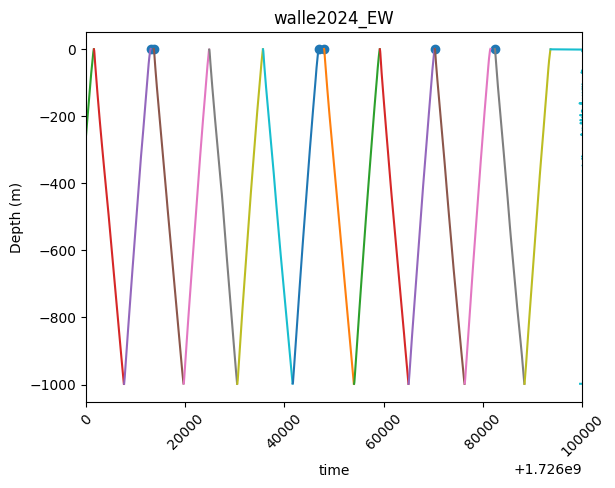

In [39]:
plt.plot(section.time_1970,-section.depth )
plt.scatter((true_times)  , np.linspace(0,0,len(true_times)))
plt.xticks(rotation=45)
plt.ylabel('Depth (m)')
plt.xlabel('time')
plt.xlim(1.7260e9, 1.7261e9)
plt.title('walle2024_EW')


In [40]:
section = v_distance(section)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [53]:
section.to_netcdf(dist_path+'walle2024_EW_corrected_dist.nc')

(0.0, 50.0)

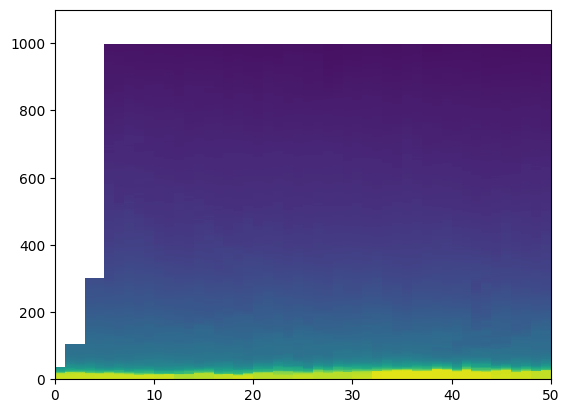

In [62]:
plt.pcolormesh(section.potential_temperature)
plt.xlim(0,50)


In [54]:
##### fine grid
ds = xr.open_dataset(dist_path+'walle2024_EW_corrected_dist.nc')
interpolate_even_dist(ds ,'walle2024_EW.nc', 'EW')

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

Text(0.5, 0.98, 'walle2019_jul_EW')

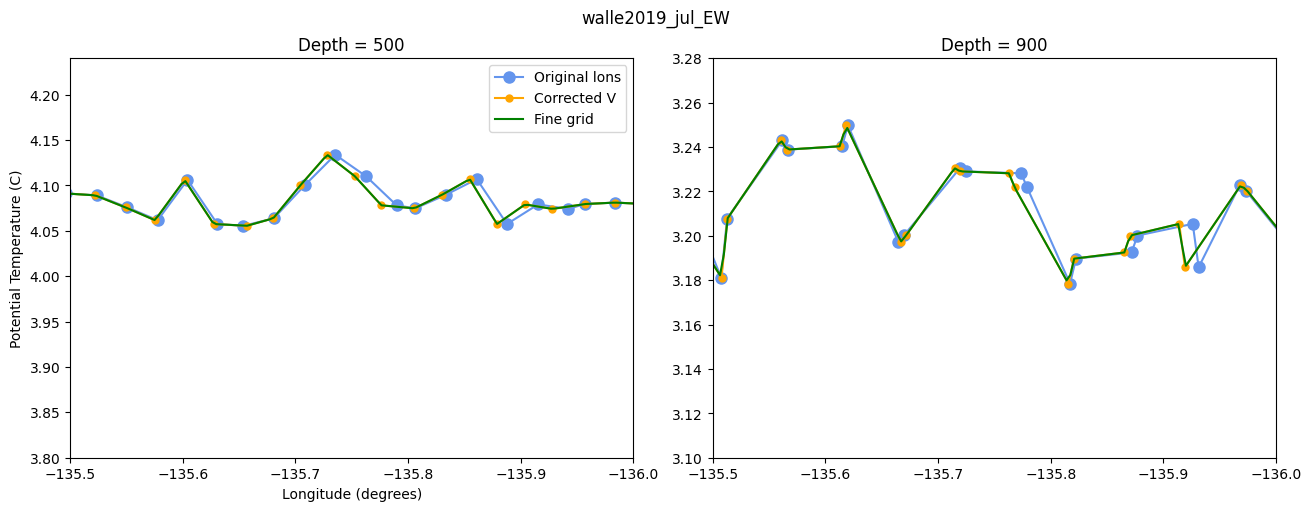

In [56]:
###compare data from original, corrected 'V' and interpolated data 
fig, axs = plt.subplots(1,2, layout='constrained',sharex=True, figsize=(13,5))


axs[0].plot(ds.longitude[500],ds.potential_temperature[500,:], marker='o', markersize=8,label='Original lons', color='cornflowerblue')  #original 
axs[0].plot(ds.new_lons[500],ds.potential_temperature[500,:], marker='o', markersize=5,label='Corrected V ', color='orange')  #original 


walleEW_interp = xr.open_dataset(fine_path + 'walle2024_EW.nc')

axs[0].plot(walleEW_interp.longitude[500,:],walleEW_interp.potential_temperature[500,:], label ='Fine grid', color='green')  #interpolated
axs[0].set_ylim(3.8,4.24)

####

axs[1].plot(ds.longitude[900],ds.potential_temperature[900,:], marker='o', markersize=8,label='Original lons', color='cornflowerblue')  #original 
axs[1].plot(ds.new_lons[900],ds.potential_temperature[900,:], marker='o', markersize=5,label='Corrected V ', color='orange')  #original 
axs[1].plot(walleEW_interp.longitude[900,:],walleEW_interp.potential_temperature[900,:], label ='Fine grid', color='green')  #interpolated
axs[1].set_ylim(3.1,3.28)



axs[0].set_xlim(-135.5,-136)
axs[0].set_title('Depth = 500')
axs[1].set_title('Depth = 900')



axs[0].set_ylabel('Potential Temperature (C)')
axs[0].set_xlabel('Longitude (degrees)')
axs[0].legend()
fig.suptitle('walle2019_jul_EW')

/var/folders/4f/2tlph0394xl3ljq0c7zz4t380000gn/T/ipykernel_27816/2831543894.py:5: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.
  axs[0].pcolor(walle2024_EW.longitude[:,:],-walle2024_EW.depth,walle2024_EW.potential_temperature, cmap=cmap, vmin=vmin, vmax=vmax)
/var/folders/4f/2tlph0394xl3ljq0c7zz4t380000gn/T/ipykernel_27816/2831543894.py:6: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.
  axs[1].pcolor(ds.new_lons[:,:],-ds.depth,ds.potential_temperature,cmap=cmap, vmin=vmin, vmax=vmax)
/var/folders/4f/2tlph0394xl3ljq0c7zz4t380000gn/T/ipykernel_27816/2831543894.py:7: UserWarning: The input coordinates t

Text(0.5, 0.98, 'walle2024_EW')

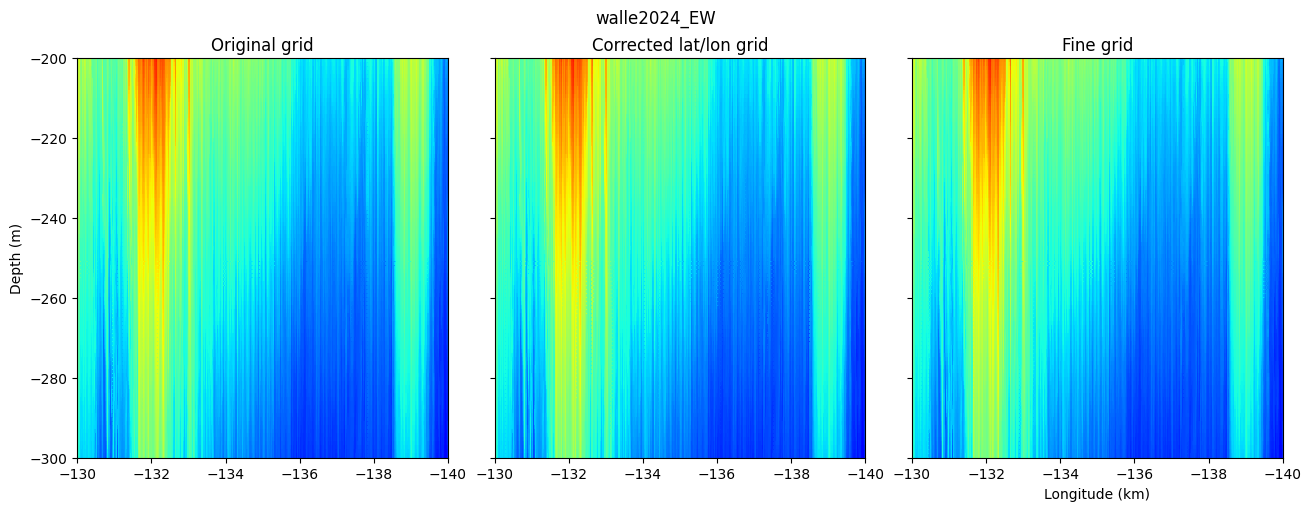

In [58]:
ds2 = xr.open_dataset(fine_path+'walle2024_EW.nc')


fig, axs = plt.subplots(1,3, layout='constrained',sharey=True,sharex=True, figsize=(13,5))

cmap='jet'; vmin=4; vmax=8

axs[0].pcolor(walle2024_EW.longitude[:,:],-walle2024_EW.depth,walle2024_EW.potential_temperature, cmap=cmap, vmin=vmin, vmax=vmax)
axs[1].pcolor(ds.new_lons[:,:],-ds.depth,ds.potential_temperature,cmap=cmap, vmin=vmin, vmax=vmax)
axs[2].pcolor(ds2.longitude,-ds2.depth,ds2.potential_temperature,cmap=cmap, vmin=vmin, vmax=vmax)

axs[0].set_xlim(-130,-140)
axs[0].set_ylim(-300, -200)

axs[2].set_xlabel('Longitude (km)')
axs[0]. set_ylabel('Depth (m)')

axs[0].set_title('Original grid')
axs[1].set_title('Corrected lat/lon grid')
axs[2].set_title('Fine grid')
fig.suptitle('walle2024_EW')

WE

In [63]:
section = walle2024_WE
    
#############try to find where the glider is surfacing from the jumps 
true_lons = np.empty(len(section.time))
true_lons[:] = np.nan  
####
true_lats = np.empty(len(section.time))
true_lats[:] = np.nan  

####
true_times = np.empty(len(section.time))
true_times[:] = np.nan  

true_times = np.empty(len(section.time))
true_times[:] = np.nan  


for i in range(len(section.time)-1): 
    if section.profile_direction[0,i] == -1: #if ascending 
        distance_difference = np.abs(section.gridded_time[0,i+1] - section.gridded_time[0,i]) 
        time_difference = np.abs(section.gridded_time[0,i] - section.gridded_time[1,i]) 

        if time_difference >=  (np.array(37100000000)).astype('timedelta64[ns]'): #25 seconds  
            true_lats[i] = (section.latitude[0,i].values) #lat coordinate
            true_lons[i]= (section.longitude[0,i].values) #lon coordinate 
            true_times[i] = (section.gridded_time[0,i].values.astype(np.float64)/1e9 )

        elif distance_difference >=  100000000000: #consecutive profiles are 0.02 degrees longtiude apart
            true_lats[i] = (section.latitude[0,i+1].values) #lat coordinate
            true_lons[i] = (section.longitude[0,i+1].values) #lon coordinate 
            true_times[i] = (section.gridded_time[0,i+1].values.astype(np.float64)/1e9 )
        else:
            true_lats[i] = np.nan #lat coordinate
            true_lons[i] = np.nan #lon coordinate 
            true_times[i] = np.nan
    
    elif (np.isnan(section.time_1970[0,i] ) and ~np.isnan(section.time_1970[0,i+1] )):
        true_lats[i] = (section.latitude[0,i+1].values) #lat coordinate
        true_lons[i] = (section.longitude[0,i+1].values) #lon coordinate 
        true_times[i] = (section.gridded_time[0,i+1].values.astype(np.float64)/1e9 )
            
    
    else:
        true_lats[i] = np.nan #lat coordinate
        true_lons[i] = np.nan #lon coordinate 
        true_times[i] = np.nan

true_lats = true_lats[~np.isnan(true_times)]
true_lons = true_lons[~np.isnan(true_times)]
true_times = true_times[~np.isnan(true_times)]     




section['new_lons'] = (('depth','time'), np.where(np.isnan(section.potential_temperature), np.nan, np.nan))
section['new_lats'] = (('depth','time'), np.where(np.isnan(section.potential_temperature), np.nan, np.nan))


##########interpolate surface 

good_indx = ~np.isnan(section.time_1970[0,:])
sfc_time = section.time_1970[0,good_indx] 

#######
sfc_lons = np.interp(sfc_time,true_times, true_lons)
section.new_lons[0,good_indx] = sfc_lons

sfc_lats = np.interp(sfc_time, true_times ,true_lats)
section.new_lats[0,good_indx] = sfc_lats


################ interpolate other depths 
for i in range(1,len(section.depth)):
    good_indx = ~(np.isnan(section.time_1970[i,:])  )
    new_x = section.time_1970[i,good_indx]

    if len(new_x) > 0: 
        section.new_lons[i,good_indx] = np.interp(new_x,true_times, true_lons)
        section.new_lats[i,good_indx] = np.interp(new_x,true_times, true_lats)


Text(0.5, 1.0, 'walle2024_WE')

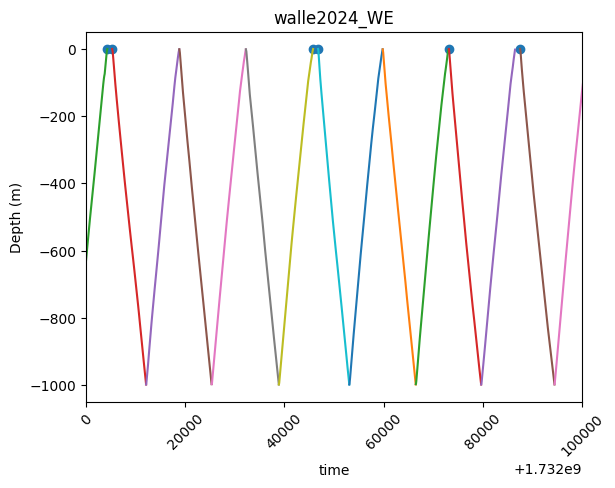

In [71]:
plt.plot(section.time_1970,-section.depth )
plt.scatter((true_times)  , np.linspace(0,0,len(true_times)))
plt.xticks(rotation=45)
plt.ylabel('Depth (m)')
plt.xlabel('time')
plt.xlim(1.7320e9, 1.7321e9)
plt.title('walle2024_WE')


Text(0.5, 1.0, 'walle2024_WE')

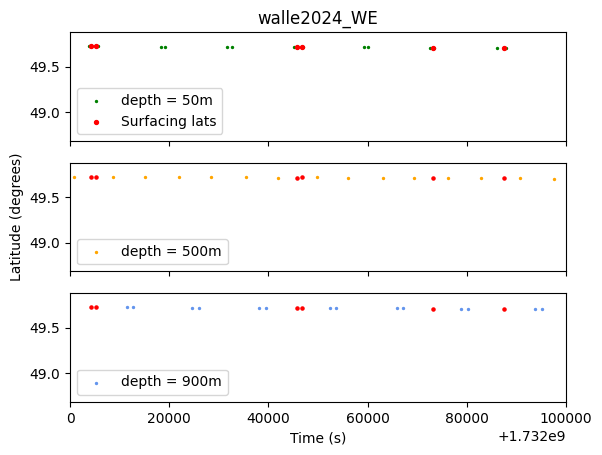

In [73]:
fig, axs = plt.subplots(3,1,sharex=True)

axs[0].scatter(section.time_1970[50,:],section.new_lats[50], c='green',marker='o' , s=2,label='depth = 50m')
axs[0].scatter(true_times,true_lats, marker='o', s=8, label = 'Surfacing lats', c='red')


axs[1].scatter(section.time_1970[500,:],section.new_lats[500], c='orange',marker='o' ,s=2, label='depth = 500m')
axs[1]. scatter(true_times,true_lats, marker='o', s=5,c='red')

axs[2].scatter(section.time_1970[900,:],section.new_lats[900], c='cornflowerblue',marker='o' ,s=2, label='depth = 900m')
axs[2]. scatter(true_times,true_lats, marker='o', s=5,c='red')


axs[0].legend(); axs[1].legend(); axs[2].legend()

axs[2].set_xlabel('Time (s)')
axs[1].set_ylabel ('Latitude (degrees)')
plt.xlim(1.7320e9, 1.7321e9)
axs[0].set_title('walle2024_WE')

In [80]:
section = v_distance(section)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

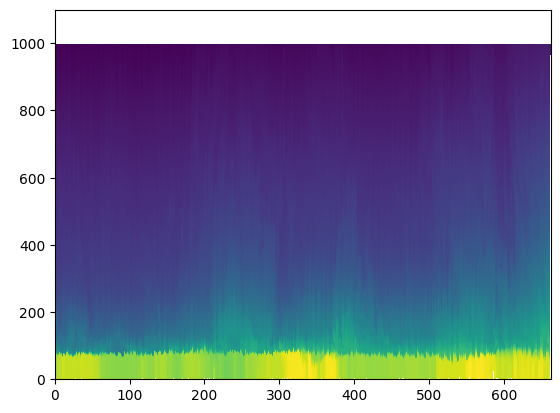

In [128]:
ds2 = section.drop_isel(time=[171,172])
ds3 = ds2.drop_isel(time=[241])
ds4 = ds3.drop_isel(time=[281,286,287])
ds5 = ds4.drop_isel(time=[407,450])
ds6 = ds5.drop_isel(time=[577,592])
ds7 = ds6.drop_isel(time=[621])
ds8 = ds7.drop_isel(time=[100,101])
ds9 = ds8.drop_isel(time=[130,131])


plt.pcolormesh(ds9.temperature)
#plt.xlim(100,150)
#plt.axvline(131)

In [129]:
ds9.to_netcdf(dist_path+'walle2024_WE_corrected_dist.nc')

In [130]:
##### fine grid
ds = xr.open_dataset(dist_path+'walle2024_WE_corrected_dist.nc')
interpolate_even_dist(ds ,'walle2024_WE.nc', 'WE')

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

Text(0.5, 0.98, 'walle2024WE')

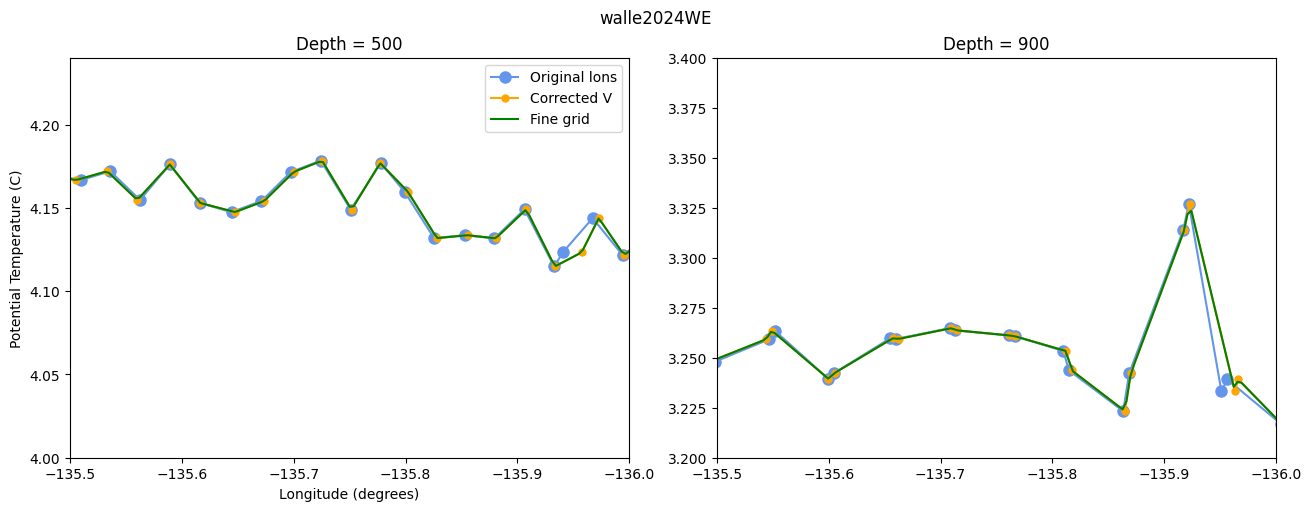

In [133]:
###compare data from original, corrected 'V' and interpolated data 
fig, axs = plt.subplots(1,2, layout='constrained',sharex=True, figsize=(13,5))


axs[0].plot(ds.longitude[500],ds.potential_temperature[500,:], marker='o', markersize=8,label='Original lons', color='cornflowerblue')  #original 
axs[0].plot(ds.new_lons[500],ds.potential_temperature[500,:], marker='o', markersize=5,label='Corrected V ', color='orange')  #original 


walle2024WE_interp = xr.open_dataset(fine_path + 'walle2024_WE.nc')

axs[0].plot(walle2024WE_interp.longitude[500,:],walle2024WE_interp.potential_temperature[500,:], label ='Fine grid', color='green')  #interpolated
axs[0].set_ylim(4,4.24)

####

axs[1].plot(ds.longitude[900],ds.potential_temperature[900,:], marker='o', markersize=8,label='Original lons', color='cornflowerblue')  #original 
axs[1].plot(ds.new_lons[900],ds.potential_temperature[900,:], marker='o', markersize=5,label='Corrected V ', color='orange')  #original 
axs[1].plot(walle2024WE_interp.longitude[900,:],walle2024WE_interp.potential_temperature[900,:], label ='Fine grid', color='green')  #interpolated
axs[1].set_ylim(3.2,3.4)



axs[0].set_xlim(-135.5,-136)
axs[0].set_title('Depth = 500')
axs[1].set_title('Depth = 900')



axs[0].set_ylabel('Potential Temperature (C)')
axs[0].set_xlabel('Longitude (degrees)')
axs[0].legend()
fig.suptitle('walle2024WE')

/var/folders/4f/2tlph0394xl3ljq0c7zz4t380000gn/T/ipykernel_27816/2304910244.py:8: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.
  axs[0].pcolor(walle2024_WE.longitude[:,:],-walle2024_WE.depth,walle2024_WE.potential_temperature, cmap=cmap, vmin=vmin, vmax=vmax)
/var/folders/4f/2tlph0394xl3ljq0c7zz4t380000gn/T/ipykernel_27816/2304910244.py:9: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.
  axs[1].pcolor(ds.new_lons[:,:],-ds.depth,ds.potential_temperature,cmap=cmap, vmin=vmin, vmax=vmax)


Text(0.5, 0.98, 'walle2024_WE')

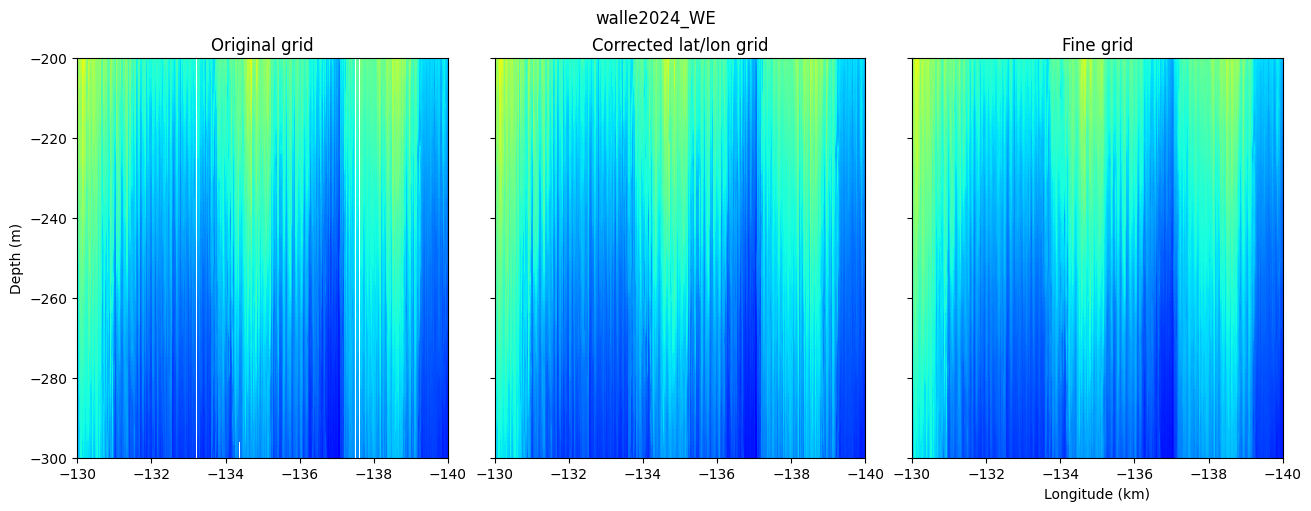

In [134]:
ds2 = xr.open_dataset(fine_path+'walle2024_WE.nc')


fig, axs = plt.subplots(1,3, layout='constrained',sharey=True,sharex=True, figsize=(13,5))

cmap='jet'; vmin=4; vmax=8

axs[0].pcolor(walle2024_WE.longitude[:,:],-walle2024_WE.depth,walle2024_WE.potential_temperature, cmap=cmap, vmin=vmin, vmax=vmax)
axs[1].pcolor(ds.new_lons[:,:],-ds.depth,ds.potential_temperature,cmap=cmap, vmin=vmin, vmax=vmax)
axs[2].pcolor(ds2.longitude,-ds2.depth,ds2.potential_temperature,cmap=cmap, vmin=vmin, vmax=vmax)

axs[0].set_xlim(-130,-140)
axs[0].set_ylim(-300, -200)

axs[2].set_xlabel('Longitude (km)')
axs[0]. set_ylabel('Depth (m)')

axs[0].set_title('Original grid')
axs[1].set_title('Corrected lat/lon grid')
axs[2].set_title('Fine grid')
fig.suptitle('walle2024_WE')

Rosie2024

/var/folders/4f/2tlph0394xl3ljq0c7zz4t380000gn/T/ipykernel_5867/3168776636.py:6: UserWarning: Converting non-nanosecond precision timedelta values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  rosie2024['gridded_time']= rosie2024.time_1970.astype('timedelta64[s]') + np.datetime64('1970-01-01T00:00:00')


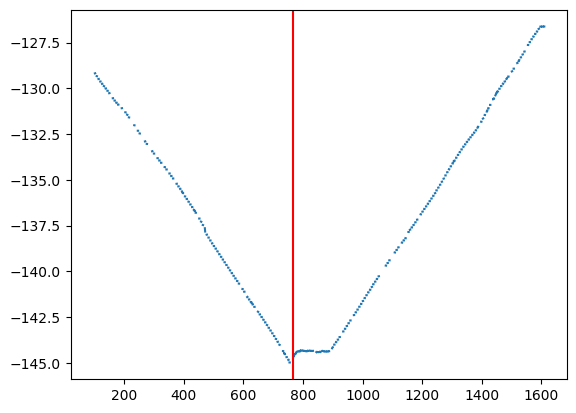

In [4]:
with xr.open_dataset(path+'dfo-rosie713-20240501_grid.nc') as rosie2024:
    x = np.linspace(0, len(rosie2024.time), len(rosie2024.time))
    plt.plot(x, rosie2024.longitude[0,:])
    
    plt.axvline(x=765, c='red')
    rosie2024['gridded_time']= rosie2024.time_1970.astype('timedelta64[s]') + np.datetime64('1970-01-01T00:00:00') 

    
    rosie2024_EW = rosie2024.isel(time=range(0,765,1))
    
    rosie2024_WE = rosie2024.isel(time=range(765,len(rosie2024.time),1))
    

In [7]:
section = rosie2024_EW
    
true_lons = np.empty(len(section.time))
true_lons[:] = np.nan  
####
true_lats = np.empty(len(section.time))
true_lats[:] = np.nan  

####
true_times = np.empty(len(section.time))
true_times[:] = np.nan  

true_times = np.empty(len(section.time))
true_times[:] = np.nan  

for i in range(len(section.time)-1): 
    if section.profile_direction[0,i] == -1: #if ascending 
        distance_difference = np.abs(section.gridded_time[0,i+1] - section.gridded_time[0,i]) 
        time_difference = np.abs(section.gridded_time[0,i] - section.gridded_time[1,i]) 

        if time_difference >=  (np.array(37100000000)).astype('timedelta64[ns]'): #25 seconds  
            true_lats[i] = (section.latitude[0,i].values) #lat coordinate
            true_lons[i]= (section.longitude[0,i].values) #lon coordinate 
            true_times[i] = (section.gridded_time[0,i].values.astype(np.float64)/1e9 )

        elif distance_difference >=  100000000000: #consecutive profiles are 0.02 degrees longtiude apart
            true_lats[i] = (section.latitude[0,i+1].values) #lat coordinate
            true_lons[i] = (section.longitude[0,i+1].values) #lon coordinate 
            true_times[i] = (section.gridded_time[0,i+1].values.astype(np.float64)/1e9 )
        else:
            true_lats[i] = np.nan #lat coordinate
            true_lons[i] = np.nan #lon coordinate 
            true_times[i] = np.nan
    
    elif (np.isnan(section.time_1970[0,i] ) and ~np.isnan(section.time_1970[0,i+1] )):
        true_lats[i] = (section.latitude[0,i+1].values) #lat coordinate
        true_lons[i] = (section.longitude[0,i+1].values) #lon coordinate 
        true_times[i] = (section.gridded_time[0,i+1].values.astype(np.float64)/1e9 )
            
    
    else:
        true_lats[i] = np.nan #lat coordinate
        true_lons[i] = np.nan #lon coordinate 
        true_times[i] = np.nan

true_lats = true_lats[~np.isnan(true_times)]
true_lons = true_lons[~np.isnan(true_times)]
true_times = true_times[~np.isnan(true_times)]     




section['new_lons'] = (('depth','time'), np.where(np.isnan(section.potential_temperature), np.nan, np.nan))
section['new_lats'] = (('depth','time'), np.where(np.isnan(section.potential_temperature), np.nan, np.nan))


##########interpolate surface 

good_indx = ~np.isnan(section.time_1970[0,:])
sfc_time = section.time_1970[0,good_indx] 

#######
sfc_lons = np.interp(sfc_time,true_times, true_lons)
section.new_lons[0,good_indx] = sfc_lons

sfc_lats = np.interp(sfc_time, true_times ,true_lats)
section.new_lats[0,good_indx] = sfc_lats


################ interpolate other depths 
for i in range(1,len(section.depth)):
    good_indx = ~(np.isnan(section.time_1970[i,:])  )
    new_x = section.time_1970[i,good_indx]

    if len(new_x) > 0: 
        section.new_lons[i,good_indx] = np.interp(new_x,true_times, true_lons)
        section.new_lats[i,good_indx] = np.interp(new_x,true_times, true_lats)


In [66]:
        
line_point1 = np.array([climate.longitude[0], climate.latitude[0]])
line_point2 = np.array([climate.longitude[26] , climate.latitude[26]])
distance=np.empty((len(section.depth),len(section.time)))
P_lon=np.empty(len(section.time))
P_lat=np.empty(len(section.time))


#Loop through all points 
for i in range(1): 
        print(i)
        for j in range(len(section.time)):  #len(section.time)
            target_point = np.array([section.new_lons[i,j], section.new_lats[i,j]])
                
            if (np.isnan(target_point[0]) or np.isnan(target_point[1])):
                    distance[i,j] = np.nan 
                    P_lat[j] =np.nan 
                    P_lon[j] = np.nan 
            else: 
                Pline_vector = line_point2 - line_point1
                
                    # Vector from line_point1 to the target point
                to_target_vector = target_point - line_point1
                
                    # Calculate the projection using dot product
                projection = np.dot(to_target_vector, Pline_vector) / np.dot(Pline_vector, Pline_vector)
                
                    # Find the closest point on the line
                closest_point = line_point1 + projection * Pline_vector
                
                    # Calculate the distance between the closest point and (lon1, lat1)
                distance[i,j] = geopy.distance.geodesic((line_point1[1],line_point1[0]),(closest_point[1],closest_point[0])).km
                P_lat[j] = closest_point[1]
                P_lon[j] = closest_point[0]

            
section['v_distance']=(('depth','time'), distance)
section['P_longitude'] = (('time'), P_lon)
section['P_latitude'] = (('time'), P_lat)

0


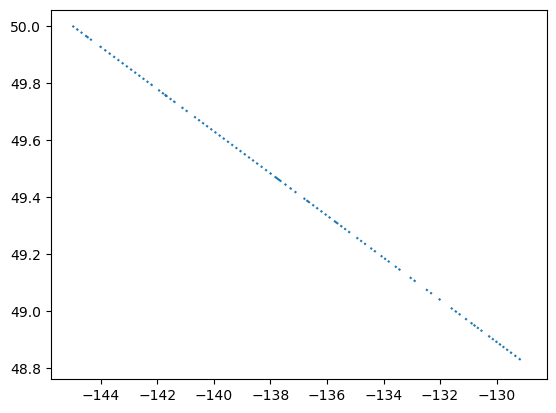

In [67]:
plt.plot(section['P_longitude'],section['P_latitude'])

In [74]:
(interpolated_values)[-100:-1]

array([-144.65146335, -144.65495471, -144.65844607, -144.66193742,
       -144.66542878, -144.66892014, -144.6724115 , -144.67590286,
       -144.67939422, -144.68288558, -144.686377  , -144.68986965,
       -144.6933623 , -144.69685496, -144.70034761, -144.70384026,
       -144.70733291, -144.71082557, -144.71431822, -144.71781087,
       -144.72130352, -144.72479617, -144.72828883, -144.73178148,
       -144.73527413, -144.73876678, -144.74225943, -144.74575209,
       -144.74924474, -144.75273739, -144.75623004, -144.7597227 ,
       -144.76321535, -144.766708  , -144.77020065, -144.7736933 ,
       -144.77718596, -144.78067861, -144.78417126, -144.78766391,
       -144.79115657, -144.79464922, -144.79814187, -144.80163452,
       -144.80512717, -144.80861983, -144.81211248, -144.81560513,
       -144.81909778, -144.82259044, -144.82608309, -144.82957574,
       -144.83306896, -144.83656225, -144.84005567, -144.84354925,
       -144.84704283, -144.85053642, -144.85403   , -144.85752

In [75]:
from scipy.interpolate import interp1d


evenly_spaced_grid = np.arange(0,climate.distance[-1],0.25) ##spaced 0.25 km apart

interp_function = interp1d(
    section.v_distance[0], section.P_longitude, kind='linear', fill_value='extrapolate'
)

# Evaluate the function on the evenly spaced grid
interpolated_lon = interp_function(evenly_spaced_grid)


interp_function = interp1d(
    section.v_distance[0], section.P_latitude, kind='linear', fill_value='extrapolate'
)

# Evaluate the function on the evenly spaced grid
    interpolated_lat = interp_function(evenly_spaced_grid)

In [82]:
ds=xr.DataArray(interpolated_lat,coords={'distance': evenly_spaced_grid})
ds2=ds.rename('P_lat')

In [84]:
ds2.to_netcdf(path+'P_lat.nc')

In [85]:
ds=xr.DataArray(interpolated_lon,coords={'distance': evenly_spaced_grid})
ds2=ds.rename('P_lon')
ds2.to_netcdf(path+'P_lon.nc')

In [91]:
lat=xr.open_dataset(path+'P_lat.nc')
lon=xr.open_dataset(path+'P_lon.nc')


Text(0.5, 1.0, 'rosie2024_EW')

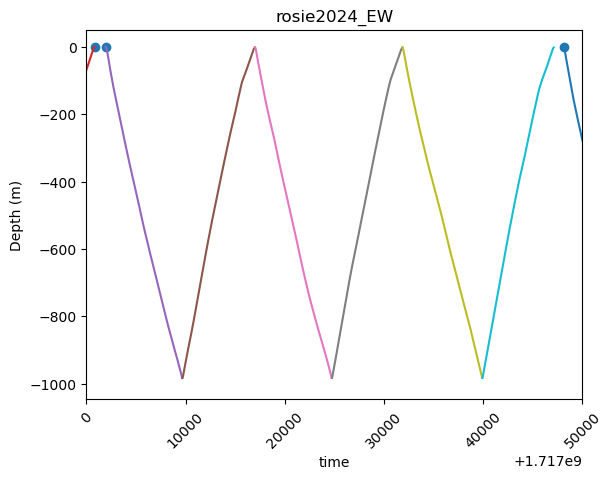

In [114]:
plt.plot(section.time_1970,-section.depth )
plt.scatter((true_times)  , np.linspace(0,0,len(true_times)))
plt.xticks(rotation=45)
plt.ylabel('Depth (m)')
plt.xlabel('time')
plt.xlim(1.717e9, 1.71705e9)
plt.title('rosie2024_EW')



Text(0.5, 1.0, 'Rosie2024_EW')

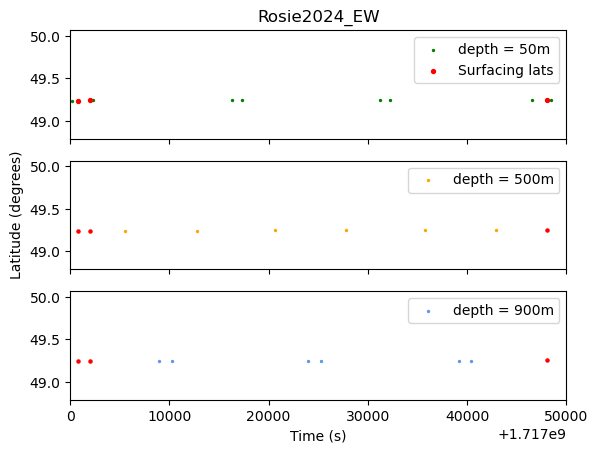

In [9]:
fig, axs = plt.subplots(3,1,sharex=True)

axs[0].scatter(section.time_1970[50,:],section.new_lats[50], c='green',marker='o' , s=2,label='depth = 50m')
axs[0].scatter(true_times,true_lats, marker='o', s=8, label = 'Surfacing lats', c='red')


axs[1].scatter(section.time_1970[500,:],section.new_lats[500], c='orange',marker='o' ,s=2, label='depth = 500m')
axs[1]. scatter(true_times,true_lats, marker='o', s=5,c='red')

axs[2].scatter(section.time_1970[900,:],section.new_lats[900], c='cornflowerblue',marker='o' ,s=2, label='depth = 900m')
axs[2]. scatter(true_times,true_lats, marker='o', s=5,c='red')


axs[0].legend(); axs[1].legend(); axs[2].legend()

axs[2].set_xlabel('Time (s)')
axs[1].set_ylabel ('Latitude (degrees)')
plt.xlim(1.717e9, 1.71705e9)
axs[0].set_title('Rosie2024_EW')

In [115]:
section = v_distance(section)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

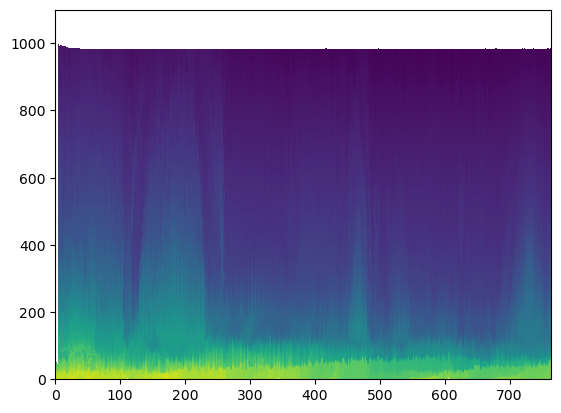

In [116]:
ds2 = section.drop_isel(time=[470])

plt.pcolormesh(ds2.potential_temperature)
#plt.axvline(x=470)

#plt.xlim(700,800)

In [117]:
ds2.to_netcdf(dist_path+'rosie2024_EW_corrected_dist.nc')


In [137]:
##### fine grid
ds = xr.open_dataset(dist_path+'rosie2024_EW_corrected_dist.nc')
interpolate_even_dist(ds ,'rosie2024_EW.nc', 'EW')

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [138]:
ds = xr.open_dataset(fine_path+'rosie2024_EW.nc')


WE

In [57]:
section = rosie2024_WE
    
true_lons = np.empty(len(section.time))
true_lons[:] = np.nan  
####
true_lats = np.empty(len(section.time))
true_lats[:] = np.nan  

####
true_times = np.empty(len(section.time))
true_times[:] = np.nan  

true_times = np.empty(len(section.time))
true_times[:] = np.nan  

for i in range(len(section.time)-1): 
    if section.profile_direction[0,i] == -1: #if ascending 
        distance_difference = np.abs(section.gridded_time[0,i+1] - section.gridded_time[0,i]) 
        time_difference = np.abs(section.gridded_time[0,i] - section.gridded_time[1,i]) 

        if time_difference >=  (np.array(37100000000)).astype('timedelta64[ns]'): #25 seconds  
            true_lats[i] = (section.latitude[0,i].values) #lat coordinate
            true_lons[i]= (section.longitude[0,i].values) #lon coordinate 
            true_times[i] = (section.gridded_time[0,i].values.astype(np.float64)/1e9 )

        elif distance_difference >=  100000000000: #consecutive profiles are 0.02 degrees longtiude apart
            true_lats[i] = (section.latitude[0,i+1].values) #lat coordinate
            true_lons[i] = (section.longitude[0,i+1].values) #lon coordinate 
            true_times[i] = (section.gridded_time[0,i+1].values.astype(np.float64)/1e9 )
        else:
            true_lats[i] = np.nan #lat coordinate
            true_lons[i] = np.nan #lon coordinate 
            true_times[i] = np.nan
    
    elif (np.isnan(section.time_1970[0,i] ) and ~np.isnan(section.time_1970[0,i+1] )):
        true_lats[i] = (section.latitude[0,i+1].values) #lat coordinate
        true_lons[i] = (section.longitude[0,i+1].values) #lon coordinate 
        true_times[i] = (section.gridded_time[0,i+1].values.astype(np.float64)/1e9 )
            
    
    else:
        true_lats[i] = np.nan #lat coordinate
        true_lons[i] = np.nan #lon coordinate 
        true_times[i] = np.nan

true_lats = true_lats[~np.isnan(true_times)]
true_lons = true_lons[~np.isnan(true_times)]
true_times = true_times[~np.isnan(true_times)]     




section['new_lons'] = (('depth','time'), np.where(np.isnan(section.potential_temperature), np.nan, np.nan))
section['new_lats'] = (('depth','time'), np.where(np.isnan(section.potential_temperature), np.nan, np.nan))


##########interpolate surface 

good_indx = ~np.isnan(section.time_1970[0,:])
sfc_time = section.time_1970[0,good_indx] 

#######
sfc_lons = np.interp(sfc_time,true_times, true_lons)
section.new_lons[0,good_indx] = sfc_lons

sfc_lats = np.interp(sfc_time, true_times ,true_lats)
section.new_lats[0,good_indx] = sfc_lats


################ interpolate other depths 
for i in range(1,len(section.depth)):
    good_indx = ~(np.isnan(section.time_1970[i,:])  )
    new_x = section.time_1970[i,good_indx]

    if len(new_x) > 0: 
        section.new_lons[i,good_indx] = np.interp(new_x,true_times, true_lons)
        section.new_lats[i,good_indx] = np.interp(new_x,true_times, true_lats)


Text(0.5, 1.0, 'rosie2024_WE')

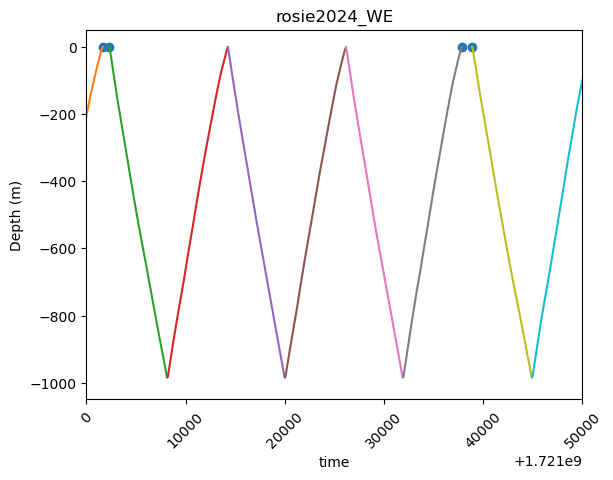

In [58]:
plt.plot(section.time_1970,-section.depth )
plt.scatter((true_times)  , np.linspace(0,0,len(true_times)))
plt.xticks(rotation=45)
plt.ylabel('Depth (m)')
plt.xlabel('time')
plt.xlim(1.721e9, 1.72105e9)
plt.title('rosie2024_WE')


In [59]:
section = v_distance(section)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

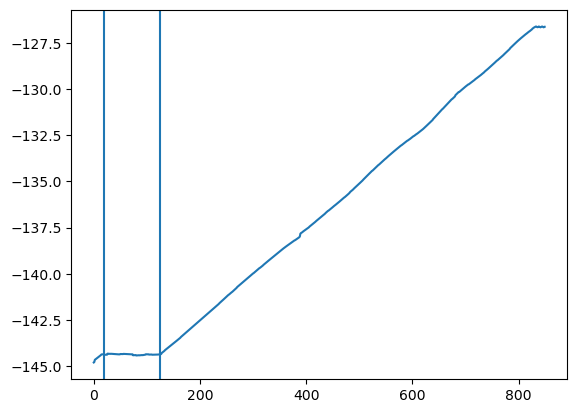

In [78]:
###### cut out when the glider passes over eddy many times (so we don't stack the )


plt.plot(section.longitude[500])
plt.axvline(x=20)
plt.axvline(x=125)

#plt.xlim(100,250)

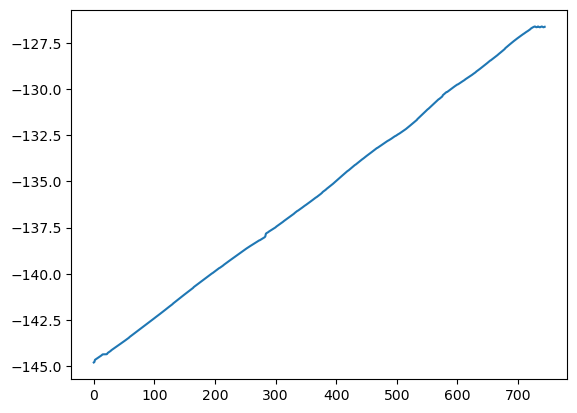

In [80]:
ds2 = section.drop_isel(time=np.arange(20,125,1))
plt.plot(ds2.longitude[500])


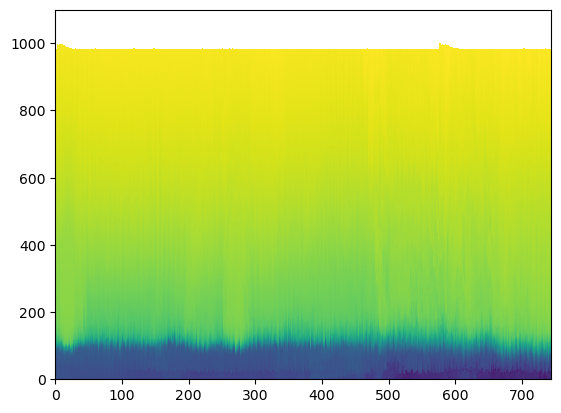

In [94]:
ds3=ds2.drop_isel(time=[283])
plt.pcolormesh(ds3.salinity)
#plt.axvline(x=283)



<xarray.Dataset> Size: 24MB
Dimensions:                (depth: 1100, time: 105)
Coordinates:
  * depth                  (depth) float64 9kB 0.5 1.5 2.5 ... 1.098e+03 1.1e+03
    profile                (time) float64 840B ...
  * time                   (time) datetime64[ns] 840B 2024-07-03T12:55:33 ......
Data variables: (12/28)
    longitude              (depth, time) float64 924kB ...
    latitude               (depth, time) float64 924kB ...
    profile_time_start     (time) datetime64[ns] 840B ...
    profile_time_end       (time) datetime64[ns] 840B ...
    heading                (depth, time) float64 924kB ...
    pitch                  (depth, time) float64 924kB ...
    ...                     ...
    profile_direction      (depth, time) float64 924kB ...
    time_1970              (depth, time) float64 924kB 1.72e+09 1.72e+09 ... nan
    gridded_time           (depth, time) datetime64[ns] 924kB 2024-07-03T12:1...
    new_lons               (depth, time) float64 924kB -144.4 -144.4 ... nan nan
    new_lats               (depth, time) float64 924kB 50.03 50.06 ... nan nan
    v_distance             (depth, time) float64 924kB 1.378e+03 ... nan
Attributes: (12/66)
    Conventions:               CF-1.8
    Metadata_Conventions:      CF-1.8, Unidata Dataset Discovery v1.0
    acknowledgement:           Funding from Fisheries and Oceans Canada, Cana...
    cdm_data_type:             Trajectory
    comment:                   Line P deployment
    contributor_name:          James Pegg, Tetjana Ross, Jody Klymak, Nick Ha...
    ...                        ...
    summary:                   Glider deployed at P4 as part of the C-PROOF g...
    time_coverage_end:         2024-10-07T18:42:58.430847232
    time_coverage_start:       2023-08-03T21:25:22.792816128
    title:                     dfo-rosie713-20230803T2125
    transmission_system:       IRIDIUM
    wmo_id:                    4803919

In [95]:
ds3.to_netcdf(dist_path+'rosie2024_WE_corrected_dist.nc')

In [140]:
##### fine grid
ds = xr.open_dataset(dist_path+'rosie2024_WE_corrected_dist.nc')
interpolate_even_dist(ds ,'rosie2024_WE.nc', 'WE')

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [141]:
ds2 = xr.open_dataset(fine_path+'rosie2024_WE.nc')


NameError: name 'rosie2024_WE' is not defined

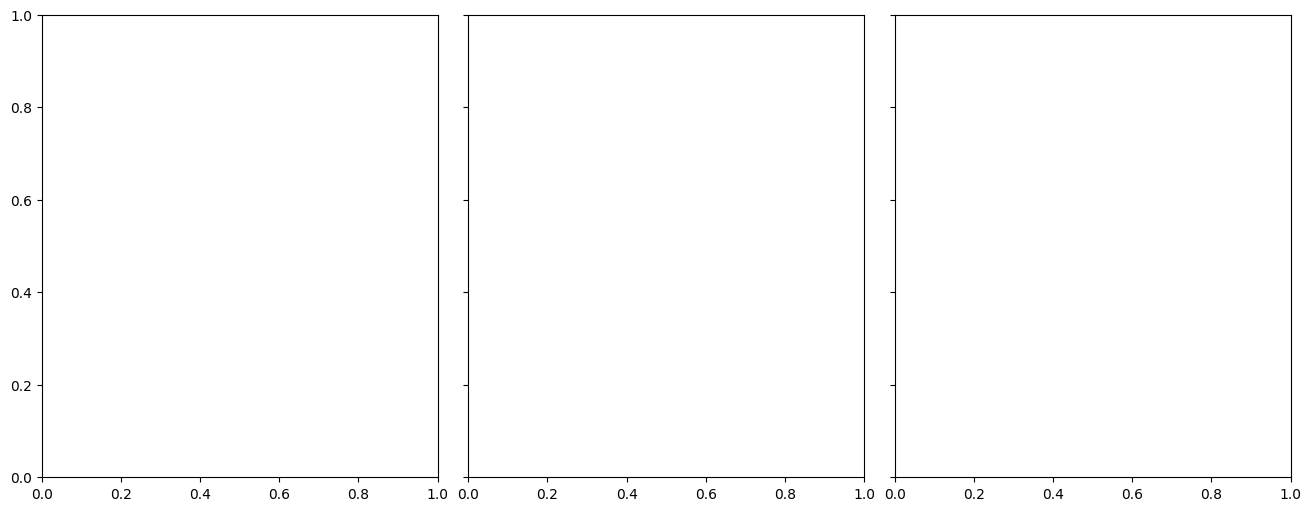

In [142]:
fig, axs = plt.subplots(1,3, layout='constrained',sharey=True,sharex=True, figsize=(13,5))

cmap='jet'; vmin=4; vmax=8

axs[0].pcolor(rosie2024_WE.longitude[:,:],-rosie2024_WE.depth,rosie2024_WE.potential_temperature, cmap=cmap, vmin=vmin, vmax=vmax)
axs[1].pcolor(ds.new_lons[:,:],-ds.depth,ds.potential_temperature,cmap=cmap, vmin=vmin, vmax=vmax)
axs[2].pcolor(ds2.longitude,-ds2.depth,ds2.potential_temperature,cmap=cmap, vmin=vmin, vmax=vmax)

axs[0].set_xlim(-130,-140)
axs[0].set_ylim(-300, -200)

axs[2].set_xlabel('Longitude (km)')
axs[0]. set_ylabel('Depth (m)')

axs[0].set_title('Original grid')
axs[1].set_title('Corrected lat/lon grid')
axs[2].set_title('Fine grid')
fig.suptitle('Rosie2024_WE')

In [106]:
all_sections

<xarray.Dataset> Size: 7GB
Dimensions:                (file: 11, depth: 1100, distance: 5686)
Coordinates:
  * depth                  (depth) float64 9kB 0.5 1.5 2.5 ... 1.098e+03 1.1e+03
  * distance               (distance) float64 45kB -0.0 -0.25 ... -1.421e+03
  * file                   (file) int64 88B 0 1 2 3 4 5 6 7 8 9 10
Data variables: (12/18)
    oxygen                 (file, depth, distance) float64 550MB ...
    potential_temperature  (file, depth, distance) float64 550MB ...
    salinity               (file, depth, distance) float64 550MB ...
    pressure               (file, depth, distance) float64 550MB ...
    longitude              (file, depth, distance) float64 550MB ...
    latitude               (file, depth, distance) float64 550MB ...
    ...                     ...
    iso_density            (file, depth, distance) float64 550MB ...
    iso_sals               (file, distance, depth) float64 550MB ...
    iso_temps              (file, depth, distance) float64 550MB ...
    pot_temp_mean          (depth) float64 9kB ...
    pot_temp_std           (depth) float64 9kB ...
    in_situ_temp           (file, depth, distance) float64 550MB ...

In [4]:
######concat to all_files.nc
rosie2024_EW = xr.open_dataset(fine_path+'rosie2024_EW.nc')
rosie2024_WE = xr.open_dataset(fine_path+'rosie2024_WE.nc')
walle2019_jul_WE = xr.open_dataset(fine_path+'walle2019_jul_WE.nc')
walle2019_dec_EW = xr.open_dataset(fine_path+'walle2019_dec_EW.nc')
walle2019_dec_WE = xr.open_dataset(fine_path+'walle2019_dec_WE.nc')
walle2021_EW = xr.open_dataset(fine_path+'walle2021_EW.nc')
walle2021_WE = xr.open_dataset(fine_path+'walle2021_WE.nc')
rosie2022_EW = xr.open_dataset(fine_path+'rosie2022_EW.nc')
rosie2022_WE = xr.open_dataset(fine_path+'rosie2022_WE.nc')
rosie2023_EW = xr.open_dataset(fine_path+'rosie2023_EW.nc')
rosie2023_WE = xr.open_dataset(fine_path+'rosie2023_WE.nc')
walle2023_EW = xr.open_dataset(fine_path+'walle2023_EW.nc')
walle2023_WE = xr.open_dataset(fine_path+'walle2023_WE.nc')

files = [walle2019_jul_WE,walle2019_dec_EW,walle2019_dec_WE,walle2021_EW,walle2021_WE,rosie2022_EW,
        rosie2022_WE,rosie2023_EW,rosie2023_WE,walle2023_EW,walle2023_WE,rosie2024_EW,rosie2024_WE]

# Concatenate along the new dimension 'file'
all_files = xr.concat(files, dim='file')

# Set coordinates for 'file' dimension if needed
all_files['file'] = np.arange(13)
all_files['pot_temp_mean'] = all_files.iso_temps.mean(dim=('distance', 'file'))    
all_files['pot_temp_std'] = all_files.iso_temps.std(dim=('distance','file')) 


In [5]:
files = [walle2019_jul_WE,walle2019_dec_EW,walle2019_dec_WE,walle2021_EW,walle2021_WE,rosie2022_EW,
        rosie2022_WE,rosie2023_EW,rosie2023_WE,walle2023_EW,walle2023_WE,rosie2024_EW,rosie2024_WE]

In [6]:
# Concatenate along the new dimension 'file'
all_files = xr.concat(files, dim='file')

# Set coordinates for 'file' dimension if needed
all_files['file'] = np.arange(13)
all_files['pot_temp_mean'] = all_files.iso_temps.mean(dim=('distance', 'file'))    
all_files['pot_temp_std'] = all_files.iso_temps.std(dim=('distance','file')) 



/opt/anaconda3/envs/eos431/lib/python3.12/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


In [7]:
all_files.to_netcdf(fine_path+ 'all_files2024.nc')


In [133]:
all_files

<xarray.Dataset> Size: 8GB
Dimensions:                (file: 13, depth: 1100, distance: 5686)
Coordinates:
  * depth                  (depth) float64 9kB 0.5 1.5 2.5 ... 1.098e+03 1.1e+03
  * distance               (distance) float64 45kB 0.0 0.25 ... 1.421e+03
  * file                   (file) int64 104B 0 1 2 3 4 5 6 7 8 9 10 11 12
Data variables: (12/17)
    oxygen                 (file, depth, distance) float64 650MB nan nan ... nan
    potential_temperature  (file, depth, distance) float64 650MB nan nan ... nan
    salinity               (file, depth, distance) float64 650MB nan nan ... nan
    pressure               (file, depth, distance) float64 650MB nan nan ... nan
    longitude              (file, depth, distance) float64 650MB nan nan ... nan
    latitude               (file, depth, distance) float64 650MB nan nan ... nan
    ...                     ...
    pot_density            (file, depth, distance) float64 650MB nan nan ... nan
    iso_density            (file, depth, distance) float64 650MB 1.024e+03 .....
    iso_temps              (file, distance, depth) float64 650MB nan nan ... nan
    iso_sals               (file, distance, depth) float64 650MB nan nan ... nan
    pot_temp_mean          (depth) float64 9kB 10.87 10.87 10.86 ... nan nan nan
    pot_temp_std           (depth) float64 9kB 3.078 3.073 3.069 ... nan nan nan

# walle2019_jul

/var/folders/4f/2tlph0394xl3ljq0c7zz4t380000gn/T/ipykernel_5867/3528281637.py:8: UserWarning: Converting non-nanosecond precision timedelta values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  walle2019_jul['gridded_time']= walle2019_jul.time_1970.astype('timedelta64[s]') + np.datetime64('1970-01-01T00:00:00')


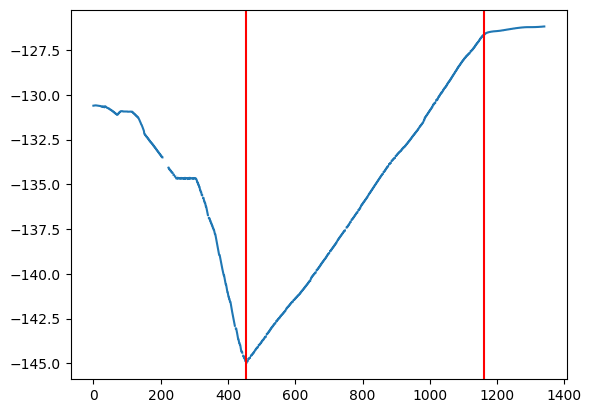

In [5]:
with xr.open_dataset(path+files[0]) as walle2019_jul:
        
    x = np.linspace(0, len(walle2019_jul.time), len(walle2019_jul.time))
    plt.plot(x, walle2019_jul.longitude[0,:])
    
    plt.axvline(x=455, c='red')
    plt.axvline(x=1160, c='red')
    walle2019_jul['gridded_time']= walle2019_jul.time_1970.astype('timedelta64[s]') + np.datetime64('1970-01-01T00:00:00') 

    
    walle2019_jul_EW = walle2019_jul.isel(time=range(0,455,1))
    walle2019_jul_EW = walle2019_jul_EW.drop_isel(time=[0,1,2])
    
    walle2019_jul_WE = walle2019_jul.isel(time=range(455,1160,1))
    
     

In [22]:
# Find mean density at each depth 
walle2019_jul_WE['pot_density'] = gsw.pot_rho_t_exact(walle2019_jul_WE.salinity, walle2019_jul_WE.potential_temperature, walle2019_jul_WE.pressure,0)

rho_avg = (walle2019_jul_WE['pot_density'].mean(dim='time'))
walle2019_jul_WE['iso_density'] = xr.DataArray(rho_avg.values, dims=['depth']).expand_dims(dim={"time": len(walle2019_jul_WE.time)}, axis=1) 


##################Interpolate 
interpolated_temps=[]; interpolated_sals=[];interpolated_dpth=[]

for i in range(len(walle2019_jul_WE.time)): 
    x= np.array(rho_avg)
    xp = np.array(walle2019_jul_WE.pot_density.isel(time=i))
    yp = np.array(walle2019_jul_WE.potential_temperature.isel(time=i))
    ypp = np.array(walle2019_jul_WE.salinity.isel(time=i))


    #interpolate 
    interpolated_temps.append(np.interp(x,xp,yp, right=np.nan, left=np.nan))
    interpolated_sals.append(np.interp(x,xp,ypp))


walle2019_jul_WE['iso_temps']= ((('time','depth')),interpolated_temps)
walle2019_jul_WE['iso_sals']= ((('time','depth')),interpolated_sals)
walle2019_jul_WE['iso_dpth']= ((('time','depth')),interpolated_dpth)


ValueError: object of too small depth for desired array

EW section

In [7]:
# find the time of surfacing
section = walle2019_jul_EW

true_lons = section.longitude[0]
 ####
true_lats = section.latitude[0]
      
####
true_times = section.time_1970[0]
 

true_lats = true_lats[~np.isnan(true_times)]
true_lons = true_lons[~np.isnan(true_times)]
true_times = true_times[~np.isnan(true_times)]

section['new_lons'] = (('depth','time'), np.where(np.isnan(section.potential_temperature), np.nan, np.nan))
section['new_lats'] = (('depth','time'), np.where(np.isnan(section.potential_temperature), np.nan, np.nan))


##########interpolate surface 

good_indx = ~np.isnan(section.time_1970[0,:])
sfc_time = section.time_1970[0,good_indx] 

#######
sfc_lons = np.interp(sfc_time,true_times, true_lons)
section.new_lons[0,good_indx] = sfc_lons

sfc_lats = np.interp(sfc_time, true_times ,true_lats)
section.new_lats[0,good_indx] = sfc_lats


################ interpolate other depths 
for i in range(1,len(section.depth)):
    good_indx = ~np.isnan(section.time_1970[i,:])
    new_x = section.time_1970[i,good_indx]
    
    if len(new_x) > 0: 
        section.new_lons[i,good_indx] = np.interp(new_x,true_times, true_lons)
        section.new_lats[i,good_indx] = np.interp(new_x,true_times, true_lats)


Text(0.5, 1.0, 'walle2019_jul_EW')

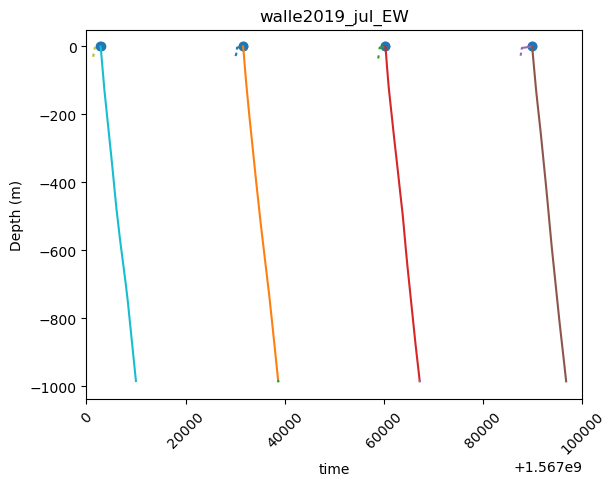

In [9]:
plt.plot(section.time_1970,-section.depth )
plt.scatter((true_times)  , np.linspace(0,0,len(true_times)))
plt.xticks(rotation=45)
plt.ylabel('Depth (m)')
plt.xlabel('time')
plt.xlim(1.567e9, 1.5671e9)
plt.title('walle2019_jul_EW')





Text(0.5, 1.0, 'Walle2019_jul_EW')

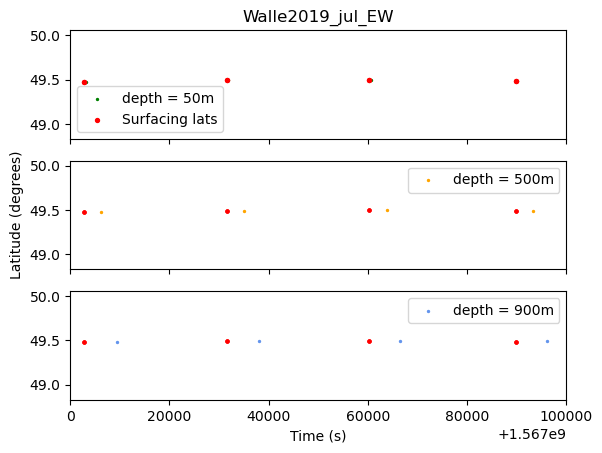

In [478]:
fig, axs = plt.subplots(3,1,sharex=True)

axs[0].scatter(section.time_1970[50,:],section.new_lats[50], c='green',marker='o' , s=2,label='depth = 50m')
axs[0].scatter(true_times,true_lats, marker='o', s=8, label = 'Surfacing lats', c='red')


axs[1].scatter(section.time_1970[500,:],section.new_lats[500], c='orange',marker='o' ,s=2, label='depth = 500m')
axs[1]. scatter(true_times,true_lats, marker='o', s=5,c='red')

axs[2].scatter(section.time_1970[900,:],section.new_lats[900], c='cornflowerblue',marker='o' ,s=2, label='depth = 900m')
axs[2]. scatter(true_times,true_lats, marker='o', s=5,c='red')


axs[0].legend(); axs[1].legend(); axs[2].legend()

axs[2].set_xlabel('Time (s)')
axs[1].set_ylabel ('Latitude (degrees)')
plt.xlim(1.567e9, 1.5671e9)
axs[0].set_title('Walle2019_jul_EW')

In [10]:
dist_noise(section)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [11]:
ds2 = section.drop_isel(time=[73,369,384])


In [13]:
ds2.to_netcdf(dist_path+'walle2019_jul_EW_corrected_dist.nc')

In [4]:
##### fine grid
ds = xr.open_dataset(dist_path+'walle2019_jul_EW_corrected_dist.nc')
#interpolate_even_dist(ds ,'walle2019_jul_EW.nc', 'EW')

In [16]:
ds = xr.open_dataset(fine_path+'walle2019_jul_EW.nc')
ds

<xarray.Dataset> Size: 601MB
Dimensions:                (depth: 1100, distance: 5686)
Coordinates:
  * depth                  (depth) float64 9kB 0.5 1.5 2.5 ... 1.098e+03 1.1e+03
  * distance               (distance) float64 45kB 0.0 0.25 ... 1.421e+03
Data variables: (12/15)
    oxygen                 (depth, distance) float64 50MB ...
    potential_temperature  (depth, distance) float64 50MB ...
    salinity               (depth, distance) float64 50MB ...
    pressure               (depth, distance) float64 50MB ...
    longitude              (depth, distance) float64 50MB ...
    latitude               (depth, distance) float64 50MB ...
    ...                     ...
    var_temp               (depth) float64 9kB ...
    std_temp               (depth) float64 9kB ...
    pot_density            (depth, distance) float64 50MB ...
    iso_density            (depth, distance) float64 50MB ...
    iso_temps              (distance, depth) float64 50MB ...
    iso_sals               (distance, depth) float64 50MB ...

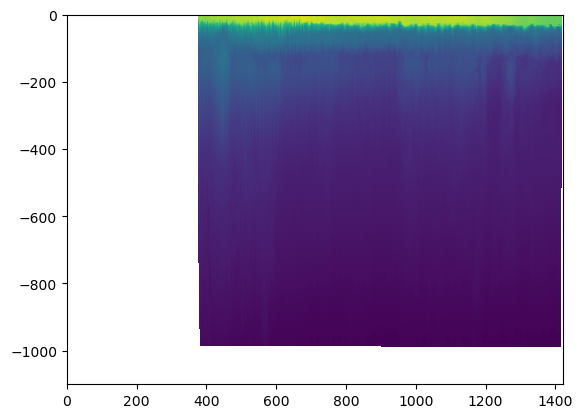

In [22]:
plt.pcolormesh(ds.distance,-ds.depth,ds.potential_temperature)

Text(0.5, 0.98, 'walle2019_jul_EW')

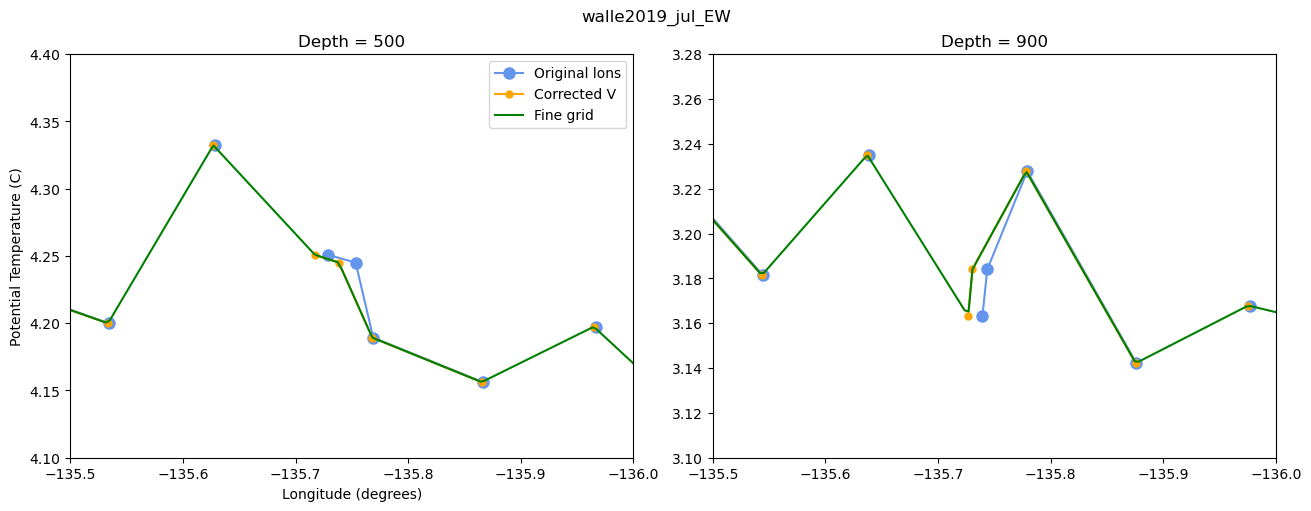

In [15]:
###compare data from original, corrected 'V' and interpolated data 
fig, axs = plt.subplots(1,2, layout='constrained',sharex=True, figsize=(13,5))


axs[0].plot(ds.longitude[500],ds.potential_temperature[500,:], marker='o', markersize=8,label='Original lons', color='cornflowerblue')  #original 
axs[0].plot(ds.new_lons[500],ds.potential_temperature[500,:], marker='o', markersize=5,label='Corrected V ', color='orange')  #original 


walle2019_jul_EW_interp = xr.open_dataset(fine_path + 'walle2019_jul_EW.nc')

axs[0].plot(walle2019_jul_EW_interp.longitude[500,:],walle2019_jul_EW_interp.potential_temperature[500,:], label ='Fine grid', color='green')  #interpolated
axs[0].set_ylim(4.1,4.4)

####

axs[1].plot(ds.longitude[900],ds.potential_temperature[900,:], marker='o', markersize=8,label='Original lons', color='cornflowerblue')  #original 
axs[1].plot(ds.new_lons[900],ds.potential_temperature[900,:], marker='o', markersize=5,label='Corrected V ', color='orange')  #original 
axs[1].plot(walle2019_jul_EW_interp.longitude[900,:],walle2019_jul_EW_interp.potential_temperature[900,:], label ='Fine grid', color='green')  #interpolated
axs[1].set_ylim(3.1,3.28)



axs[0].set_xlim(-135.5,-136)
axs[0].set_title('Depth = 500')
axs[1].set_title('Depth = 900')



axs[0].set_ylabel('Potential Temperature (C)')
axs[0].set_xlabel('Longitude (degrees)')
axs[0].legend()
fig.suptitle('walle2019_jul_EW')

/var/folders/4f/2tlph0394xl3ljq0c7zz4t380000gn/T/ipykernel_26171/1066726429.py:5: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.
  axs[0].pcolor(ds.longitude[:,:],-ds.depth,ds.potential_temperature, cmap=cmap, vmin=vmin, vmax=vmax)
/var/folders/4f/2tlph0394xl3ljq0c7zz4t380000gn/T/ipykernel_26171/1066726429.py:6: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.
  axs[1].pcolor(ds.new_lons[:,:],-ds.depth,ds.potential_temperature,cmap=cmap, vmin=vmin, vmax=vmax)
/var/folders/4f/2tlph0394xl3ljq0c7zz4t380000gn/T/ipykernel_26171/1066726429.py:7: UserWarning: The input coordinates to pcolor are interpreted as ce

Text(0.5, 0.98, 'Walle2019_jul_EW')

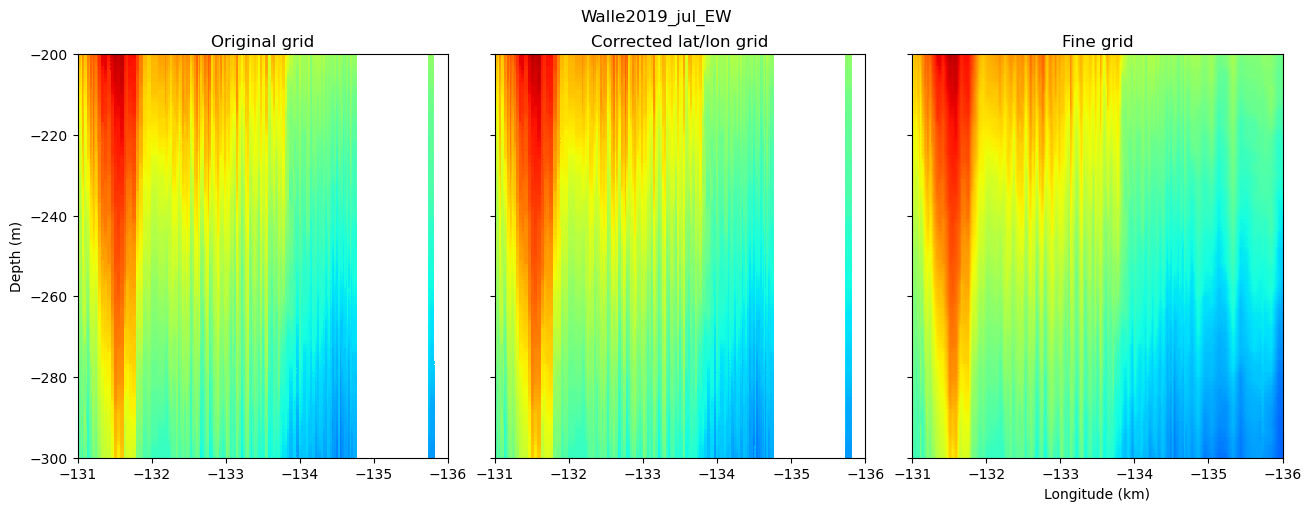

In [505]:
fig, axs = plt.subplots(1,3, layout='constrained',sharey=True,sharex=True, figsize=(13,5))

cmap='jet'; vmin=4; vmax=8

axs[0].pcolor(ds.longitude[:,:],-ds.depth,ds.potential_temperature, cmap=cmap, vmin=vmin, vmax=vmax)
axs[1].pcolor(ds.new_lons[:,:],-ds.depth,ds.potential_temperature,cmap=cmap, vmin=vmin, vmax=vmax)
axs[2].pcolor(walle2019_jul_EW_interp.longitude,-walle2019_jul_EW_interp.depth,walle2019_jul_EW_interp.potential_temperature,cmap=cmap, vmin=vmin, vmax=vmax)

axs[0].set_xlim(-131,-136)
axs[0].set_ylim(-300, -200)

axs[2].set_xlabel('Longitude (km)')
axs[0]. set_ylabel('Depth (m)')

axs[0].set_title('Original grid')
axs[1].set_title('Corrected lat/lon grid')
axs[2].set_title('Fine grid')
fig.suptitle('Walle2019_jul_EW')

WE

In [16]:
# find the time of surfacing
section = walle2019_jul_WE


true_lons = section.longitude[0]
 ####
true_lats = section.latitude[0]
      
####
true_times = section.time_1970[0]
 

true_lats = true_lats[~np.isnan(true_times)]
true_lons = true_lons[~np.isnan(true_times)]
true_times = true_times[~np.isnan(true_times)]

section['new_lons'] = (('depth','time'), np.where(np.isnan(section.potential_temperature), np.nan, np.nan))
section['new_lats'] = (('depth','time'), np.where(np.isnan(section.potential_temperature), np.nan, np.nan))


##########interpolate surface 

good_indx = ~np.isnan(section.time_1970[0,:])
sfc_time = section.time_1970[0,good_indx] 

#######
sfc_lons = np.interp(sfc_time,true_times, true_lons)
section.new_lons[0,good_indx] = sfc_lons

sfc_lats = np.interp(sfc_time, true_times ,true_lats)
section.new_lats[0,good_indx] = sfc_lats


################ interpolate other depths 
for i in range(1,len(section.depth)):
    good_indx = ~np.isnan(section.time_1970[i,:])
    new_x = section.time_1970[i,good_indx]
    
    if len(new_x) > 0: 
        section.new_lons[i,good_indx] = np.interp(new_x,true_times, true_lons)
        section.new_lats[i,good_indx] = np.interp(new_x,true_times, true_lats)


In [17]:
section.time_1970[0,0]

<xarray.DataArray 'time_1970' ()> Size: 8B
[1 values with dtype=float64]
Coordinates:
    depth    float64 8B 0.5
    profile  float64 8B ...
    time     datetime64[ns] 8B 2019-09-19T14:41:43
Attributes: (12/14)
    source:               sci_water_temp
    long_name:            water temperature
    standard_name:        sea_water_temperature
    units:                Celsius
    instrument:           instrument_ctd
    valid_min:            -5
    ...                   ...
    accuracy:             0.002
    precision:            0.001
    resolution:           0.0002
    comment:               
    platform:             platform
    ancillary_variables:

Text(0.5, 1.0, 'walle2019_jul_WE')

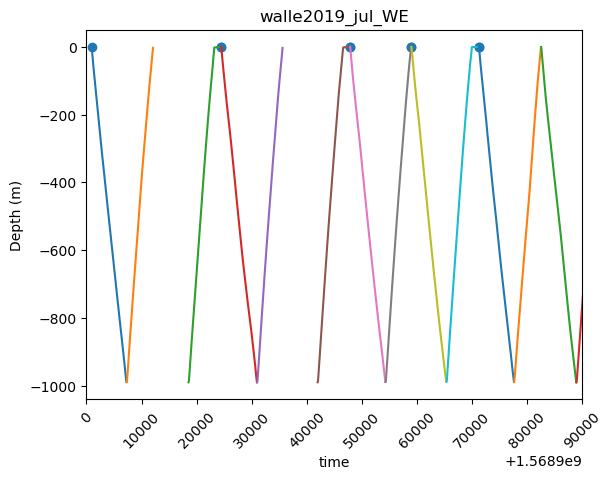

In [18]:
plt.plot(section.time_1970,-section.depth )
plt.scatter((true_times)  , np.linspace(0,0,len(true_times)))
plt.xticks(rotation=45)
plt.ylabel('Depth (m)')
plt.xlabel('time')
plt.xlim(1.5689e9, 1.56899e9)
plt.title('walle2019_jul_WE')



Text(0.5, 1.0, 'Walle2019_jul_WE')

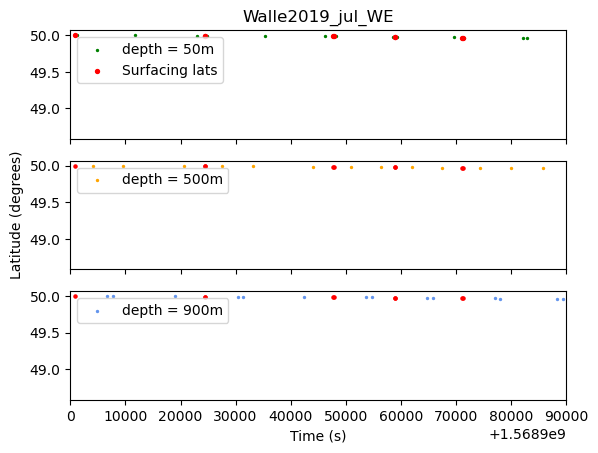

In [547]:
fig, axs = plt.subplots(3,1,sharex=True)

axs[0].scatter(section.time_1970[50,:],section.new_lats[50], c='green',marker='o' , s=2,label='depth = 50m')
axs[0].scatter(true_times,true_lats, marker='o', s=8, label = 'Surfacing lats', c='red')


axs[1].scatter(section.time_1970[500,:],section.new_lats[500], c='orange',marker='o' ,s=2, label='depth = 500m')
axs[1]. scatter(true_times,true_lats, marker='o', s=5,c='red')

axs[2].scatter(section.time_1970[900,:],section.new_lats[900], c='cornflowerblue',marker='o' ,s=2, label='depth = 900m')
axs[2]. scatter(true_times,true_lats, marker='o', s=5,c='red')


axs[0].legend(); axs[1].legend(); axs[2].legend()

axs[2].set_xlabel('Time (s)')
axs[1].set_ylabel ('Latitude (degrees)')
plt.xlim(1.5689e9, 1.56899e9)
axs[0].set_title('Walle2019_jul_WE')

In [19]:
#####drop bad points 

ds2 = section.drop_isel(time=[123,164,165,171,339,431,489])
ds3 = ds2.drop_isel(time=[597])


In [20]:
dist_noise(ds3)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [21]:
ds3.to_netcdf(dist_path+'walle2019_jul_WE_corrected_dist.nc')

In [31]:
ds = xr.open_dataset(dist_path+'walle2019_jul_WE_corrected_dist.nc')
distance_m = ds.v_distance.diff('time') * 1000
time_s = ds.time.diff('time') / np.timedelta64(1, 's')  # gives seconds as float

speed = (distance_m / time_s).mean('time').mean('depth')
speed

<xarray.DataArray ()> Size: 8B
array(-0.33140169)

In [32]:
ds = xr.open_dataset(dist_path+'rosie2022_WE_corrected_dist.nc')
distance_m = ds.v_distance.diff('time') * 1000
time_s = ds.time.diff('time') / np.timedelta64(1, 's')  # gives seconds as float

speed = (distance_m / time_s).mean('time').mean('depth')
speed

<xarray.DataArray ()> Size: 8B
array(-0.32030888)

In [33]:
ds = xr.open_dataset(dist_path+'walle2023_WE_corrected_dist.nc')
distance_m = ds.v_distance.diff('time') * 1000
time_s = ds.time.diff('time') / np.timedelta64(1, 's')  # gives seconds as float

speed = (distance_m / time_s).mean('time').mean('depth')
speed

<xarray.DataArray ()> Size: 8B
array(-0.31117312)

In [22]:
#### fine grid
ds = xr.open_dataset(dist_path+'walle2019_jul_WE_corrected_dist.nc')
interpolate_even_dist(ds ,'walle2019_jul_WE.nc', 'WE')

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

/opt/anaconda3/envs/eos431/lib/python3.12/site-packages/xarray/core/nputils.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)
/opt/anaconda3/envs/eos431/lib/python3.12/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Text(0.5, 0.98, 'walle2019_jul_WE')

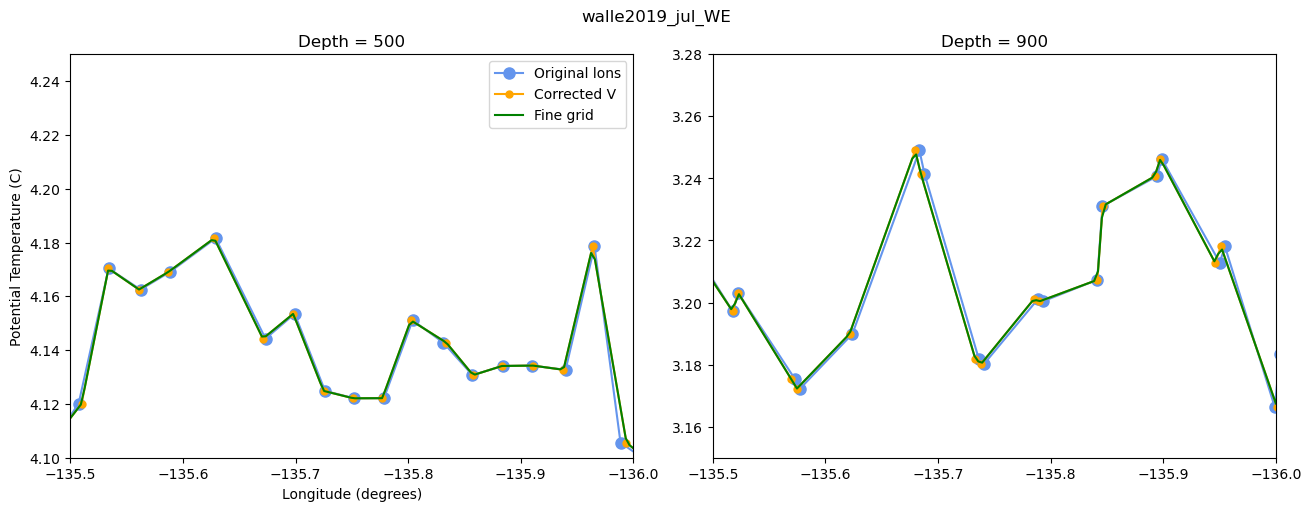

In [23]:
###compare data from original, corrected 'V' and interpolated data 
fig, axs = plt.subplots(1,2, layout='constrained',sharex=True, figsize=(13,5))


axs[0].plot(ds.longitude[500],ds.potential_temperature[500,:], marker='o', markersize=8,label='Original lons', color='cornflowerblue')  #original 
axs[0].plot(ds.new_lons[500],ds.potential_temperature[500,:], marker='o', markersize=5,label='Corrected V ', color='orange')  #original 


walle2019_jul_WE_interp = xr.open_dataset(fine_path + 'walle2019_jul_WE.nc')

axs[0].plot(walle2019_jul_WE_interp.longitude[500,:],walle2019_jul_WE_interp.potential_temperature[500,:], label ='Fine grid', color='green')  #interpolated
axs[0].set_ylim(4.1,4.25)

####

axs[1].plot(ds.longitude[900],ds.potential_temperature[900,:], marker='o', markersize=8,label='Original lons', color='cornflowerblue')  #original 
axs[1].plot(ds.new_lons[900],ds.potential_temperature[900,:], marker='o', markersize=5,label='Corrected V ', color='orange')  #original 
axs[1].plot(walle2019_jul_WE_interp.longitude[900,:],walle2019_jul_WE_interp.potential_temperature[900,:], label ='Fine grid', color='green')  #interpolated
axs[1].set_ylim(3.15,3.28)



axs[0].set_xlim(-135.5,-136)
axs[0].set_title('Depth = 500')
axs[1].set_title('Depth = 900')



axs[0].set_ylabel('Potential Temperature (C)')
axs[0].set_xlabel('Longitude (degrees)')
axs[0].legend()
fig.suptitle('walle2019_jul_WE')

/var/folders/4f/2tlph0394xl3ljq0c7zz4t380000gn/T/ipykernel_26171/94945320.py:5: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.
  axs[0].pcolor(ds.longitude[:,:],-ds.depth,ds.potential_temperature, cmap=cmap, vmin=vmin, vmax=vmax)
/var/folders/4f/2tlph0394xl3ljq0c7zz4t380000gn/T/ipykernel_26171/94945320.py:6: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.
  axs[1].pcolor(ds.new_lons[:,:],-ds.depth,ds.potential_temperature,cmap=cmap, vmin=vmin, vmax=vmax)
/var/folders/4f/2tlph0394xl3ljq0c7zz4t380000gn/T/ipykernel_26171/94945320.py:7: UserWarning: The input coordinates to pcolor are interpreted as cell cen

Text(0.5, 0.98, 'walle2019_jul_WE')

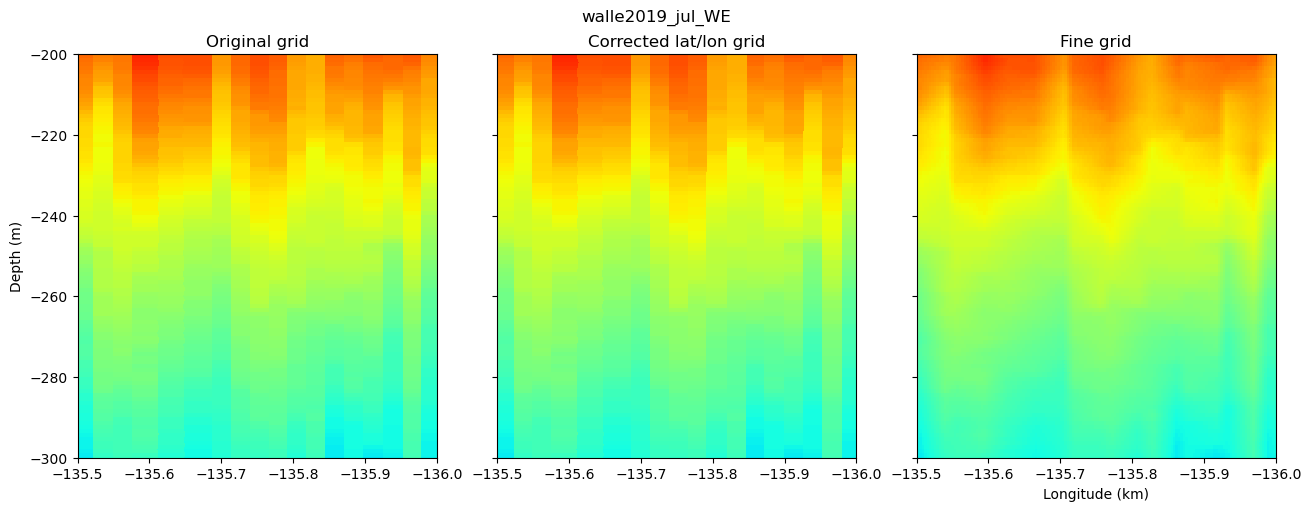

In [581]:
fig, axs = plt.subplots(1,3, layout='constrained',sharey=True,sharex=True, figsize=(13,5))

cmap='jet'; vmin=4; vmax=6.5

axs[0].pcolor(ds.longitude[:,:],-ds.depth,ds.potential_temperature, cmap=cmap, vmin=vmin, vmax=vmax)
axs[1].pcolor(ds.new_lons[:,:],-ds.depth,ds.potential_temperature,cmap=cmap, vmin=vmin, vmax=vmax)
axs[2].pcolor(walle2019_jul_WE_interp.longitude,-walle2019_jul_WE_interp.depth,walle2019_jul_WE_interp.potential_temperature,cmap=cmap, vmin=vmin, vmax=vmax)

axs[0].set_xlim(-135.5,-136)
axs[0].set_ylim(-300, -200)

axs[2].set_xlabel('Longitude (km)')
axs[0]. set_ylabel('Depth (m)')

axs[0].set_title('Original grid')
axs[1].set_title('Corrected lat/lon grid')
axs[2].set_title('Fine grid')
fig.suptitle('walle2019_jul_WE')

# Walle2019_dec

/var/folders/4f/2tlph0394xl3ljq0c7zz4t380000gn/T/ipykernel_50826/204971056.py:3: UserWarning: Converting non-nanosecond precision timedelta values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  walle2019_dec['gridded_time']= walle2019_dec.time_1970.astype('timedelta64[s]') + np.datetime64('1970-01-01T00:00:00')


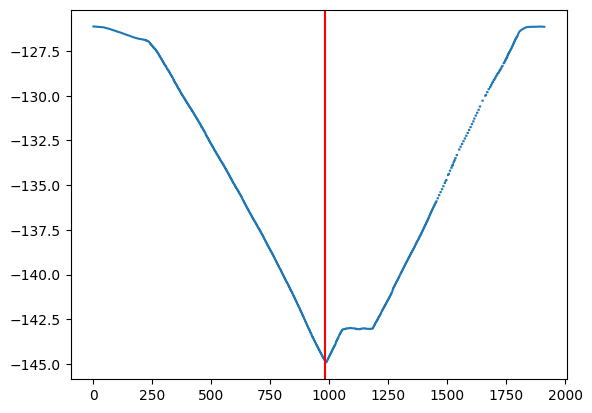

In [5]:
with xr.open_dataset(path+files[1]) as walle2019_dec:
        
    walle2019_dec['gridded_time']= walle2019_dec.time_1970.astype('timedelta64[s]') + np.datetime64('1970-01-01T00:00:00') 

    
    x = np.linspace(0, len(walle2019_dec.time), len(walle2019_dec.time))
    plt.plot(x, walle2019_dec.longitude[0])
    
    plt.axvline(x=980, c='red')
  
    walle2019_dec_EW = walle2019_dec.isel(time=range(0,980,1))
    walle2019_dec_WE = walle2019_dec.isel(time=range(980,len(walle2019_dec.time.values),1))
    

EW

# Find correct lon/lat at every gridcell 

Text(0.5, 0, 'time')

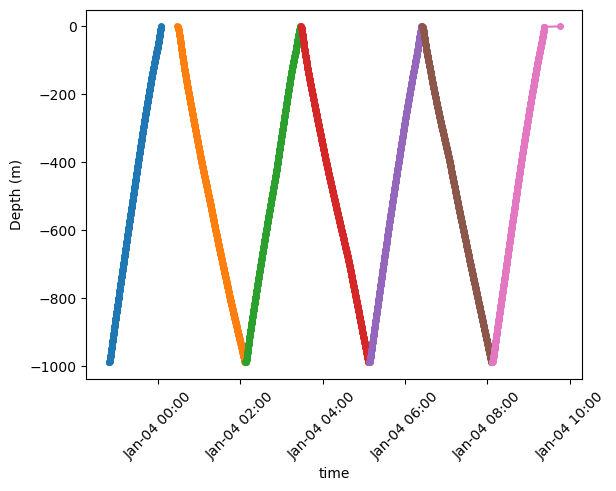

In [501]:
import matplotlib.dates as mdates


plt.plot(walle2019_dec_EW.gridded_time[:,588:595],- walle2019_dec_EW.depth, marker='o', markersize=4)
dtFmt = mdates.DateFormatter('%b-%d %H:%M') # define the formatting
plt.gca().xaxis.set_major_formatter(dtFmt) 
plt.xticks(rotation=45)
plt.ylabel('Depth (m)')
plt.xlabel('time')


In [5]:
# find the time of surfacing

true_lons = np.empty(len(walle2019_dec_EW.time))
true_lons[:] = np.nan  
####
true_lats = np.empty(len(walle2019_dec_EW.time))
true_lats[:] = np.nan  
     
####
true_times = np.empty(len(walle2019_dec_EW.time))
true_times[:] = np.nan  

section = walle2019_dec_EW

for i in range(len(section.time)-1): 
    if section.profile_direction[0,i] == -1: #if ascending 
        distance_difference = np.abs(section.gridded_time[0,i+1] - section.gridded_time[0,i]) 
        time_difference = np.abs(section.gridded_time[0,i] - section.gridded_time[1,i]) 

        if time_difference >=  (np.array(37100000000)).astype('timedelta64[ns]'): #25 seconds  
            true_lats[i] = (section.latitude[0,i].values) #lat coordinate
            true_lons[i]= (section.longitude[0,i].values) #lon coordinate 
            true_times[i] = (section.gridded_time[0,i].values.astype(np.float64)/1e9 )

        elif distance_difference >=  100000000000: #consecutive profiles are 0.02 degrees longtiude apart
            true_lats[i] = (section.latitude[0,i+1].values) #lat coordinate
            true_lons[i] = (section.longitude[0,i+1].values) #lon coordinate 
            true_times[i] = (section.gridded_time[0,i+1].values.astype(np.float64)/1e9 )

        else:
            true_lats[i] = np.nan #lat coordinate
            true_lons[i] = np.nan #lon coordinate 
            true_times[i] = np.nan
    
    elif (np.isnan(section.time_1970[0,i] ) and ~np.isnan(section.time_1970[0,i+1] )):
        true_lats[i] = (section.latitude[0,i+1].values) #lat coordinate
        true_lons[i] = (section.longitude[0,i+1].values) #lon coordinate 
        true_times[i] = (section.gridded_time[0,i+1].values.astype(np.float64)/1e9 )
 
    else:
        true_lats[i] = np.nan #lat coordinate
        true_lons[i] = np.nan #lon coordinate 
        true_times[i] = np.nan
                      

true_lats = true_lats[~np.isnan(true_times)]
true_lons = true_lons[~np.isnan(true_times)]
true_times = true_times[~np.isnan(true_times)]

In [6]:
section['new_lons'] = (('depth','time'), np.where(np.isnan(walle2019_dec_EW.potential_temperature), np.nan, np.nan))
section['new_lats'] = (('depth','time'), np.where(np.isnan(walle2019_dec_EW.potential_temperature), np.nan, np.nan))


##########interpolate surface 

good_indx = ~np.isnan(section.time_1970[0,:])
sfc_time = section.time_1970[0,good_indx] 

#######
sfc_lons = np.interp(sfc_time,true_times, true_lons)
section.new_lons[0,good_indx] = sfc_lons

sfc_lats = np.interp(sfc_time, true_times ,true_lats)
section.new_lats[0,good_indx] = sfc_lats


################ interpolate other depths 
for i in range(1,len(section.depth)):
    good_indx = ~np.isnan(section.time_1970[i,:])
    new_x = section.time_1970[i,good_indx]
    
    if len(new_x) > 0: 
        section.new_lons[i,good_indx] = np.interp(new_x,true_times, true_lons)
        section.new_lats[i,good_indx] = np.interp(new_x,true_times, true_lats)


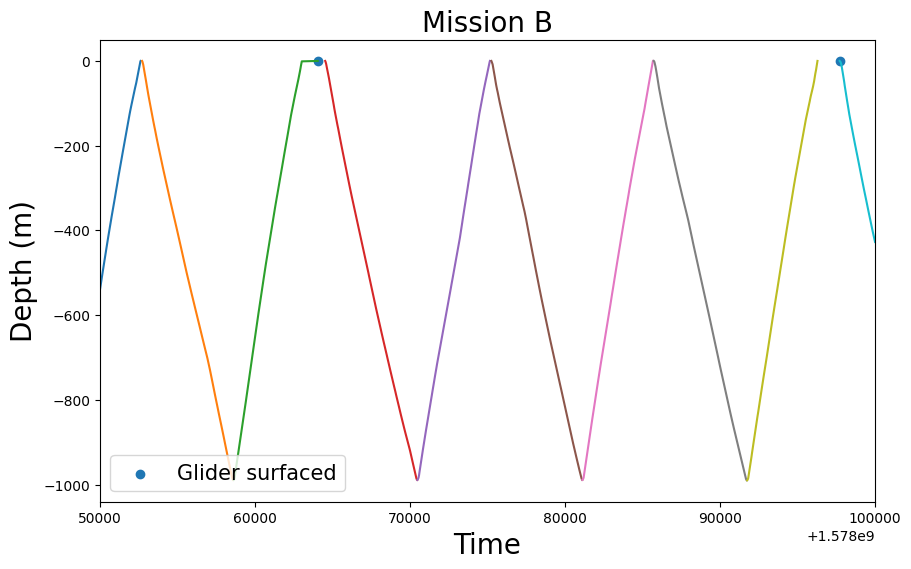

In [7]:
fig,axs=plt.subplots(figsize=(10,6))

axs.plot(section.time_1970,-section.depth )
axs.scatter((true_times)  , np.linspace(0,0,len(true_times)), label = 'Glider surfaced')
#axs.set_xticks(rotation=45)
axs.set_ylabel('Depth (m)',fontsize=20)
axs.set_xlabel('Time',fontsize=20)
axs.set_xlim(1.57805e9, 1.5781e9)
axs.set_title('Mission B',fontsize=20)
axs.legend(fontsize=15)

plt.savefig("original_lon.pdf", format="pdf", bbox_inches="tight", dpi=150)


(1578050000.0, 1578100000.0)

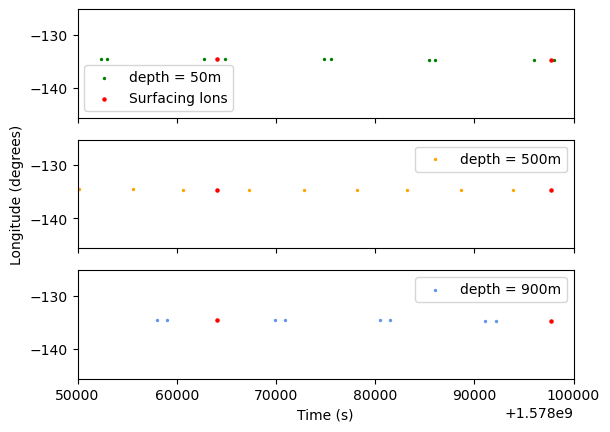

In [201]:
fig, axs = plt.subplots(3,1, sharex=True)

axs[0].scatter(section.time_1970[50,:],section.new_lons[50], c='green',marker='o' , s=2, label='depth = 50m')
axs[0].scatter(true_times,true_lons, marker='o', s=5, label = 'Surfacing lons',c='red')

axs[1].scatter(section.time_1970[500,:],section.new_lons[500], c='orange',marker='o' , s=2, label='depth = 500m')
axs[1]. scatter(true_times,true_lons, marker='o', s=5,c='red')

axs[2].scatter(section.time_1970[900,:],section.new_lons[900], c='cornflowerblue', marker='o' , s=2,label='depth = 900m')
axs[2]. scatter(true_times,true_lons, marker='o', s=5,c='red')

axs[0].legend(); axs[1].legend(); axs[2].legend()

axs[2].set_xlabel('Time (s)')
axs[1].set_ylabel ('Longitude (degrees)')

plt.xlim(1.57805e9, 1.5781e9)


Text(0.5, 1.0, 'Walle2019_dec_EW')

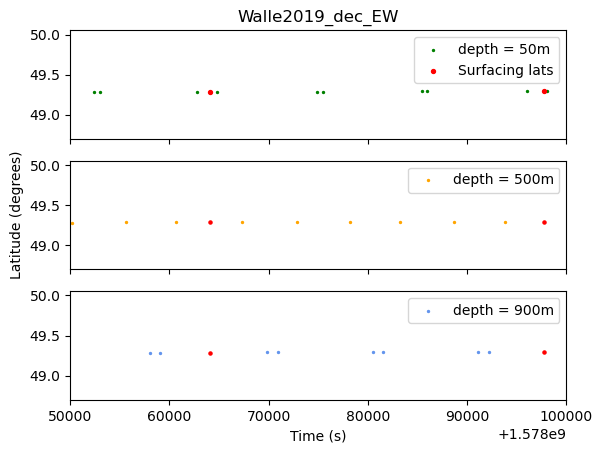

In [1273]:
fig, axs = plt.subplots(3,1,sharex=True)

axs[0].scatter(walle2019_dec_EW.time_1970[50,:],walle2019_dec_EW.new_lats[50], c='green',marker='o' , s=2,label='depth = 50m')
axs[0].scatter(true_times,true_lats, marker='o', s=8, label = 'Surfacing lats', c='red')


axs[1].scatter(walle2019_dec_EW.time_1970[500,:],walle2019_dec_EW.new_lats[500], c='orange',marker='o' ,s=2, label='depth = 500m')
axs[1]. scatter(true_times,true_lats, marker='o', s=5,c='red')

axs[2].scatter(walle2019_dec_EW.time_1970[900,:],walle2019_dec_EW.new_lats[900], c='cornflowerblue',marker='o' ,s=2, label='depth = 900m')
axs[2]. scatter(true_times,true_lats, marker='o', s=5,c='red')


axs[0].legend(); axs[1].legend(); axs[2].legend()

axs[2].set_xlabel('Time (s)')
axs[1].set_ylabel ('Latitude (degrees)')
plt.xlim(1.57805e9, 1.5781e9)
axs[0].set_title('Walle2019_dec_EW')

(1578000000.0, 1578100000.0)

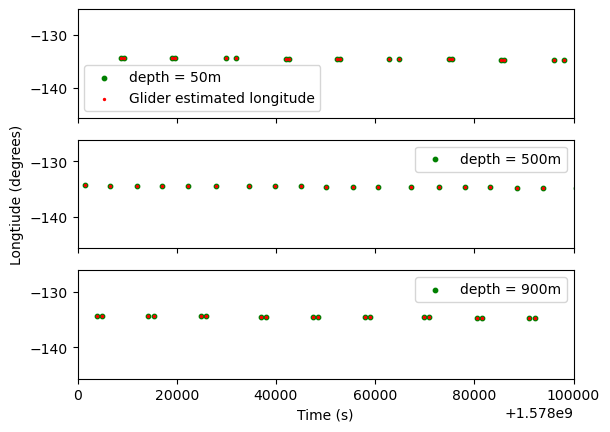

In [186]:
#####compare with old, glider estimated longitude

fig, axs = plt.subplots(3,1,sharex=True)

axs[0].scatter(walle2019_dec_EW.time_1970[50,:],walle2019_dec_EW.new_lons[50], c='green',marker='o' ,s=10,label='depth = 50m')
axs[0].scatter(walle2019_dec_EW.time_1970[50,:],walle2019_dec_EW.longitude[50], marker='o', s=2, label = 'Glider estimated longitude', c='red')


axs[1].scatter(walle2019_dec_EW.time_1970[500,:],walle2019_dec_EW.new_lons[500], c='green',marker='o' ,s=10,label='depth = 500m')
axs[1].scatter(walle2019_dec_EW.time_1970[500,:],walle2019_dec_EW.longitude[500], marker='o', s=2,  c='red')


axs[2].scatter(walle2019_dec_EW.time_1970[900,:],walle2019_dec_EW.new_lons[900], c='green',marker='o' ,s=10,label='depth = 900m')
axs[2].scatter(walle2019_dec_EW.time_1970[900,:],walle2019_dec_EW.longitude[900], marker='o', s=2,  c='red')



axs[0].legend(); axs[1].legend(); axs[2].legend()

axs[2].set_xlabel('Time (s)')
axs[1].set_ylabel ('Longtiude (degrees)')
axs[1].set_xlim(1.578e9, 1.5781e9)


(1578000000.0, 1578100000.0)

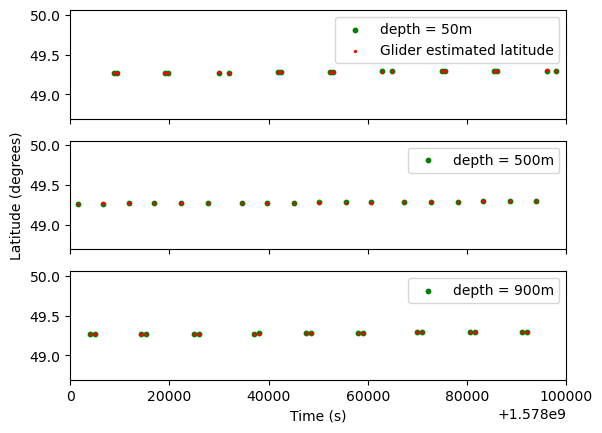

In [187]:

fig, axs = plt.subplots(3,1,sharex=True)

axs[0].scatter(walle2019_dec_EW.time_1970[50,:],walle2019_dec_EW.new_lats[50], c='green',marker='o' ,s=10,label='depth = 50m')
axs[0].scatter(walle2019_dec_EW.time_1970[50,:],walle2019_dec_EW.latitude[50], marker='o', s=2, label = 'Glider estimated latitude', c='red')


axs[1].scatter(walle2019_dec_EW.time_1970[500,:],walle2019_dec_EW.new_lats[500], c='green',marker='o' ,s=10,label='depth = 500m')
axs[1].scatter(walle2019_dec_EW.time_1970[500,:],walle2019_dec_EW.latitude[500], marker='o', s=2,  c='red')


axs[2].scatter(walle2019_dec_EW.time_1970[900,:],walle2019_dec_EW.new_lats[900], c='green',marker='o' ,s=10,label='depth = 900m')
axs[2].scatter(walle2019_dec_EW.time_1970[900,:],walle2019_dec_EW.latitude[900], marker='o', s=2,  c='red')



axs[0].legend(); axs[1].legend(); axs[2].legend()

axs[2].set_xlabel('Time (s)')
axs[1].set_ylabel ('Latitude (degrees)')
axs[1].set_xlim(1.578e9, 1.5781e9)


In [28]:
dist_noise(walle2019_dec_EW)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [29]:
####get rid of bad data spikes 

bad_pnts = [434,642,850,848,902,928,947]
ds_2 = walle2019_dec_EW.drop_isel(time=bad_pnts)
ds_3 = ds_2.drop_isel(time=[697,967,845])
ds_4 = ds_3.drop_isel(time=[964])


In [31]:
#######save this new location file 

ds_4.to_netcdf(dist_path+'walle2019_dec_EW_corrected_dist.nc')

In [21]:
##### fine grid
ds = xr.open_dataset(dist_path+'walle2019_dec_EW_corrected_dist.nc')
interpolate_even_dist(ds ,'walle2019_dec_EW.nc', 'EW')

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

Text(0.5, 0.98, 'walle2019_dec_EW')

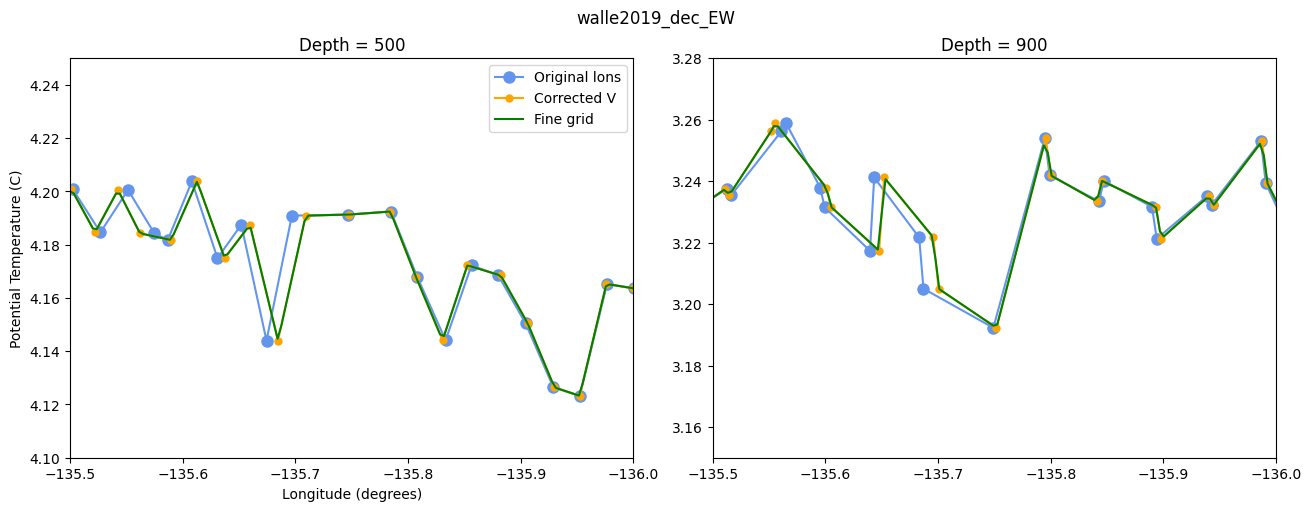

In [7]:
###compare data from original, corrected 'V' and interpolated data 
fig, axs = plt.subplots(1,2, layout='constrained',sharex=True, figsize=(13,5))
ds = xr.open_dataset(dist_path+'walle2019_dec_EW_corrected_dist.nc')


axs[0].plot(ds.longitude[500],ds.potential_temperature[500,:], marker='o', markersize=8,label='Original lons', color='cornflowerblue')  #original 
axs[0].plot(ds.new_lons[500],ds.potential_temperature[500,:], marker='o', markersize=5,label='Corrected V ', color='orange')  #original 


walle2019_dec_EW_interp = xr.open_dataset(fine_path + 'walle2019_dec_EW.nc')

axs[0].plot(walle2019_dec_EW_interp.longitude[500,:],walle2019_dec_EW_interp.potential_temperature[500,:], label ='Fine grid', color='green')  #interpolated
axs[0].set_ylim(4.1,4.25)

####

axs[1].plot(ds.longitude[900],ds.potential_temperature[900,:], marker='o', markersize=8,label='Original lons', color='cornflowerblue')  #original 
axs[1].plot(ds.new_lons[900],ds.potential_temperature[900,:], marker='o', markersize=5,label='Corrected V ', color='orange')  #original 
axs[1].plot(walle2019_dec_EW_interp.longitude[900,:],walle2019_dec_EW_interp.potential_temperature[900,:], label ='Fine grid', color='green')  #interpolated
axs[1].set_ylim(3.15,3.28)



axs[0].set_xlim(-135.5,-136)
axs[0].set_title('Depth = 500')
axs[1].set_title('Depth = 900')



axs[0].set_ylabel('Potential Temperature (C)')
axs[0].set_xlabel('Longitude (degrees)')
axs[0].legend()
fig.suptitle('walle2019_dec_EW')

/var/folders/4f/2tlph0394xl3ljq0c7zz4t380000gn/T/ipykernel_22838/3887824401.py:5: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.
  axs[0].pcolor(ds.longitude[:,:],-ds.depth,ds.potential_temperature, cmap=cmap, vmin=vmin, vmax=vmax,rasterized=True)


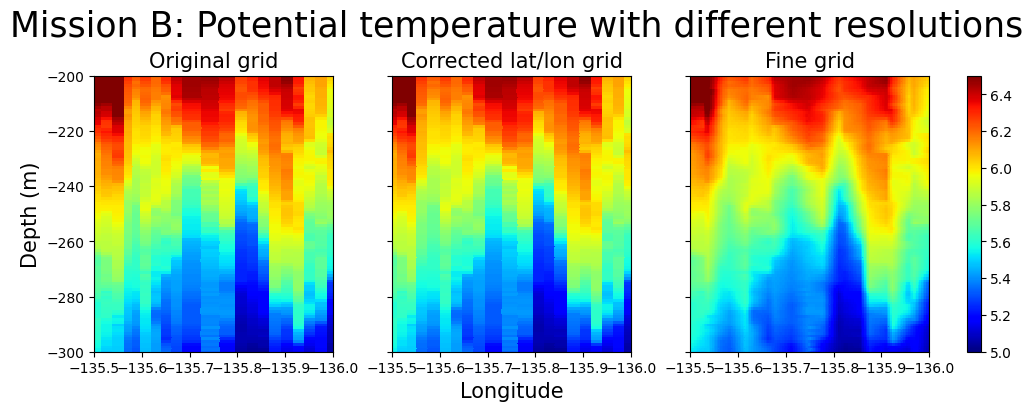

In [11]:
fig, axs = plt.subplots(1,3, layout='constrained',sharey=True,sharex=True, figsize=(10,4))

cmap='jet'; vmin=5; vmax=6.5

axs[0].pcolor(ds.longitude[:,:],-ds.depth,ds.potential_temperature, cmap=cmap, vmin=vmin, vmax=vmax,rasterized=True)
axs[1].pcolor(ds.new_lons[:,:],-ds.depth,ds.potential_temperature,cmap=cmap, vmin=vmin, vmax=vmax,rasterized=True)
im = axs[2].pcolor(walle2019_dec_EW_interp.longitude,-walle2019_dec_EW_interp.depth,
                   walle2019_dec_EW_interp.potential_temperature,cmap=cmap, vmin=vmin, vmax=vmax,rasterized=True)
fig.colorbar(im)

axs[0].set_xlim(-135.5,-136)
axs[0].set_ylim(-300, -200)

axs[1].set_xlabel('Longitude', fontsize=15)
axs[0]. set_ylabel('Depth (m)', fontsize=15)

axs[0].set_title('Original grid', fontsize=15)
axs[1].set_title('Corrected lat/lon grid', fontsize=15)
axs[2].set_title('Fine grid', fontsize=15)
fig.suptitle('Mission B: Potential temperature with different resolutions', fontsize=25)

plt.savefig("regrid.pdf", format="pdf", bbox_inches="tight", dpi=150)


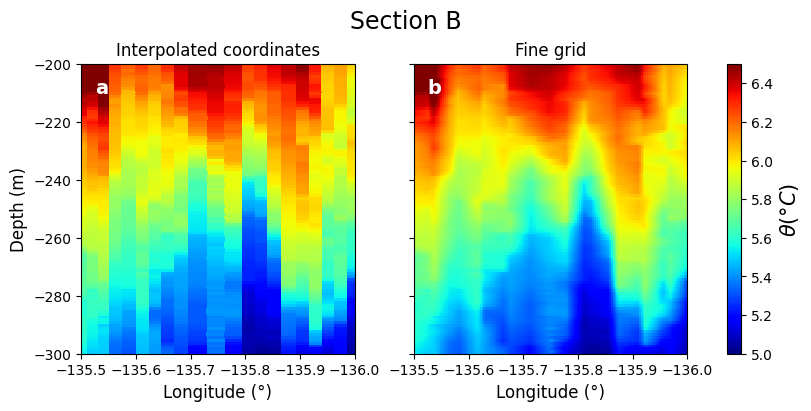

In [10]:
fig, axs = plt.subplots(1,2, layout='constrained',sharey=True,sharex=True, figsize=(8,4))

cmap='jet'; vmin=5; vmax=6.5

#axs[0].pcolor(ds.longitude[:,:],-ds.depth,ds.potential_temperature, cmap=cmap, vmin=vmin, vmax=vmax,rasterized=True)
axs[0].pcolor(ds.new_lons[:,:],-ds.depth,ds.potential_temperature,cmap=cmap, vmin=vmin, vmax=vmax,rasterized=True)
im = axs[1].pcolor(walle2019_dec_EW_interp.longitude,-walle2019_dec_EW_interp.depth,
                   walle2019_dec_EW_interp.potential_temperature,cmap=cmap, vmin=vmin, vmax=vmax,rasterized=True)
cbar=fig.colorbar(im)
cbar.ax.set_ylabel(r'$\theta (°C)$', fontsize = 15)

axs[0].set_xlim(-135.5,-136)
axs[0].set_ylim(-300, -200)

axs[0].set_xlabel('Longitude (°)', fontsize=12)
axs[0]. set_ylabel('Depth (m)', fontsize=12)
axs[1].set_xlabel('Longitude (°)', fontsize=12)

#axs[0].set_title('Original grid', fontsize=15)
axs[0].set_title('Interpolated coordinates', fontsize=12)
axs[1].set_title('Fine grid', fontsize=12)
fig.suptitle('Section B', fontsize=17)
axs[0].text(0.05, 0.95, 'a', transform=axs[0].transAxes,
            fontsize=14, fontweight='bold', va='top', ha='left',color='white')
axs[1].text(0.05, 0.95, 'b', transform=axs[1].transAxes,
            fontsize=14, fontweight='bold', va='top', ha='left',color='white')
plt.savefig("regrid.pdf", format="pdf", bbox_inches="tight", dpi=150)


WE

In [33]:
# find the time of surfacing
section =walle2019_dec_WE

true_lons = np.empty(len(walle2019_dec_WE.time))
true_lons[:] = np.nan  
####
true_lats = np.empty(len(walle2019_dec_WE.time))
true_lats[:] = np.nan  
     
####
true_times = np.empty(len(walle2019_dec_WE.time))
true_times[:] = np.nan  

for i in range(len(section.time)-1): 
    if section.profile_direction[0,i] == -1: #if ascending 
        distance_difference = np.abs(section.gridded_time[0,i+1] - section.gridded_time[0,i]) 
        time_difference = np.abs(section.gridded_time[0,i] - section.gridded_time[1,i]) 

        if time_difference >=  (np.array(37100000000)).astype('timedelta64[ns]'): #25 seconds  
            true_lats[i] = (section.latitude[0,i].values) #lat coordinate
            true_lons[i]= (section.longitude[0,i].values) #lon coordinate 
            true_times[i] = (section.gridded_time[0,i].values.astype(np.float64)/1e9 )

        elif distance_difference >=  100000000000: #consecutive profiles are 0.02 degrees longtiude apart
            true_lats[i] = (section.latitude[0,i+1].values) #lat coordinate
            true_lons[i] = (section.longitude[0,i+1].values) #lon coordinate 
            true_times[i] = (section.gridded_time[0,i+1].values.astype(np.float64)/1e9 )

        else:
            true_lats[i] = np.nan #lat coordinate
            true_lons[i] = np.nan #lon coordinate 
            true_times[i] = np.nan
    
    elif (np.isnan(section.time_1970[0,i] ) and ~np.isnan(section.time_1970[0,i+1] )):
        true_lats[i] = (section.latitude[0,i+1].values) #lat coordinate
        true_lons[i] = (section.longitude[0,i+1].values) #lon coordinate 
        true_times[i] = (section.gridded_time[0,i+1].values.astype(np.float64)/1e9 )
 
    else:
        true_lats[i] = np.nan #lat coordinate
        true_lons[i] = np.nan #lon coordinate 
        true_times[i] = np.nan
                        
 


true_lats = true_lats[~np.isnan(true_times)]
true_lons = true_lons[~np.isnan(true_times)]
true_times = true_times[~np.isnan(true_times)]

In [34]:
walle2019_dec_WE['new_lons'] = (('depth','time'), np.where(np.isnan(walle2019_dec_WE.potential_temperature), np.nan, np.nan))
walle2019_dec_WE['new_lats'] = (('depth','time'), np.where(np.isnan(walle2019_dec_WE.potential_temperature), np.nan, np.nan))


##########interpolate surface 

good_indx = ~np.isnan(walle2019_dec_WE.time_1970[0,:])
sfc_time = walle2019_dec_WE.time_1970[0,good_indx] 

#######
sfc_lons = np.interp(sfc_time,true_times, true_lons)
walle2019_dec_WE.new_lons[0,good_indx] = sfc_lons

sfc_lats = np.interp(sfc_time, true_times ,true_lats)
walle2019_dec_WE.new_lats[0,good_indx] = sfc_lats


################ interpolate other depths 
for i in range(1,len(walle2019_dec_WE.depth)):
    good_indx = ~np.isnan(walle2019_dec_WE.time_1970[i,:])
    new_x = walle2019_dec_WE.time_1970[i,good_indx]
    
    if len(new_x) > 0: 
        walle2019_dec_WE.new_lons[i,good_indx] = np.interp(new_x,true_times, true_lons)
        walle2019_dec_WE.new_lats[i,good_indx] = np.interp(new_x,true_times, true_lats)


In [35]:
dist_noise(walle2019_dec_WE)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

Text(0.5, 1.0, 'walle2019_dec_WE')

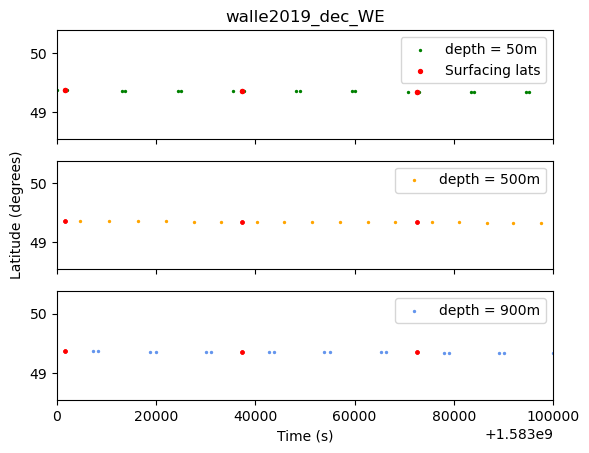

In [36]:
fig, axs = plt.subplots(3,1,sharex=True)

axs[0].scatter(walle2019_dec_WE.time_1970[50,:],walle2019_dec_WE.new_lats[50], c='green',marker='o' , s=2,label='depth = 50m')
axs[0].scatter(true_times,true_lats, marker='o', s=8, label = 'Surfacing lats', c='red')


axs[1].scatter(walle2019_dec_WE.time_1970[500,:],walle2019_dec_WE.new_lats[500], c='orange',marker='o' ,s=2, label='depth = 500m')
axs[1]. scatter(true_times,true_lats, marker='o', s=5,c='red')

axs[2].scatter(walle2019_dec_WE.time_1970[900,:],walle2019_dec_WE.new_lats[900], c='cornflowerblue',marker='o' ,s=2, label='depth = 900m')
axs[2]. scatter(true_times,true_lats, marker='o', s=5,c='red')


axs[0].legend(); axs[1].legend(); axs[2].legend()

axs[2].set_xlabel('Time (s)')
axs[1].set_ylabel ('Latitude (degrees)')
axs[1].set_xlim(1.583e9, 1.5831e9)
axs[0].set_title('walle2019_dec_WE')

Text(0.5, 1.0, 'Walle2019_dec_WE')

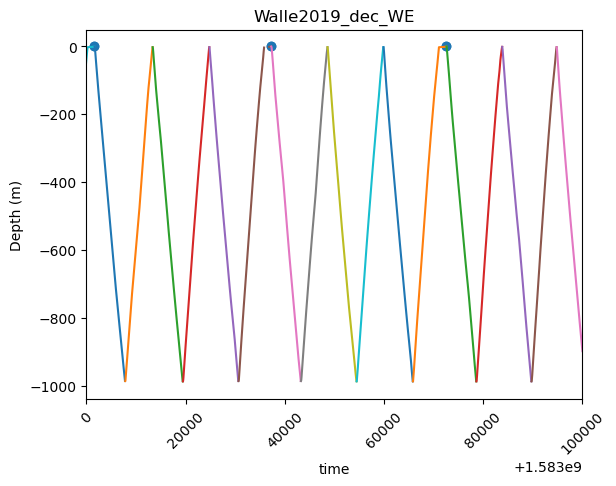

In [512]:
plt.plot(walle2019_dec_WE.time_1970,-walle2019_dec_WE.depth )
plt.scatter((true_times)  , np.linspace(0,0,len(true_times)))
plt.xticks(rotation=45)
plt.ylabel('Depth (m)')
plt.xlabel('time')
 
#plt.xlim((walle2019_dec_WE.gridded_time[0,583]),walle2019_dec_WE.gridded_time[0,595])
plt.xlim(((1.583e9)) , (1.5831e9))
plt.title('Walle2019_dec_WE')

(0.0, 300.0)

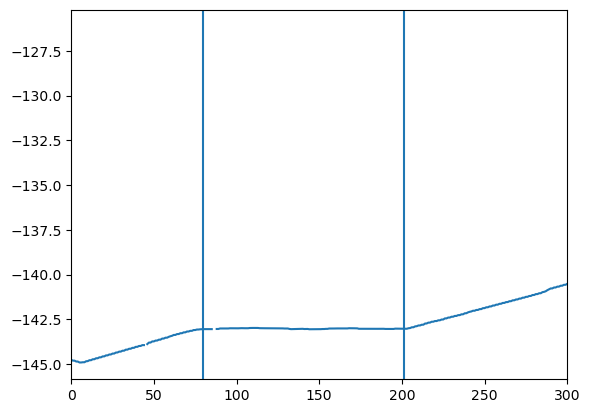

In [37]:
###### cut out when the glider passes over eddy many times (so we don't stack the )


plt.plot(walle2019_dec_WE.longitude[0])
plt.axvline(x=80)
plt.axvline(x=201)

plt.xlim(0,300)

In [38]:
####get rid of bad spikes
eddy= np.arange(80,120,1)
ds2 = walle2019_dec_WE.drop_isel(time=eddy)#, 278, 279, 315,364,368, 580])
ds3 = ds2.drop_isel(time=[49,239,238 ,274,275,276,324,328,540, 539])

In [39]:
#######save this new location file 

ds3.to_netcdf(dist_path+'walle2019_dec_WE_corrected_dist.nc')

In [40]:
##### fine grid
ds = xr.open_dataset(dist_path+'walle2019_dec_WE_corrected_dist.nc')
interpolate_even_dist(ds ,'walle2019_dec_WE.nc', 'WE')

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

/opt/anaconda3/envs/eos431/lib/python3.12/site-packages/xarray/core/nputils.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)
/opt/anaconda3/envs/eos431/lib/python3.12/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Text(0.5, 0.98, 'walle2019_dec_WE')

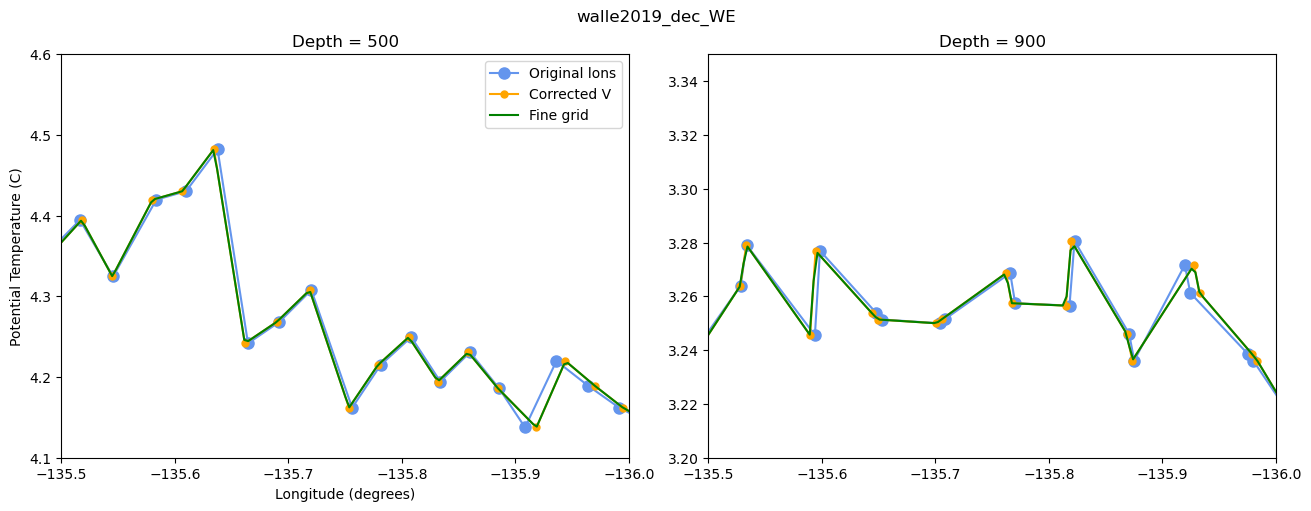

In [297]:
###compare data from original, corrected 'V' and interpolated data 
fig, axs = plt.subplots(1,2, layout='constrained',sharex=True, figsize=(13,5))


axs[0].plot(ds.longitude[500],ds.potential_temperature[500,:], marker='o', markersize=8,label='Original lons', color='cornflowerblue')  #original 
axs[0].plot(ds.new_lons[500],ds.potential_temperature[500,:], marker='o', markersize=5,label='Corrected V ', color='orange')  #original 


walle2019_dec_WE_interp = xr.open_dataset(fine_path + 'walle2019_dec_WE.nc')

axs[0].plot(walle2019_dec_WE_interp.longitude[500,:],walle2019_dec_WE_interp.potential_temperature[500,:], label ='Fine grid', color='green')  #interpolated
axs[0].set_ylim(4.1,4.6)

####

axs[1].plot(ds.longitude[900],ds.potential_temperature[900,:], marker='o', markersize=8,label='Original lons', color='cornflowerblue')  #original 
axs[1].plot(ds.new_lons[900],ds.potential_temperature[900,:], marker='o', markersize=5,label='Corrected V ', color='orange')  #original 
axs[1].plot(walle2019_dec_WE_interp.longitude[900,:],walle2019_dec_WE_interp.potential_temperature[900,:], label ='Fine grid', color='green')  #interpolated
axs[1].set_ylim(3.2,3.35)



axs[0].set_xlim(-135.5,-136)
axs[0].set_title('Depth = 500')
axs[1].set_title('Depth = 900')



axs[0].set_ylabel('Potential Temperature (C)')
axs[0].set_xlabel('Longitude (degrees)')
axs[0].legend()
fig.suptitle('walle2019_dec_WE')

/var/folders/4f/2tlph0394xl3ljq0c7zz4t380000gn/T/ipykernel_26171/967276829.py:5: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.
  axs[0].pcolor(ds.longitude[:,:],-ds.depth,ds.potential_temperature, cmap=cmap, vmin=vmin, vmax=vmax)
/var/folders/4f/2tlph0394xl3ljq0c7zz4t380000gn/T/ipykernel_26171/967276829.py:6: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.
  axs[1].pcolor(ds.new_lons[:,:],-ds.depth,ds.potential_temperature,cmap=cmap, vmin=vmin, vmax=vmax)
/var/folders/4f/2tlph0394xl3ljq0c7zz4t380000gn/T/ipykernel_26171/967276829.py:7: UserWarning: The input coordinates to pcolor are interpreted as cell 

Text(0.5, 0.98, 'Walle2019_dec_WE')

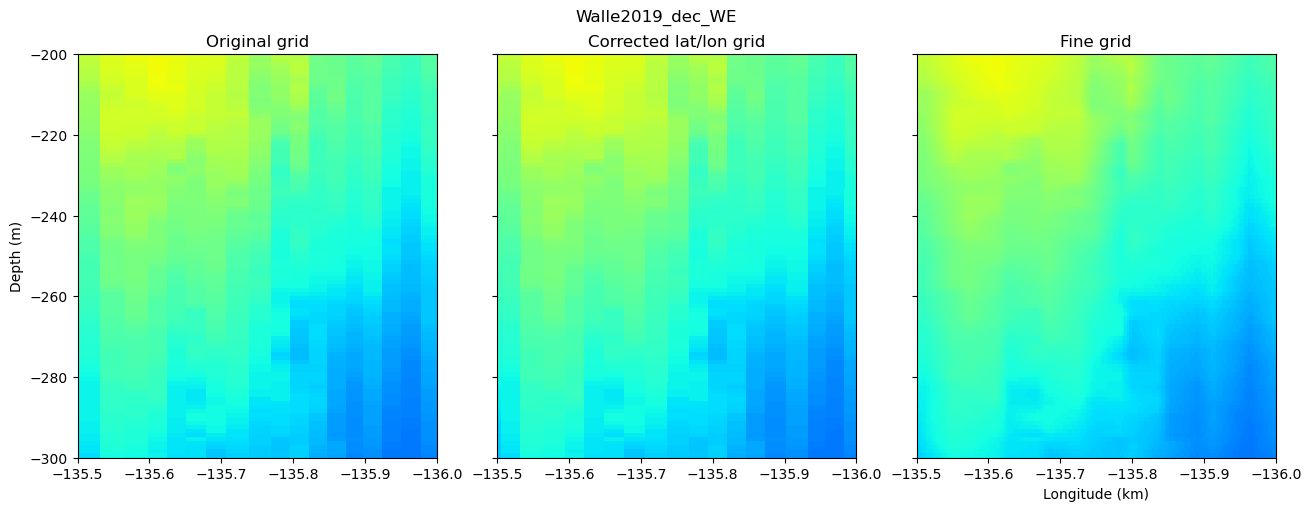

In [298]:
fig, axs = plt.subplots(1,3, layout='constrained',sharey=True,sharex=True, figsize=(13,5))

cmap='jet'; vmin=4; vmax=8

axs[0].pcolor(ds.longitude[:,:],-ds.depth,ds.potential_temperature, cmap=cmap, vmin=vmin, vmax=vmax)
axs[1].pcolor(ds.new_lons[:,:],-ds.depth,ds.potential_temperature,cmap=cmap, vmin=vmin, vmax=vmax)
axs[2].pcolor(walle2019_dec_WE_interp.longitude,-walle2019_dec_WE_interp.depth,walle2019_dec_WE_interp.potential_temperature,cmap=cmap, vmin=vmin, vmax=vmax)

axs[0].set_xlim(-135.5,-136)
axs[0].set_ylim(-300, -200)

axs[2].set_xlabel('Longitude (km)')
axs[0]. set_ylabel('Depth (m)')

axs[0].set_title('Original grid')
axs[1].set_title('Corrected lat/lon grid')
axs[2].set_title('Fine grid')
fig.suptitle('Walle2019_dec_WE')

# Walle2021

/var/folders/4f/2tlph0394xl3ljq0c7zz4t380000gn/T/ipykernel_20891/3547338046.py:9: UserWarning: Converting non-nanosecond precision timedelta values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  walle2021['gridded_time']= walle2021.time_1970.astype('timedelta64[s]') + np.datetime64('1970-01-01T00:00:00')


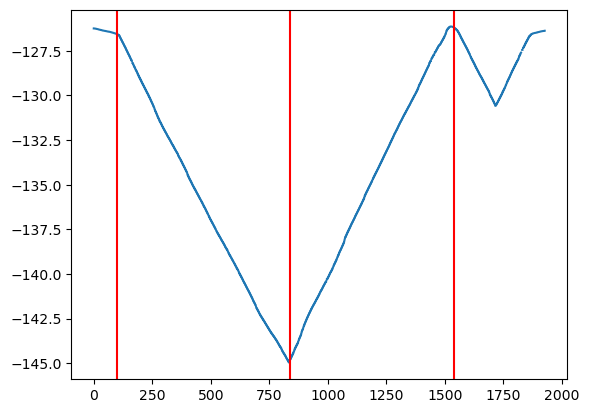

In [40]:
with xr.open_dataset(path+files[2]) as walle2021:
        
    x = np.linspace(0, len(walle2021.time), len(walle2021.time))
    plt.plot(x, walle2021.longitude[0,:])
    
    plt.axvline(x=100, c='red')
    plt.axvline(x=840, c='red')
    plt.axvline(x=1540, c='red')
    walle2021['gridded_time']= walle2021.time_1970.astype('timedelta64[s]') + np.datetime64('1970-01-01T00:00:00') 

    walle2021_EW = walle2021.isel(time=range(110,840,1))
    walle2021_WE = walle2021.isel(time=range(840,1540,1))

EW

In [42]:
section = walle2021_EW
    
true_lons = np.empty(len(section.time))
true_lons[:] = np.nan  
####
true_lats = np.empty(len(section.time))
true_lats[:] = np.nan  

####
true_times = np.empty(len(section.time))
true_times[:] = np.nan  

for i in range(len(section.time)-1): 
    if section.profile_direction[0,i] == -1: #if ascending 
        distance_difference = np.abs(section.gridded_time[0,i+1] - section.gridded_time[0,i]) 
        time_difference = np.abs(section.gridded_time[0,i] - section.gridded_time[1,i]) 

        if time_difference >=  (np.array(37100000000)).astype('timedelta64[ns]'): #25 seconds  
            true_lats[i] = (section.latitude[0,i].values) #lat coordinate
            true_lons[i]= (section.longitude[0,i].values) #lon coordinate 
            true_times[i] = (section.gridded_time[0,i].values.astype(np.float64)/1e9 )

        elif distance_difference >=  100000000000: #consecutive profiles are 0.02 degrees longtiude apart
            true_lats[i] = (section.latitude[0,i+1].values) #lat coordinate
            true_lons[i] = (section.longitude[0,i+1].values) #lon coordinate 
            true_times[i] = (section.gridded_time[0,i+1].values.astype(np.float64)/1e9 )

        else:
            true_lats[i] = np.nan #lat coordinate
            true_lons[i] = np.nan #lon coordinate 
            true_times[i] = np.nan
    
    elif (np.isnan(section.time_1970[0,i] ) and ~np.isnan(section.time_1970[0,i+1] )):
        true_lats[i] = (section.latitude[0,i+1].values) #lat coordinate
        true_lons[i] = (section.longitude[0,i+1].values) #lon coordinate 
        true_times[i] = (section.gridded_time[0,i+1].values.astype(np.float64)/1e9 )
            
    else:
        true_lats[i] = np.nan #lat coordinate
        true_lons[i] = np.nan #lon coordinate 
        true_times[i] = np.nan
        


true_lats = true_lats[~np.isnan(true_times)]
true_lons = true_lons[~np.isnan(true_times)]
true_times= true_times[~np.isnan(true_times)]       

In [43]:

section['new_lons'] = (('depth','time'), np.where(np.isnan(section.potential_temperature), np.nan, np.nan))
section['new_lats'] = (('depth','time'), np.where(np.isnan(section.potential_temperature), np.nan, np.nan))


##########interpolate surface 

good_indx = ~np.isnan(section.time_1970[0,:])
sfc_time = section.time_1970[0,good_indx] 

#######
sfc_lons = np.interp(sfc_time,true_times, true_lons)
section.new_lons[0,good_indx] = sfc_lons

sfc_lats = np.interp(sfc_time, true_times ,true_lats)
section.new_lats[0,good_indx] = sfc_lats


################ interpolate other depths 
for i in range(1,len(section.depth)):
    good_indx = ~(np.isnan(section.time_1970[i,:])  )
    new_x = section.time_1970[i,good_indx]

    if len(new_x) > 0: 
        section.new_lons[i,good_indx] = np.interp(new_x,true_times, true_lons)
        section.new_lats[i,good_indx] = np.interp(new_x,true_times, true_lats)


In [44]:
dist_noise(section)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

Text(0.5, 1.0, 'walle2021_EW')

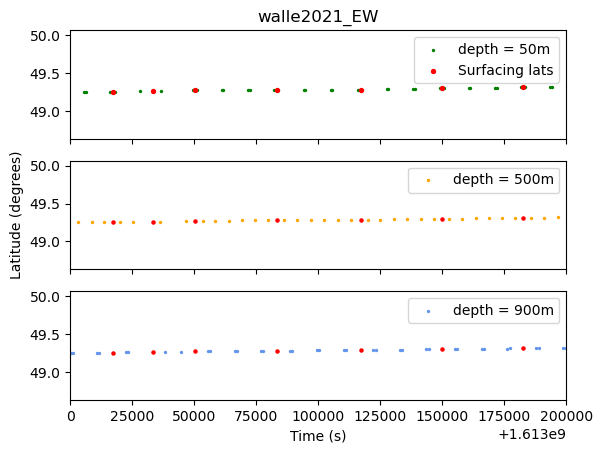

In [45]:
fig, axs = plt.subplots(3,1,sharex=True)

axs[0].scatter(section.time_1970[50,:],section.new_lats[50], c='green',marker='o' , s=2,label='depth = 50m')
axs[0].scatter(true_times,true_lats, marker='o', s=8, label = 'Surfacing lats', c='red')


axs[1].scatter(section.time_1970[500,:],section.new_lats[500], c='orange',marker='o' ,s=2, label='depth = 500m')
axs[1]. scatter(true_times,true_lats, marker='o', s=5,c='red')

axs[2].scatter(section.time_1970[900,:],section.new_lats[900], c='cornflowerblue',marker='o' ,s=2, label='depth = 900m')
axs[2]. scatter(true_times,true_lats, marker='o', s=5,c='red')


axs[0].legend(); axs[1].legend(); axs[2].legend()

axs[2].set_xlabel('Time (s)')
axs[1].set_ylabel ('Latitude (degrees)')
axs[1].set_xlim(1.613e9, 1.6132e9)
axs[0].set_title('walle2021_EW')

Text(0.5, 1.0, 'walle2021_EW')

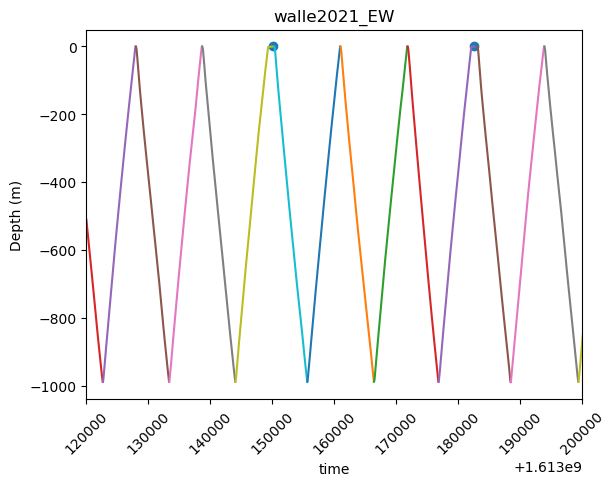

In [182]:
plt.plot(walle2021_EW.time_1970,-walle2021_EW.depth )
plt.scatter((true_times)  , np.linspace(0,0,len(true_times)))
plt.xticks(rotation=45)
plt.ylabel('Depth (m)')
plt.xlabel('time')
 
#plt.xlim((walle2019_dec_WE.gridded_time[0,583]),walle2019_dec_WE.gridded_time[0,595])
plt.xlim(1.61312e9, 1.6132e9)
plt.title('walle2021_EW')

In [47]:
#### remove bad points 
ds2 = walle2021_EW.drop_isel(time=[373, 400,423,546,620])


In [48]:
ds2.to_netcdf(dist_path+'walle2021_EW_corrected_dist.nc')

In [49]:
##### fine grid
ds = xr.open_dataset(dist_path+'walle2021_EW_corrected_dist.nc')
interpolate_even_dist(ds ,'walle2021_EW.nc', 'EW')

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

/opt/anaconda3/envs/eos431/lib/python3.12/site-packages/xarray/core/nputils.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)
/opt/anaconda3/envs/eos431/lib/python3.12/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Text(0.5, 0.98, 'Walle2021_EW')

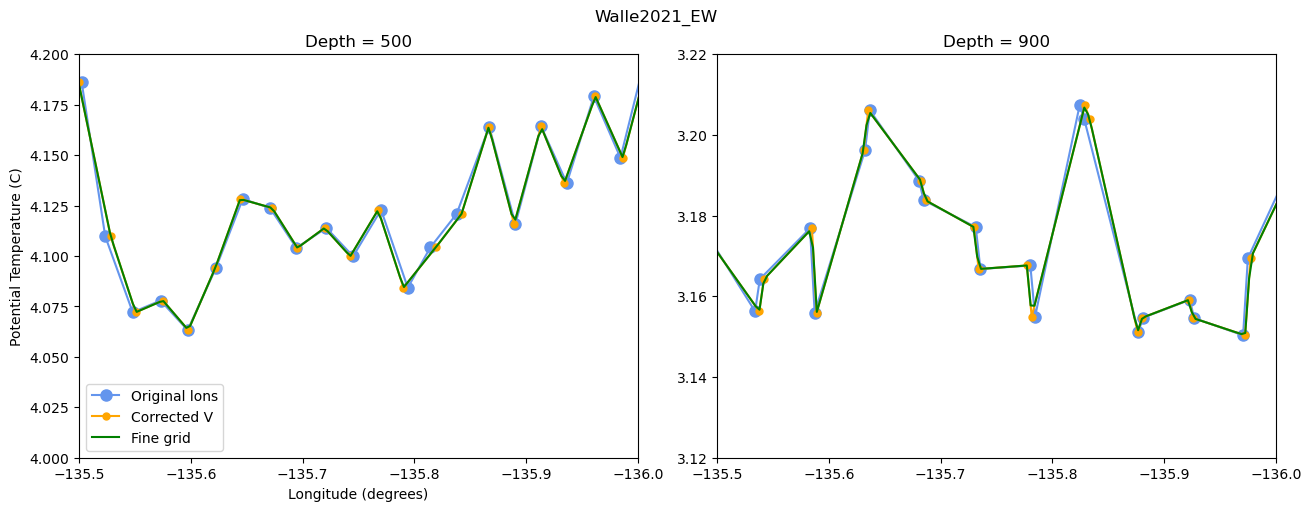

In [50]:
###compare data from original, corrected 'V' and interpolated data 
fig, axs = plt.subplots(1,2, layout='constrained',sharex=True, figsize=(13,5))


axs[0].plot(ds.longitude[500],ds.potential_temperature[500,:], marker='o', markersize=8,label='Original lons', color='cornflowerblue')  #original 
axs[0].plot(ds.new_lons[500],ds.potential_temperature[500,:], marker='o', markersize=5,label='Corrected V ', color='orange')  #original 


walle2021_EW_interp = xr.open_dataset(fine_path + 'walle2021_EW.nc')

axs[0].plot(walle2021_EW_interp.longitude[500,:],walle2021_EW_interp.potential_temperature[500,:], label ='Fine grid', color='green')  #interpolated
axs[0].set_ylim(4,4.2)

####

axs[1].plot(ds.longitude[900],ds.potential_temperature[900,:], marker='o', markersize=8,label='Original lons', color='cornflowerblue')  #original 
axs[1].plot(ds.new_lons[900],ds.potential_temperature[900,:], marker='o', markersize=5,label='Corrected V ', color='orange')  #original 
axs[1].plot(walle2021_EW_interp.longitude[900,:],walle2021_EW_interp.potential_temperature[900,:], label ='Fine grid', color='green')  #interpolated
axs[1].set_ylim(3.12,3.22)



axs[0].set_xlim(-135.5,-136)
axs[0].set_title('Depth = 500')
axs[1].set_title('Depth = 900')



axs[0].set_ylabel('Potential Temperature (C)')
axs[0].set_xlabel('Longitude (degrees)')
axs[0].legend()
fig.suptitle('Walle2021_EW')

/var/folders/4f/2tlph0394xl3ljq0c7zz4t380000gn/T/ipykernel_26171/4033443119.py:5: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.
  axs[0].pcolor(ds.longitude[:,:],-ds.depth,ds.potential_temperature, cmap=cmap, vmin=vmin, vmax=vmax)
/var/folders/4f/2tlph0394xl3ljq0c7zz4t380000gn/T/ipykernel_26171/4033443119.py:6: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.
  axs[1].pcolor(ds.new_lons[:,:],-ds.depth,ds.potential_temperature,cmap=cmap, vmin=vmin, vmax=vmax)
/var/folders/4f/2tlph0394xl3ljq0c7zz4t380000gn/T/ipykernel_26171/4033443119.py:7: UserWarning: The input coordinates to pcolor are interpreted as ce

Text(0.5, 0.98, 'walle2021_EW')

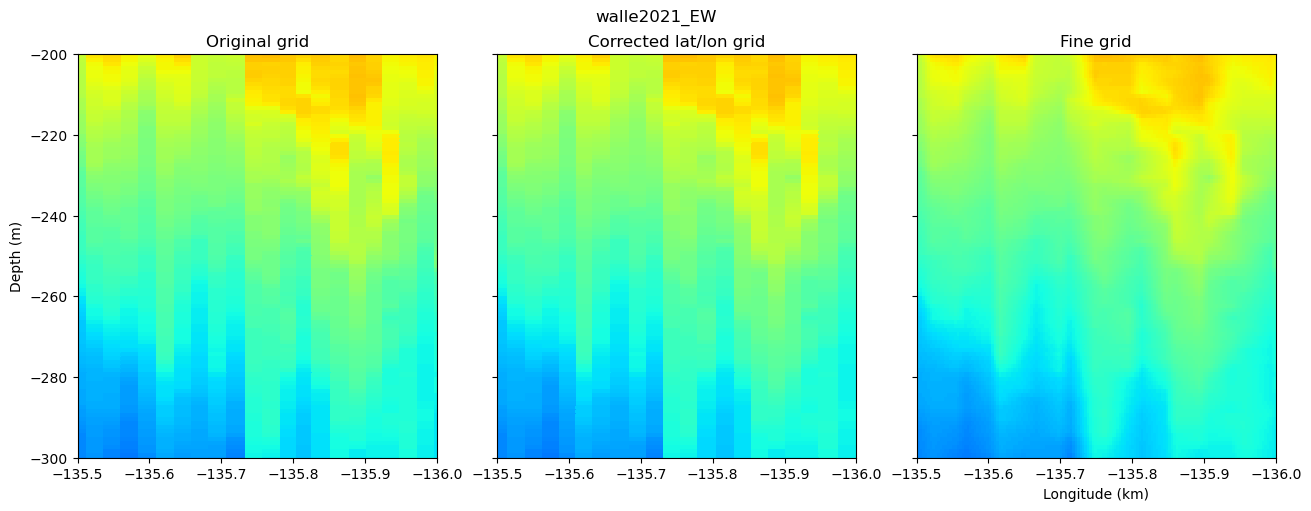

In [293]:
fig, axs = plt.subplots(1,3, layout='constrained',sharey=True,sharex=True, figsize=(13,5))

cmap='jet'; vmin=4; vmax=6.5

axs[0].pcolor(ds.longitude[:,:],-ds.depth,ds.potential_temperature, cmap=cmap, vmin=vmin, vmax=vmax)
axs[1].pcolor(ds.new_lons[:,:],-ds.depth,ds.potential_temperature,cmap=cmap, vmin=vmin, vmax=vmax)
axs[2].pcolor(walle2021_EW_interp.longitude,-walle2021_EW_interp.depth,walle2021_EW_interp.potential_temperature,cmap=cmap, vmin=vmin, vmax=vmax)

axs[0].set_xlim(-135.5,-136)
axs[0].set_ylim(-300, -200)

axs[2].set_xlabel('Longitude (km)')
axs[0]. set_ylabel('Depth (m)')

axs[0].set_title('Original grid')
axs[1].set_title('Corrected lat/lon grid')
axs[2].set_title('Fine grid')
fig.suptitle('walle2021_EW')

WE

Text(0.5, 1.0, 'walle2021_WE')

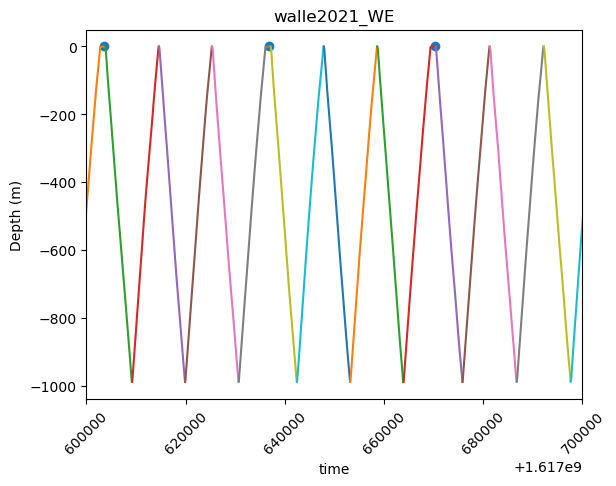

In [51]:
section = walle2021_WE.drop_isel(time=350)
    
true_lons = []
####
true_lats = []

####
true_times = []

for i in range(len(section.time)-1): 
        
    if section.profile_direction[0,i] == -1: #if ascending 
        distance_difference = np.abs(section.gridded_time[0,i+1] - section.gridded_time[0,i]) 
        time_difference = np.abs(section.gridded_time[0,i] - section.gridded_time[1,i]) 

        if time_difference >=  (np.array(37100000000)).astype('timedelta64[ns]'): #25 seconds  
            true_lats.append(section.latitude[0,i].values) #lat coordinate
            true_lons.append(section.longitude[0,i].values) #lon coordinate 
            true_times.append(section.gridded_time[0,i].values.astype(np.float64)/1e9 )
        
        elif distance_difference >=  11760000000000: #consecutive profiles are 0.02 degrees longtiude apart
            true_lats.append(section.latitude[0,i].values) #lat coordinate
            true_lons.append(section.longitude[0,i].values) #lon coordinate 
            true_times.append(section.gridded_time[0,i].values.astype(np.float64)/1e9 )
            true_lats.append(section.latitude[0,i+1].values) #lat coordinate
            true_lons.append(section.longitude[0,i+1].values) #lon coordinate 
            true_times.append(section.gridded_time[0,i+1].values.astype(np.float64)/1e9 )
 
 
 
        elif distance_difference >=  1000000000000: #consecutive profiles are 0.02 degrees longtiude apart
            true_lats.append(section.latitude[0,i+1].values) #lat coordinate
            true_lons.append(section.longitude[0,i+1].values) #lon coordinate 
            true_times.append(section.gridded_time[0,i+1].values.astype(np.float64)/1e9 )
            
        else:
            true_lats.append(np.nan) #lat coordinate
            true_lons.append(np.nan)#lon coordinate 
            true_times.append(np.nan)
    else:
        true_lats.append(np.nan) #lat coordinate
        true_lons.append(np.nan) #lon coordinate 
        true_times.append(np.nan)
true_lats= np.array(true_lats); true_lons= np.array(true_lons); true_times = np.array(true_times)
        
true_lats = true_lats[~np.isnan(true_times)]
true_lons = true_lons[~np.isnan(true_times)]
true_times = true_times[~np.isnan(true_times)]     



section['new_lons'] = (('depth','time'), np.where(np.isnan(section.potential_temperature), np.nan, np.nan))
section['new_lats'] = (('depth','time'), np.where(np.isnan(section.potential_temperature), np.nan, np.nan))


##########interpolate surface 

good_indx = ~np.isnan(section.time_1970[0,:])
sfc_time = section.time_1970[0,good_indx] 

#######
sfc_lons = np.interp(sfc_time,true_times, true_lons)
section.new_lons[0,good_indx] = sfc_lons

sfc_lats = np.interp(sfc_time, true_times ,true_lats)
section.new_lats[0,good_indx] = sfc_lats


################ interpolate other depths 
for i in range(1,len(section.depth)):
    good_indx = ~(np.isnan(section.time_1970[i,:])  )
    new_x = section.time_1970[i,good_indx]

    if len(new_x) > 0: 
        section.new_lons[i,good_indx] = np.interp(new_x,true_times, true_lons)
        section.new_lats[i,good_indx] = np.interp(new_x,true_times, true_lats)


########


plt.plot(section.time_1970,-section.depth )
plt.scatter((true_times)  , np.linspace(0,0,len(true_times)))

plt.xticks(rotation=45)
plt.ylabel('Depth (m)')
plt.xlabel('time')
 
plt.xlim(1.6176e9, 1.6177e9)
plt.title('walle2021_WE')


In [52]:
dist_noise(section)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

Text(0.5, 1.0, 'walle2021_WE')

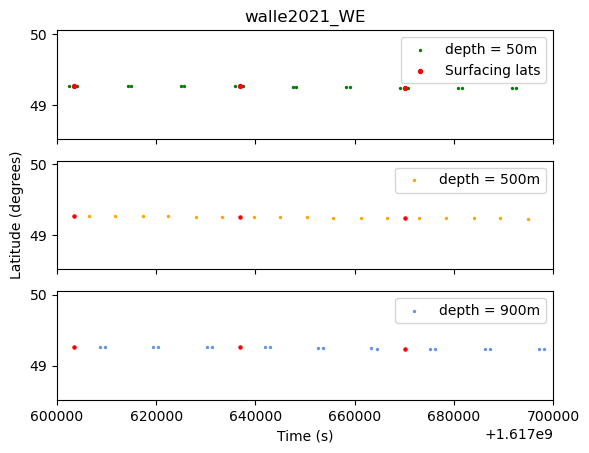

In [53]:
fig, axs = plt.subplots(3,1,sharex=True)

axs[0].scatter(section.time_1970[50,:],section.new_lats[50], c='green',marker='o' , s=2,label='depth = 50m')
axs[0].scatter(true_times,true_lats, marker='o', s=8, label = 'Surfacing lats', c='red')


axs[1].scatter(section.time_1970[500,:],section.new_lats[500], c='orange',marker='o' ,s=2, label='depth = 500m')
axs[1]. scatter(true_times,true_lats, marker='o', s=5,c='red')

axs[2].scatter(section.time_1970[900,:],section.new_lats[900], c='cornflowerblue',marker='o' ,s=2, label='depth = 900m')
axs[2]. scatter(true_times,true_lats, marker='o', s=5,c='red')


axs[0].legend(); axs[1].legend(); axs[2].legend()

axs[2].set_xlabel('Time (s)')
axs[1].set_ylabel ('Latitude (degrees)')
plt.xlim(1.6176e9, 1.6177e9)
axs[0].set_title('walle2021_WE')

In [54]:
walle2021_WE1 = section.drop_isel(time=[634,635,636 ])
walle2021_WE2 = walle2021_WE1.drop_isel(time=[625  ])


In [55]:
walle2021_WE2.to_netcdf(dist_path+'walle2021_WE_corrected_dist.nc')

In [56]:
##### fine grid
ds = xr.open_dataset(dist_path+'walle2021_WE_corrected_dist.nc')
interpolate_even_dist(ds ,'walle2021_WE.nc', 'WE')

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

/opt/anaconda3/envs/eos431/lib/python3.12/site-packages/xarray/core/nputils.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)
/opt/anaconda3/envs/eos431/lib/python3.12/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Text(0.5, 0.98, 'Walle2021_WE')

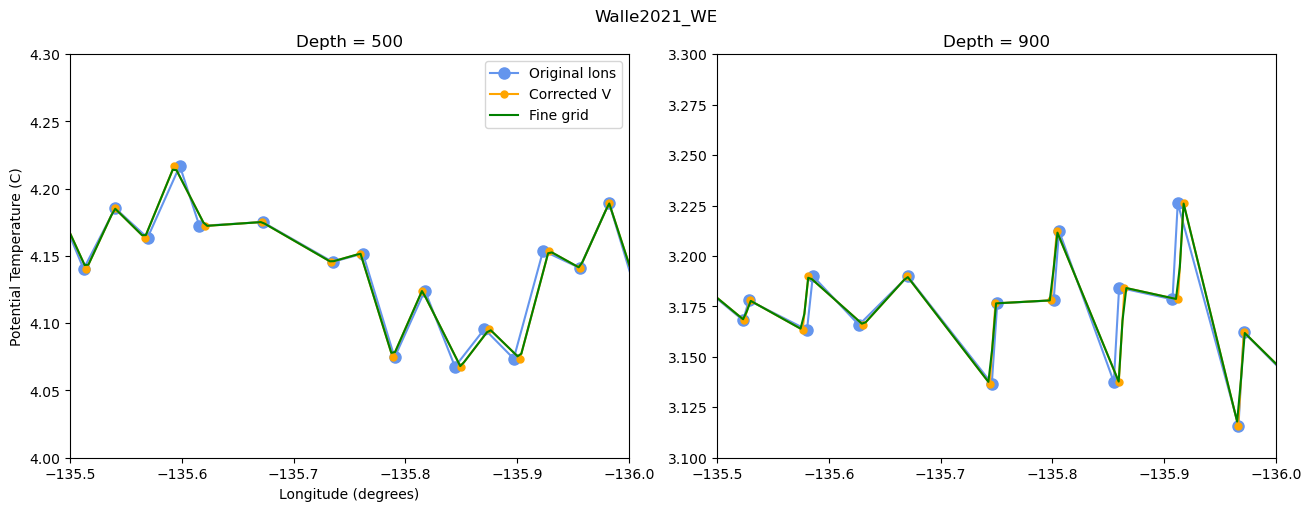

In [57]:
###compare data from original, corrected 'V' and interpolated data 
fig, axs = plt.subplots(1,2, layout='constrained',sharex=True, figsize=(13,5))


axs[0].plot(ds.longitude[500],ds.potential_temperature[500,:], marker='o', markersize=8,label='Original lons', color='cornflowerblue')  #original 
axs[0].plot(ds.new_lons[500],ds.potential_temperature[500,:], marker='o', markersize=5,label='Corrected V ', color='orange')  #original 


walle2021_WE_interp = xr.open_dataset(fine_path + 'walle2021_WE.nc')

axs[0].plot(walle2021_WE_interp.longitude[500,:],walle2021_WE_interp.potential_temperature[500,:], label ='Fine grid', color='green')  #interpolated
axs[0].set_ylim(4,4.3)

####

axs[1].plot(ds.longitude[900],ds.potential_temperature[900,:], marker='o', markersize=8,label='Original lons', color='cornflowerblue')  #original 
axs[1].plot(ds.new_lons[900],ds.potential_temperature[900,:], marker='o', markersize=5,label='Corrected V ', color='orange')  #original 
axs[1].plot(walle2021_WE_interp.longitude[900,:],walle2021_WE_interp.potential_temperature[900,:], label ='Fine grid', color='green')  #interpolated
axs[1].set_ylim(3.1,3.3)



axs[0].set_xlim(-135.5,-136)
axs[0].set_title('Depth = 500')
axs[1].set_title('Depth = 900')



axs[0].set_ylabel('Potential Temperature (C)')
axs[0].set_xlabel('Longitude (degrees)')
axs[0].legend()
fig.suptitle('Walle2021_WE')

/var/folders/4f/2tlph0394xl3ljq0c7zz4t380000gn/T/ipykernel_26171/742071188.py:5: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.
  axs[0].pcolor(ds.longitude[:,:],-ds.depth,ds.potential_temperature, cmap=cmap, vmin=vmin, vmax=vmax)
/var/folders/4f/2tlph0394xl3ljq0c7zz4t380000gn/T/ipykernel_26171/742071188.py:6: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.
  axs[1].pcolor(ds.new_lons[:,:],-ds.depth,ds.potential_temperature,cmap=cmap, vmin=vmin, vmax=vmax)
/var/folders/4f/2tlph0394xl3ljq0c7zz4t380000gn/T/ipykernel_26171/742071188.py:7: UserWarning: The input coordinates to pcolor are interpreted as cell 

Text(0.5, 0.98, 'walle2021_WE')

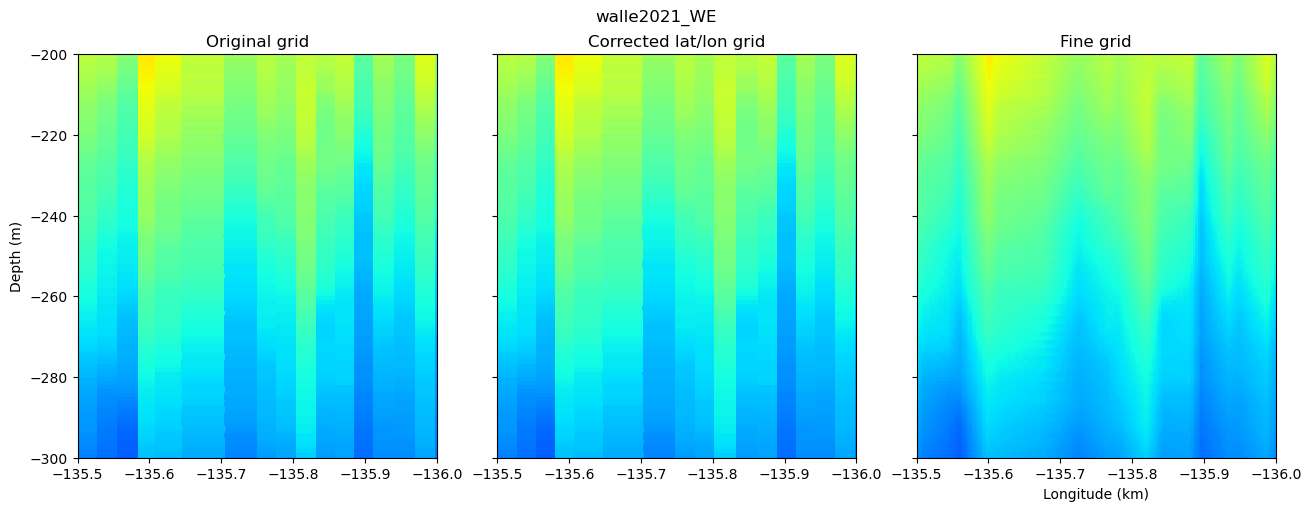

In [289]:
fig, axs = plt.subplots(1,3, layout='constrained',sharey=True,sharex=True, figsize=(13,5))

cmap='jet'; vmin=4; vmax=7

axs[0].pcolor(ds.longitude[:,:],-ds.depth,ds.potential_temperature, cmap=cmap, vmin=vmin, vmax=vmax)
axs[1].pcolor(ds.new_lons[:,:],-ds.depth,ds.potential_temperature,cmap=cmap, vmin=vmin, vmax=vmax)
axs[2].pcolor(walle2021_WE_interp.longitude,-walle2021_WE_interp.depth,walle2021_WE_interp.potential_temperature,cmap=cmap, vmin=vmin, vmax=vmax)

axs[0].set_xlim(-135.5,-136)
axs[0].set_ylim(-300, -200)

axs[2].set_xlabel('Longitude (km)')
axs[0]. set_ylabel('Depth (m)')

axs[0].set_title('Original grid')
axs[1].set_title('Corrected lat/lon grid')
axs[2].set_title('Fine grid')
fig.suptitle('walle2021_WE') 

# Rosie2022

/var/folders/4f/2tlph0394xl3ljq0c7zz4t380000gn/T/ipykernel_5867/764381857.py:5: UserWarning: Converting non-nanosecond precision timedelta values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  rosie2022['gridded_time']= rosie2022.time_1970.astype('timedelta64[s]') + np.datetime64('1970-01-01T00:00:00')


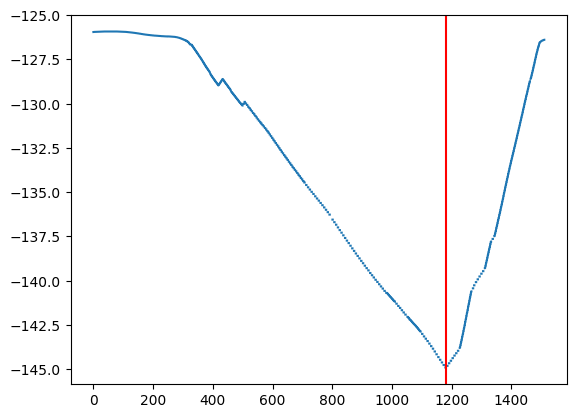

In [10]:
with xr.open_dataset(path+files[3]) as rosie2022:
    x = np.linspace(0, len(rosie2022.time), len(rosie2022.time))
    plt.plot(x, rosie2022.longitude[0,:])
    plt.axvline(x=1180, c='red')
    rosie2022['gridded_time']= rosie2022.time_1970.astype('timedelta64[s]') + np.datetime64('1970-01-01T00:00:00') 

    rosie2022_EW = rosie2022.isel(time=range(0,1180,1))
    rosie2022_WE = rosie2022.isel(time=range(1180,len(rosie2022.time),1))
    

In [59]:
section = rosie2022_EW
    
true_lons = np.empty(len(section.time))
true_lons[:] = np.nan  
####
true_lats = np.empty(len(section.time))
true_lats[:] = np.nan  

####
true_times = np.empty(len(section.time))
true_times[:] = np.nan  

for i in range(len(section.time)-1): 
    if section.profile_direction[0,i] == -1: #if ascending 
        distance_difference = np.abs(section.gridded_time[0,i+1] - section.gridded_time[0,i]) 
        time_difference = np.abs(section.gridded_time[0,i] - section.gridded_time[1,i]) 

        if time_difference >=  (np.array(37100000000)).astype('timedelta64[ns]'): #25 seconds  
            true_lats[i] = (section.latitude[0,i].values) #lat coordinate
            true_lons[i]= (section.longitude[0,i].values) #lon coordinate 
            true_times[i] = (section.gridded_time[0,i].values.astype(np.float64)/1e9 )

        elif distance_difference >=  100000000000: #consecutive profiles are 0.02 degrees longtiude apart
            true_lats[i] = (section.latitude[0,i+1].values) #lat coordinate
            true_lons[i] = (section.longitude[0,i+1].values) #lon coordinate 
            true_times[i] = (section.gridded_time[0,i+1].values.astype(np.float64)/1e9 )

        else:
            true_lats[i] = np.nan #lat coordinate
            true_lons[i] = np.nan #lon coordinate 
            true_times[i] = np.nan
    
    elif (np.isnan(section.time_1970[0,i] ) and ~np.isnan(section.time_1970[0,i+1] )):
        true_lats[i] = (section.latitude[0,i+1].values) #lat coordinate
        true_lons[i] = (section.longitude[0,i+1].values) #lon coordinate 
        true_times[i] = (section.gridded_time[0,i+1].values.astype(np.float64)/1e9 )
            
            

    else:
        true_lats[i] = np.nan #lat coordinate
        true_lons[i] = np.nan #lon coordinate 
        true_times[i] = np.nan

true_lats = true_lats[~np.isnan(true_times)]
true_lons = true_lons[~np.isnan(true_times)]
true_times = true_times[~np.isnan(true_times)]     



section['new_lons'] = (('depth','time'), np.where(np.isnan(section.potential_temperature), np.nan, np.nan))
section['new_lats'] = (('depth','time'), np.where(np.isnan(section.potential_temperature), np.nan, np.nan))


##########interpolate surface 

good_indx = ~np.isnan(section.time_1970[0,:])
sfc_time = section.time_1970[0,good_indx] 

#######
sfc_lons = np.interp(sfc_time,true_times, true_lons)
section.new_lons[0,good_indx] = sfc_lons

sfc_lats = np.interp(sfc_time, true_times ,true_lats)
section.new_lats[0,good_indx] = sfc_lats


################ interpolate other depths 
for i in range(1,len(section.depth)):
    good_indx = ~(np.isnan(section.time_1970[i,:])  )
    new_x = section.time_1970[i,good_indx]

    if len(new_x) > 0: 
        section.new_lons[i,good_indx] = np.interp(new_x,true_times, true_lons)
        section.new_lats[i,good_indx] = np.interp(new_x,true_times, true_lats)


Text(0.5, 1.0, 'rosie2022_EW')

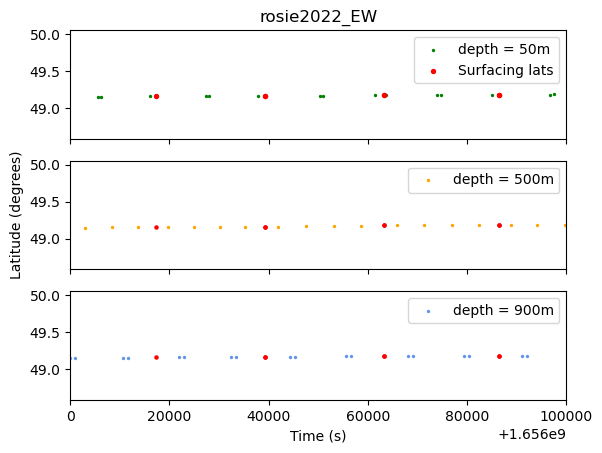

In [60]:
fig, axs = plt.subplots(3,1,sharex=True)

axs[0].scatter(section.time_1970[50,:],section.new_lats[50], c='green',marker='o' , s=2,label='depth = 50m')
axs[0].scatter(true_times,true_lats, marker='o', s=8, label = 'Surfacing lats', c='red')


axs[1].scatter(section.time_1970[500,:],section.new_lats[500], c='orange',marker='o' ,s=2, label='depth = 500m')
axs[1]. scatter(true_times,true_lats, marker='o', s=5,c='red')

axs[2].scatter(section.time_1970[900,:],section.new_lats[900], c='cornflowerblue',marker='o' ,s=2, label='depth = 900m')
axs[2]. scatter(true_times,true_lats, marker='o', s=5,c='red')


axs[0].legend(); axs[1].legend(); axs[2].legend()

axs[2].set_xlabel('Time (s)')
axs[1].set_ylabel ('Latitude (degrees)')
axs[1].set_xlim(1.656e9, 1.6561e9)
axs[0].set_title('rosie2022_EW')

Text(0.5, 1.0, 'rosie2022_EW')

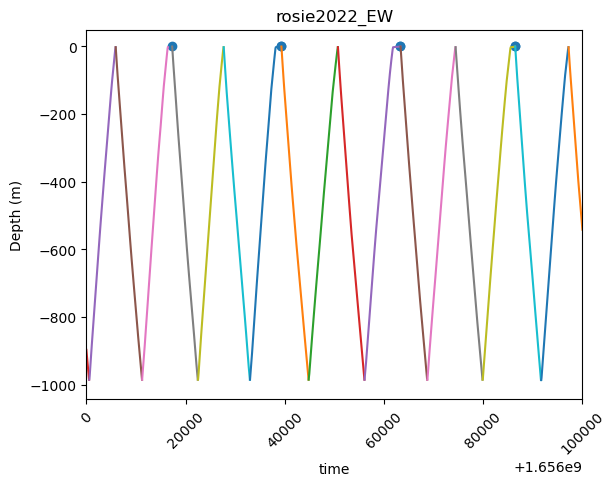

In [168]:
plt.plot(rosie2022_EW.time_1970,-rosie2022_EW.depth )
plt.scatter((true_times)  , np.linspace(0,0,len(true_times)))
plt.xticks(rotation=45)
plt.ylabel('Depth (m)')
plt.xlabel('time')
 
#plt.xlim((walle2019_dec_WE.gridded_time[0,583]),walle2019_dec_WE.gridded_time[0,595])
plt.xlim(1.656e9, 1.6561e9)
plt.title('rosie2022_EW')

In [61]:
dist_noise(section)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [62]:
rosie2022_EW1 = section.drop_isel(time=[ 1052,1056,1058,1059,1060,1061 ])
rosie2022_EW2 = rosie2022_EW1.drop_isel(time=[ 981,982 ])


In [63]:
rosie2022_EW2.to_netcdf(dist_path+'rosie2022_EW_corrected_dist.nc')

In [64]:
##### fine grid
ds = xr.open_dataset(dist_path+'rosie2022_EW_corrected_dist.nc')
interpolate_even_dist(ds ,'rosie2022_EW.nc', 'EW')

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

/opt/anaconda3/envs/eos431/lib/python3.12/site-packages/xarray/core/nputils.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)
/opt/anaconda3/envs/eos431/lib/python3.12/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Text(0.5, 0.98, 'Rosie2022_EW')

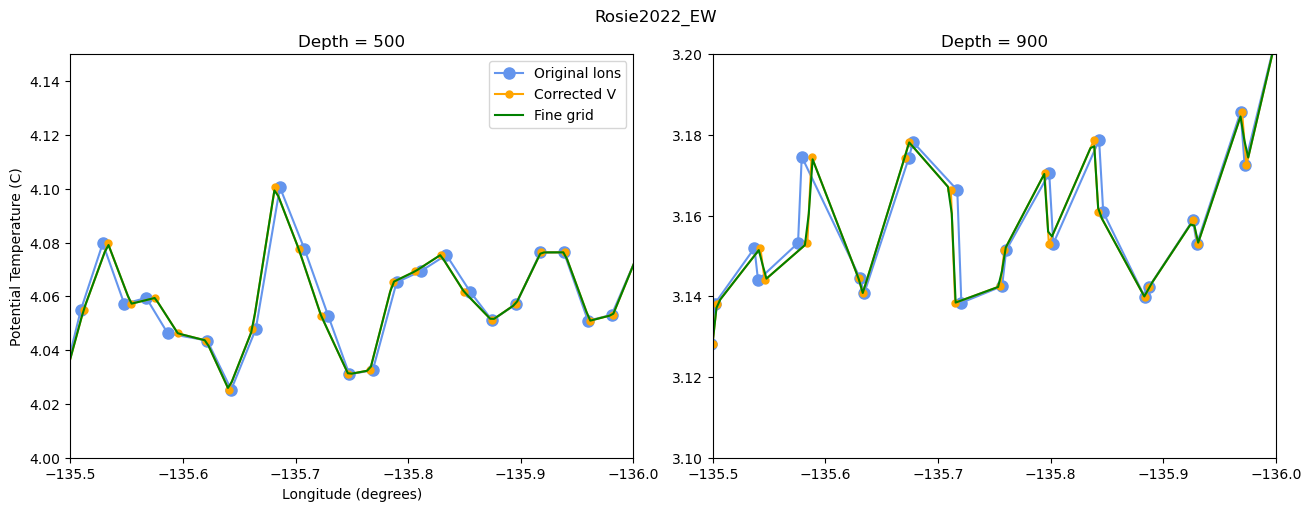

In [65]:
###compare data from original, corrected 'V' and interpolated data 
fig, axs = plt.subplots(1,2, layout='constrained',sharex=True, figsize=(13,5))


axs[0].plot(ds.longitude[500],ds.potential_temperature[500,:], marker='o', markersize=8,label='Original lons', color='cornflowerblue')  #original 
axs[0].plot(ds.new_lons[500],ds.potential_temperature[500,:], marker='o', markersize=5,label='Corrected V ', color='orange')  #original 


rosie2022_EW_interp = xr.open_dataset(fine_path + 'rosie2022_EW.nc')

axs[0].plot(rosie2022_EW_interp.longitude[500,:],rosie2022_EW_interp.potential_temperature[500,:], label ='Fine grid', color='green')  #interpolated
axs[0].set_ylim(4,4.15)

####

axs[1].plot(ds.longitude[900],ds.potential_temperature[900,:], marker='o', markersize=8,label='Original lons', color='cornflowerblue')  #original 
axs[1].plot(ds.new_lons[900],ds.potential_temperature[900,:], marker='o', markersize=5,label='Corrected V ', color='orange')  #original 
axs[1].plot(rosie2022_EW_interp.longitude[900,:],rosie2022_EW_interp.potential_temperature[900,:], label ='Fine grid', color='green')  #interpolated
axs[1].set_ylim(3.1,3.2)



axs[0].set_xlim(-135.5,-136)
axs[0].set_title('Depth = 500')
axs[1].set_title('Depth = 900')



axs[0].set_ylabel('Potential Temperature (C)')
axs[0].set_xlabel('Longitude (degrees)')
axs[0].legend()
fig.suptitle('Rosie2022_EW')

/var/folders/4f/2tlph0394xl3ljq0c7zz4t380000gn/T/ipykernel_26171/602986765.py:5: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.
  axs[0].pcolor(rosie2022_EW.longitude[:,:],-rosie2022_EW.depth,rosie2022_EW.potential_temperature, cmap=cmap, vmin=vmin, vmax=vmax)
/var/folders/4f/2tlph0394xl3ljq0c7zz4t380000gn/T/ipykernel_26171/602986765.py:6: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.
  axs[1].pcolor(rosie2022_EW.new_lons[:,:],-rosie2022_EW.depth,rosie2022_EW.potential_temperature,cmap=cmap, vmin=vmin, vmax=vmax)
/var/folders/4f/2tlph0394xl3ljq0c7zz4t380000gn/T/ipykernel_26171/602986765.py:7: UserWarni

Text(0.5, 0.98, 'Rosie2022_EW')

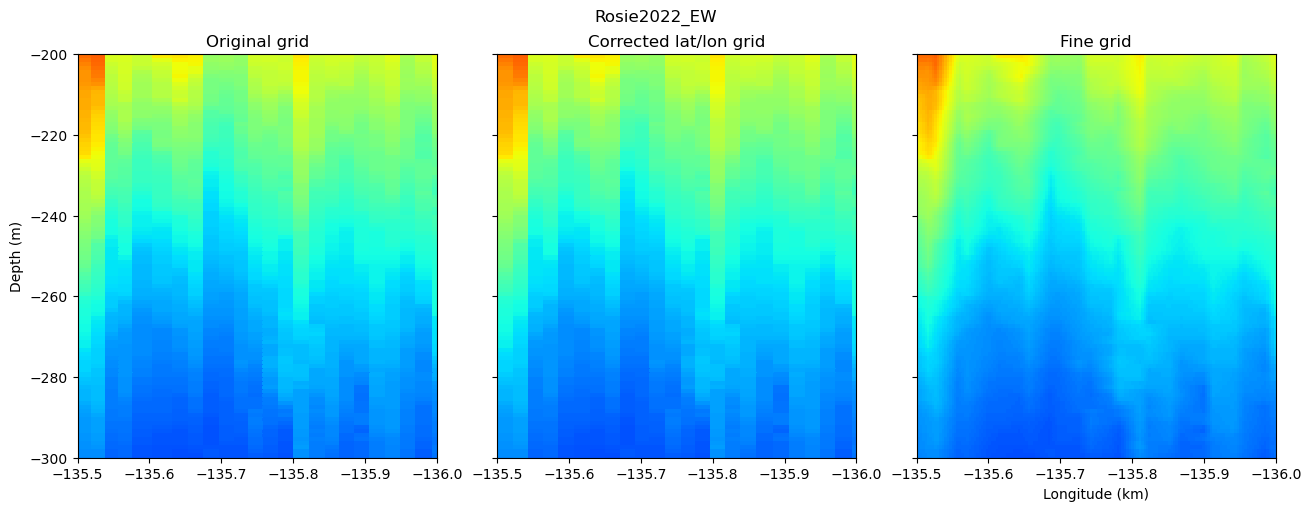

In [282]:
fig, axs = plt.subplots(1,3, layout='constrained',sharey=True,sharex=True, figsize=(13,5))

cmap='jet'; vmin=4; vmax=6

axs[0].pcolor(rosie2022_EW.longitude[:,:],-rosie2022_EW.depth,rosie2022_EW.potential_temperature, cmap=cmap, vmin=vmin, vmax=vmax)
axs[1].pcolor(rosie2022_EW.new_lons[:,:],-rosie2022_EW.depth,rosie2022_EW.potential_temperature,cmap=cmap, vmin=vmin, vmax=vmax)
axs[2].pcolor(rosie2022_EW_interp.longitude,-rosie2022_EW_interp.depth,rosie2022_EW_interp.potential_temperature,cmap=cmap, vmin=vmin, vmax=vmax)

axs[0].set_xlim(-135.5,-136)
axs[0].set_ylim(-300, -200)

axs[2].set_xlabel('Longitude (km)')
axs[0]. set_ylabel('Depth (m)')

axs[0].set_title('Original grid')
axs[1].set_title('Corrected lat/lon grid')
axs[2].set_title('Fine grid')
fig.suptitle('Rosie2022_EW') 

WE




In [66]:
section = rosie2022_WE
    
true_lons = np.empty(len(section.time))
true_lons[:] = np.nan  
####
true_lats = np.empty(len(section.time))
true_lats[:] = np.nan  

####
true_times = np.empty(len(section.time))
true_times[:] = np.nan  

for i in range(len(section.time)-1): 
    if section.profile_direction[0,i] == -1: #if ascending 
        distance_difference = np.abs(section.gridded_time[0,i+1] - section.gridded_time[0,i]) 
        time_difference = np.abs(section.gridded_time[0,i] - section.gridded_time[1,i]) 

        if time_difference >=  (np.array(37100000000)).astype('timedelta64[ns]'): #25 seconds  
            true_lats[i] = (section.latitude[0,i].values) #lat coordinate
            true_lons[i]= (section.longitude[0,i].values) #lon coordinate 
            true_times[i] = (section.gridded_time[0,i].values.astype(np.float64)/1e9 )

        elif distance_difference >=  100000000000: #consecutive profiles are 0.02 degrees longtiude apart
            true_lats[i] = (section.latitude[0,i+1].values) #lat coordinate
            true_lons[i] = (section.longitude[0,i+1].values) #lon coordinate 
            true_times[i] = (section.gridded_time[0,i+1].values.astype(np.float64)/1e9 )
        else:
            true_lats[i] = np.nan #lat coordinate
            true_lons[i] = np.nan #lon coordinate 
            true_times[i] = np.nan
    else:
        true_lats[i] = np.nan #lat coordinate
        true_lons[i] = np.nan #lon coordinate 
        true_times[i] = np.nan

true_lats = true_lats[~np.isnan(true_times)]
true_lons = true_lons[~np.isnan(true_times)]
true_times = true_times[~np.isnan(true_times)]     



section['new_lons'] = (('depth','time'), np.where(np.isnan(section.potential_temperature), np.nan, np.nan))
section['new_lats'] = (('depth','time'), np.where(np.isnan(section.potential_temperature), np.nan, np.nan))


##########interpolate surface 

good_indx = ~np.isnan(section.time_1970[0,:])
sfc_time = section.time_1970[0,good_indx] 

#######
sfc_lons = np.interp(sfc_time,true_times, true_lons)
section.new_lons[0,good_indx] = sfc_lons

sfc_lats = np.interp(sfc_time, true_times ,true_lats)
section.new_lats[0,good_indx] = sfc_lats


################ interpolate other depths 
for i in range(1,len(section.depth)):
    good_indx = ~(np.isnan(section.time_1970[i,:])  )
    new_x = section.time_1970[i,good_indx]

    if len(new_x) > 0: 
        section.new_lons[i,good_indx] = np.interp(new_x,true_times, true_lons)
        section.new_lats[i,good_indx] = np.interp(new_x,true_times, true_lats)


Text(0.5, 1.0, 'rosie2022_WE')

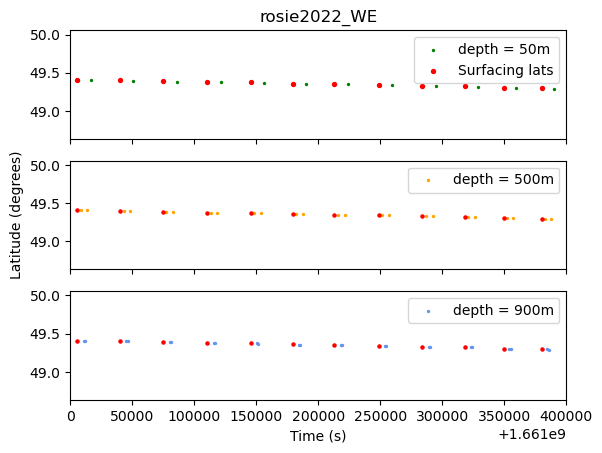

In [67]:
fig, axs = plt.subplots(3,1,sharex=True)

axs[0].scatter(section.time_1970[50,:],section.new_lats[50], c='green',marker='o' , s=2,label='depth = 50m')
axs[0].scatter(true_times,true_lats, marker='o', s=8, label = 'Surfacing lats', c='red')


axs[1].scatter(section.time_1970[500,:],section.new_lats[500], c='orange',marker='o' ,s=2, label='depth = 500m')
axs[1]. scatter(true_times,true_lats, marker='o', s=5,c='red')

axs[2].scatter(section.time_1970[900,:],section.new_lats[900], c='cornflowerblue',marker='o' ,s=2, label='depth = 900m')
axs[2]. scatter(true_times,true_lats, marker='o', s=5,c='red')


axs[0].legend(); axs[1].legend(); axs[2].legend()

axs[2].set_xlabel('Time (s)')
axs[1].set_ylabel ('Latitude (degrees)')
axs[1].set_xlim(1.661e9, 1.6614e9)
axs[0].set_title('rosie2022_WE')

Text(0.5, 1.0, 'rosie2022_WE')

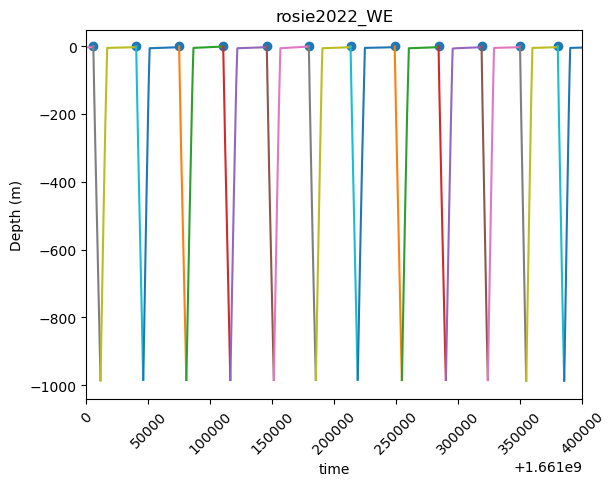

In [158]:
plt.plot(rosie2022_WE.time_1970,-rosie2022_WE.depth )
plt.scatter((true_times)  , np.linspace(0,0,len(true_times)))
plt.xticks(rotation=45)
plt.ylabel('Depth (m)')
plt.xlabel('time')
 
#plt.xlim((walle2019_dec_WE.gridded_time[0,583]),walle2019_dec_WE.gridded_time[0,595])
plt.xlim(1.661e9, 1.6614e9)
plt.title('rosie2022_WE')

In [68]:
dist_noise(section)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [69]:
section.to_netcdf(dist_path+'rosie2022_WE_corrected_dist.nc')

In [70]:
##### fine grid
ds = xr.open_dataset(dist_path+'rosie2022_WE_corrected_dist.nc')
interpolate_even_dist(ds ,'rosie2022_WE.nc', 'WE')

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

/opt/anaconda3/envs/eos431/lib/python3.12/site-packages/xarray/core/nputils.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)
/opt/anaconda3/envs/eos431/lib/python3.12/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Text(0.5, 0.98, 'Rosie2022_WE')

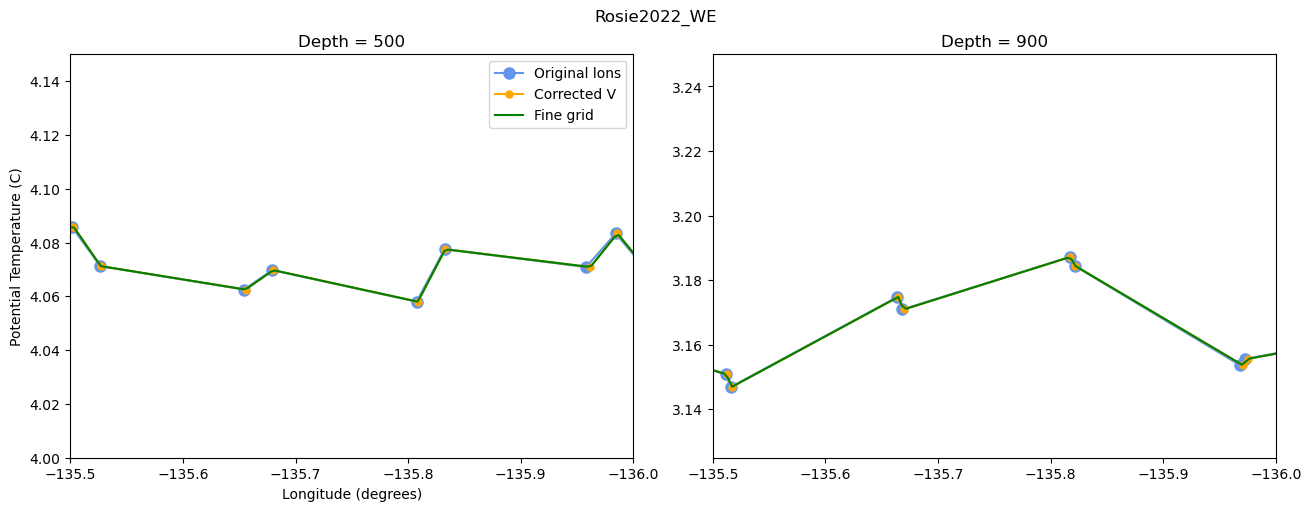

In [71]:
###compare data from original, corrected 'V' and interpolated data 
fig, axs = plt.subplots(1,2, layout='constrained',sharex=True, figsize=(13,5))


axs[0].plot(ds.longitude[500],ds.potential_temperature[500,:], marker='o', markersize=8,label='Original lons', color='cornflowerblue')  #original 
axs[0].plot(ds.new_lons[500],ds.potential_temperature[500,:], marker='o', markersize=5,label='Corrected V ', color='orange')  #original 


rosie2022_WE_interp = xr.open_dataset(fine_path + 'rosie2022_WE.nc')

axs[0].plot(rosie2022_WE_interp.longitude[500,:],rosie2022_WE_interp.potential_temperature[500,:], label ='Fine grid', color='green')  #interpolated
axs[0].set_ylim(4,4.15)

####

axs[1].plot(ds.longitude[900],ds.potential_temperature[900,:], marker='o', markersize=8,label='Original lons', color='cornflowerblue')  #original 
axs[1].plot(ds.new_lons[900],ds.potential_temperature[900,:], marker='o', markersize=5,label='Corrected V ', color='orange')  #original 
axs[1].plot(rosie2022_WE_interp.longitude[900,:],rosie2022_WE_interp.potential_temperature[900,:], label ='Fine grid', color='green')  #interpolated
axs[1].set_ylim(3.125,3.25)



axs[0].set_xlim(-135.5,-136)
axs[0].set_title('Depth = 500')
axs[1].set_title('Depth = 900')



axs[0].set_ylabel('Potential Temperature (C)')
axs[0].set_xlabel('Longitude (degrees)')
axs[0].legend()
fig.suptitle('Rosie2022_WE')

/var/folders/4f/2tlph0394xl3ljq0c7zz4t380000gn/T/ipykernel_26171/4018501645.py:5: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.
  axs[0].pcolor(rosie2022_WE.longitude[:,:],-rosie2022_WE.depth,rosie2022_WE.potential_temperature, cmap=cmap, vmin=vmin, vmax=vmax)
/var/folders/4f/2tlph0394xl3ljq0c7zz4t380000gn/T/ipykernel_26171/4018501645.py:6: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.
  axs[1].pcolor(rosie2022_WE.new_lons[:,:],-rosie2022_WE.depth,rosie2022_WE.potential_temperature,cmap=cmap, vmin=vmin, vmax=vmax)
/var/folders/4f/2tlph0394xl3ljq0c7zz4t380000gn/T/ipykernel_26171/4018501645.py:7: UserWa

Text(0.5, 0.98, 'Rosie2022_WE')

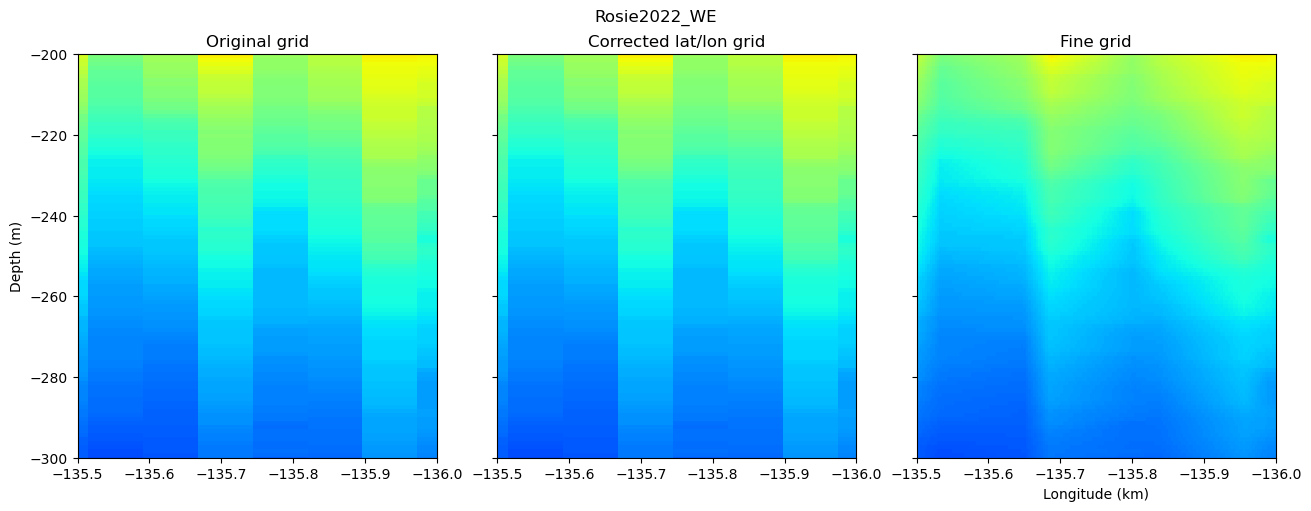

In [279]:
fig, axs = plt.subplots(1,3, layout='constrained',sharey=True,sharex=True, figsize=(13,5))

cmap='jet'; vmin=4; vmax=6

axs[0].pcolor(rosie2022_WE.longitude[:,:],-rosie2022_WE.depth,rosie2022_WE.potential_temperature, cmap=cmap, vmin=vmin, vmax=vmax)
axs[1].pcolor(rosie2022_WE.new_lons[:,:],-rosie2022_WE.depth,rosie2022_WE.potential_temperature,cmap=cmap, vmin=vmin, vmax=vmax)
axs[2].pcolor(rosie2022_WE_interp.longitude,-rosie2022_WE_interp.depth,rosie2022_WE_interp.potential_temperature,cmap=cmap, vmin=vmin, vmax=vmax)

axs[0].set_xlim(-135.5,-136)
axs[0].set_ylim(-300, -200)

axs[2].set_xlabel('Longitude (km)')
axs[0]. set_ylabel('Depth (m)')

axs[0].set_title('Original grid')
axs[1].set_title('Corrected lat/lon grid')
axs[2].set_title('Fine grid')
fig.suptitle('Rosie2022_WE') 

# Rosie2023

In [2]:
with xr.open_dataset(path+files[4]) as rosie2023:
    x = np.linspace(0, len(rosie2023.time), len(rosie2023.time))
    plt.plot(x, rosie2023.longitude[0,:])

    plt.axvline(x=760, c='red')
    plt.axvline(x=1490, c='red')
    rosie2023['gridded_time']= rosie2023.time_1970.astype('timedelta64[s]') + np.datetime64('1970-01-01T00:00:00') 

    rosie2023_EW = rosie2023.isel(time=range(0,760,1))
    rosie2023_WE = rosie2023.isel(time=range(760,1490,1))


NameError: name 'path' is not defined

In [73]:
section = rosie2023_EW
    
true_lons = np.empty(len(section.time))
true_lons[:] = np.nan  
####
true_lats = np.empty(len(section.time))
true_lats[:] = np.nan  

####
true_times = np.empty(len(section.time))
true_times[:] = np.nan  

for i in range(len(section.time)-1): 
    if section.profile_direction[0,i] == -1: #if ascending 
        distance_difference = np.abs(section.gridded_time[0,i+1] - section.gridded_time[0,i]) 
        time_difference = np.abs(section.gridded_time[0,i] - section.gridded_time[1,i]) 

        if time_difference >=  (np.array(37100000000)).astype('timedelta64[ns]'): #25 seconds  
            true_lats[i] = (section.latitude[0,i].values) #lat coordinate
            true_lons[i]= (section.longitude[0,i].values) #lon coordinate 
            true_times[i] = (section.gridded_time[0,i].values.astype(np.float64)/1e9 )

        elif distance_difference >=  100000000000: #consecutive profiles are 0.02 degrees longtiude apart
            true_lats[i] = (section.latitude[0,i+1].values) #lat coordinate
            true_lons[i] = (section.longitude[0,i+1].values) #lon coordinate 
            true_times[i] = (section.gridded_time[0,i+1].values.astype(np.float64)/1e9 )
        else:
            true_lats[i] = np.nan #lat coordinate
            true_lons[i] = np.nan #lon coordinate 
            true_times[i] = np.nan
    
    elif (np.isnan(section.time_1970[0,i] ) and ~np.isnan(section.time_1970[0,i+1] )):
        true_lats[i] = (section.latitude[0,i+1].values) #lat coordinate
        true_lons[i] = (section.longitude[0,i+1].values) #lon coordinate 
        true_times[i] = (section.gridded_time[0,i+1].values.astype(np.float64)/1e9 )
            
    
    else:
        true_lats[i] = np.nan #lat coordinate
        true_lons[i] = np.nan #lon coordinate 
        true_times[i] = np.nan

true_lats = true_lats[~np.isnan(true_times)]
true_lons = true_lons[~np.isnan(true_times)]
true_times = true_times[~np.isnan(true_times)]     



section['new_lons'] = (('depth','time'), np.where(np.isnan(section.potential_temperature), np.nan, np.nan))
section['new_lats'] = (('depth','time'), np.where(np.isnan(section.potential_temperature), np.nan, np.nan))


##########interpolate surface 

good_indx = ~np.isnan(section.time_1970[0,:])
sfc_time = section.time_1970[0,good_indx] 

#######
sfc_lons = np.interp(sfc_time,true_times, true_lons)
section.new_lons[0,good_indx] = sfc_lons

sfc_lats = np.interp(sfc_time, true_times ,true_lats)
section.new_lats[0,good_indx] = sfc_lats


################ interpolate other depths 
for i in range(1,len(section.depth)):
    good_indx = ~(np.isnan(section.time_1970[i,:])  )
    new_x = section.time_1970[i,good_indx]

    if len(new_x) > 0: 
        section.new_lons[i,good_indx] = np.interp(new_x,true_times, true_lons)
        section.new_lats[i,good_indx] = np.interp(new_x,true_times, true_lats)


239
244
245
250
251


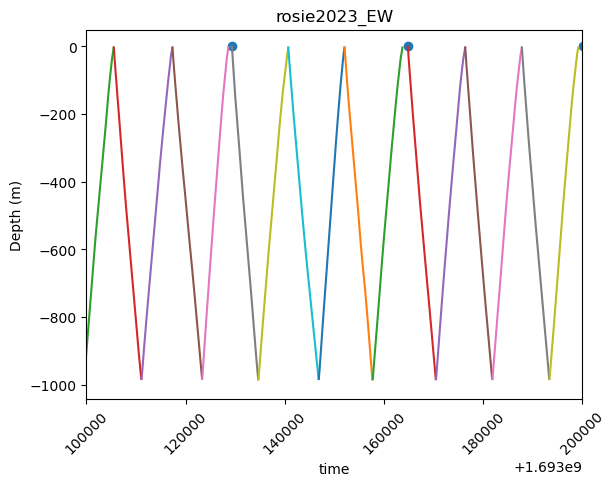

In [154]:
plt.plot(section.time_1970,-section.depth )
plt.scatter((true_times)  , np.linspace(0,0,len(true_times)))
plt.xticks(rotation=45)
plt.ylabel('Depth (m)')
plt.xlabel('time')
 
#plt.xlim((walle2019_dec_WE.gridded_time[0,583]),walle2019_dec_WE.gridded_time[0,595])
plt.xlim(1.6931e9, 1.6932e9)
plt.title('rosie2023_EW')

for i in range(len(section.time)):
    if (section.time_1970[0,i] > 1.693e9 and section.time_1970[0,i] < 1.6931e9):
        print(i)
        


Text(0.5, 1.0, 'rosie2023_EW')

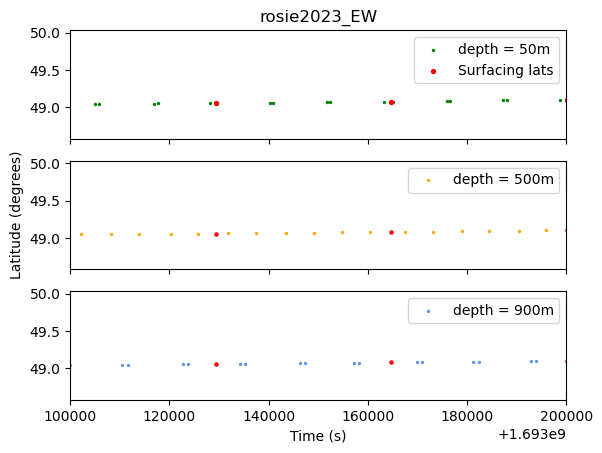

In [135]:
fig, axs = plt.subplots(3,1,sharex=True)

axs[0].scatter(section.time_1970[50,:],section.new_lats[50], c='green',marker='o' , s=2,label='depth = 50m')
axs[0].scatter(true_times,true_lats, marker='o', s=8, label = 'Surfacing lats', c='red')


axs[1].scatter(section.time_1970[500,:],section.new_lats[500], c='orange',marker='o' ,s=2, label='depth = 500m')
axs[1]. scatter(true_times,true_lats, marker='o', s=5,c='red')

axs[2].scatter(section.time_1970[900,:],section.new_lats[900], c='cornflowerblue',marker='o' ,s=2, label='depth = 900m')
axs[2]. scatter(true_times,true_lats, marker='o', s=5,c='red')


axs[0].legend(); axs[1].legend(); axs[2].legend()

axs[2].set_xlabel('Time (s)')
axs[1].set_ylabel ('Latitude (degrees)')
plt.xlim(1.6931e9, 1.6932e9)

axs[0].set_title('rosie2023_EW')

In [74]:
dist_noise(section)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [75]:
### take out bad points 
rosie2023_EW1 = section.drop_isel(time=[181,182,333,334 ,428,429 ])


In [76]:
rosie2023_EW1.to_netcdf(dist_path+'rosie2023_EW_corrected_dist.nc')

In [48]:
ds = xr.open_dataset(dist_path+'rosie2023_EW_corrected_dist.nc')


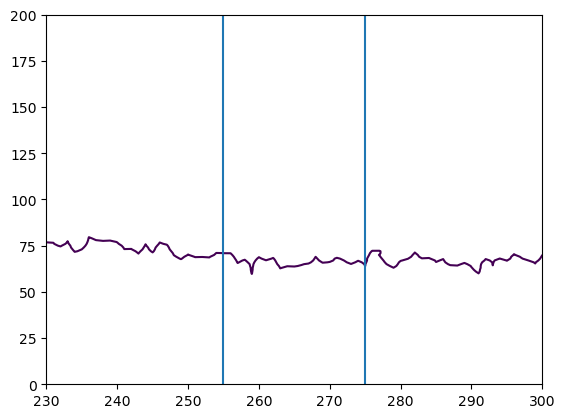

In [60]:
#plt.pcolor(ds.longitude[500,:],ds.depth,ds.potential_temperature)

plt.contour(ds.density, levels=[1025.5])
plt.ylim(0,200)
plt.xlim(230,300)
plt.axvline(255)
plt.axvline(275)

In [52]:
ds =ds.drop_isel(time=[260,261,262,263,264,265,266,267,267,268,269,270,271,272,273,274,275])


In [65]:
ds =ds.drop_isel(time=[257,258,259,260,261])


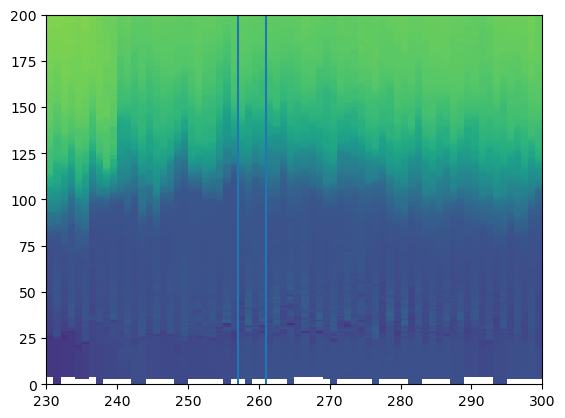

In [66]:
plt.pcolormesh(ds.salinity)
plt.ylim(0,200)
plt.xlim(230,300)
plt.axvline(257)
plt.axvline(261)

In [67]:
ds.to_netcdf(dist_path+'rosie2023_EW_corrected_dist2.nc')

In [68]:
##### fine grid
ds = xr.open_dataset(dist_path+'rosie2023_EW_corrected_dist2.nc')
interpolate_even_dist(ds ,'rosie2023_EW2.nc', 'EW')

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

Text(0.5, 0.98, 'rosie2023_EW')

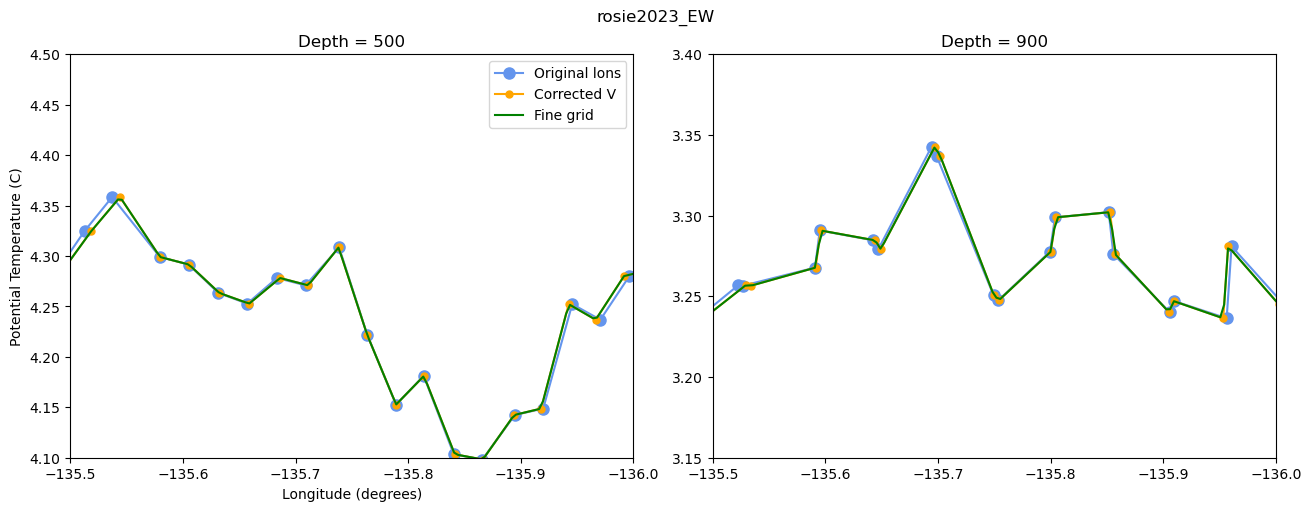

In [221]:
###compare data from original, corrected 'V' and interpolated data 
fig, axs = plt.subplots(1,2, layout='constrained',sharex=True, figsize=(13,5))


axs[0].plot(ds.longitude[500],ds.potential_temperature[500,:], marker='o', markersize=8,label='Original lons', color='cornflowerblue')  #original 
axs[0].plot(ds.new_lons[500],ds.potential_temperature[500,:], marker='o', markersize=5,label='Corrected V ', color='orange')  #original 


rosie2023_EW_interp = xr.open_dataset(fine_path + 'rosie2023_EW2.nc')

axs[0].plot(rosie2023_EW_interp.longitude[500,:],rosie2023_EW_interp.potential_temperature[500,:], label ='Fine grid', color='green')  #interpolated
axs[0].set_ylim(4.1,4.5)

####

axs[1].plot(ds.longitude[900],ds.potential_temperature[900,:], marker='o', markersize=8,label='Original lons', color='cornflowerblue')  #original 
axs[1].plot(ds.new_lons[900],ds.potential_temperature[900,:], marker='o', markersize=5,label='Corrected V ', color='orange')  #original 
axs[1].plot(rosie2023_EW_interp.longitude[900,:],rosie2023_EW_interp.potential_temperature[900,:], label ='Fine grid', color='green')  #interpolated
axs[1].set_ylim(3.15,3.4)



axs[0].set_xlim(-135.5,-136)
axs[0].set_title('Depth = 500')
axs[1].set_title('Depth = 900')



axs[0].set_ylabel('Potential Temperature (C)')
axs[0].set_xlabel('Longitude (degrees)')
axs[0].legend()
fig.suptitle('rosie2023_EW')

/var/folders/4f/2tlph0394xl3ljq0c7zz4t380000gn/T/ipykernel_26171/3457155410.py:5: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.
  axs[0].pcolor(rosie2023_EW.longitude[:,:],-rosie2023_EW.depth,rosie2023_EW.potential_temperature, cmap=cmap, vmin=vmin, vmax=vmax)
/var/folders/4f/2tlph0394xl3ljq0c7zz4t380000gn/T/ipykernel_26171/3457155410.py:6: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.
  axs[1].pcolor(rosie2023_EW.new_lons[:,:],-rosie2023_EW.depth,rosie2023_EW.potential_temperature,cmap=cmap, vmin=vmin, vmax=vmax)
/var/folders/4f/2tlph0394xl3ljq0c7zz4t380000gn/T/ipykernel_26171/3457155410.py:7: UserWa

Text(0.5, 0.98, 'Rosie2023_EW')

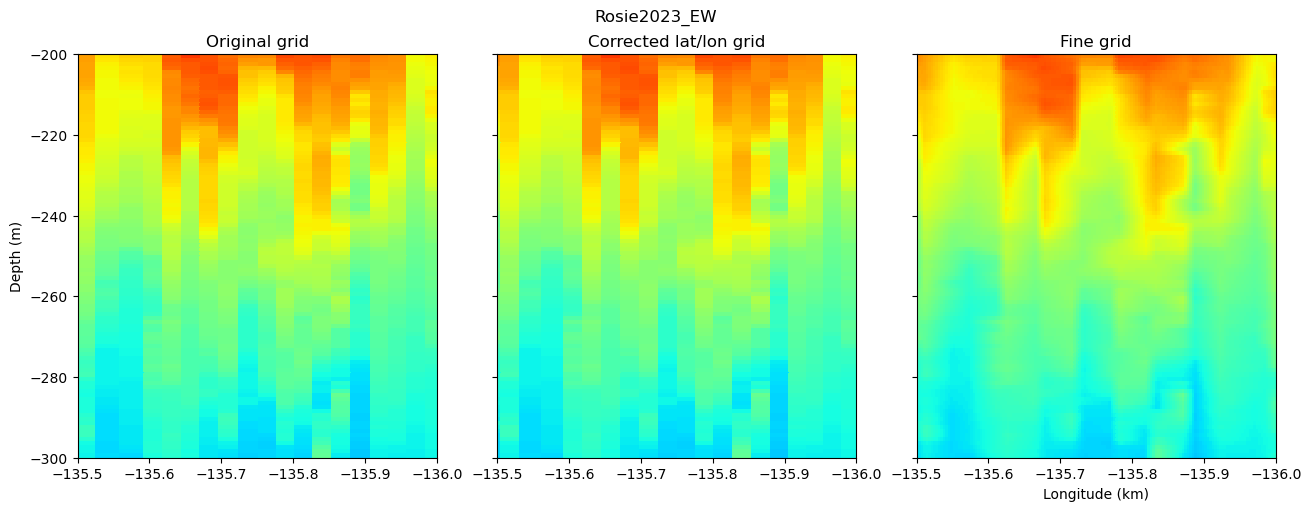

In [222]:
fig, axs = plt.subplots(1,3, layout='constrained',sharey=True,sharex=True, figsize=(13,5))

cmap='jet'; vmin=4; vmax=6

axs[0].pcolor(rosie2023_EW.longitude[:,:],-rosie2023_EW.depth,rosie2023_EW.potential_temperature, cmap=cmap, vmin=vmin, vmax=vmax)
axs[1].pcolor(rosie2023_EW.new_lons[:,:],-rosie2023_EW.depth,rosie2023_EW.potential_temperature,cmap=cmap, vmin=vmin, vmax=vmax)
axs[2].pcolor(rosie2023_EW_interp.longitude,-rosie2023_EW_interp.depth,rosie2023_EW_interp.potential_temperature,cmap=cmap, vmin=vmin, vmax=vmax)

axs[0].set_xlim(-135.5,-136)
axs[0].set_ylim(-300, -200)

axs[2].set_xlabel('Longitude (km)')
axs[0]. set_ylabel('Depth (m)')

axs[0].set_title('Original grid')
axs[1].set_title('Corrected lat/lon grid')
axs[2].set_title('Fine grid')
fig.suptitle('Rosie2023_EW') 

WE

In [78]:
section = rosie2023_WE
    
true_lons = np.empty(len(section.time))
true_lons[:] = np.nan  
####
true_lats = np.empty(len(section.time))
true_lats[:] = np.nan  

####
true_times = np.empty(len(section.time))
true_times[:] = np.nan  

for i in range(len(section.time)-1): 
    if section.profile_direction[0,i] == -1: #if ascending 
        distance_difference = np.abs(section.gridded_time[0,i+1] - section.gridded_time[0,i]) 
        time_difference = np.abs(section.gridded_time[0,i] - section.gridded_time[1,i]) 

        if time_difference >=  (np.array(37100000000)).astype('timedelta64[ns]'): #25 seconds  
            true_lats[i] = (section.latitude[0,i].values) #lat coordinate
            true_lons[i]= (section.longitude[0,i].values) #lon coordinate 
            true_times[i] = (section.gridded_time[0,i].values.astype(np.float64)/1e9 )

        elif distance_difference >=  100000000000: #consecutive profiles are 0.02 degrees longtiude apart
            true_lats[i] = (section.latitude[0,i+1].values) #lat coordinate
            true_lons[i] = (section.longitude[0,i+1].values) #lon coordinate 
            true_times[i] = (section.gridded_time[0,i+1].values.astype(np.float64)/1e9 )
            
        elif (np.isnan(section.time_1970[1,i] ) and ~np.isnan(section.time_1970[0,i+1] )):
            true_lats[i] = (section.latitude[0,i+1].values) #lat coordinate
            true_lons[i] = (section.longitude[0,i+1].values) #lon coordinate 
            true_times[i] = (section.gridded_time[0,i+1].values.astype(np.float64)/1e9 )

        
        else:
            true_lats[i] = np.nan #lat coordinate
            true_lons[i] = np.nan #lon coordinate 
            true_times[i] = np.nan
    
    elif (np.isnan(section.time_1970[1,i] ) and ~np.isnan(section.time_1970[0,i+1] )):
        true_lats[i] = (section.latitude[0,i+1].values) #lat coordinate
        true_lons[i] = (section.longitude[0,i+1].values) #lon coordinate 
        true_times[i] = (section.gridded_time[0,i+1].values.astype(np.float64)/1e9 )
            
    
    else:
        true_lats[i] = np.nan #lat coordinate
        true_lons[i] = np.nan #lon coordinate 
        true_times[i] = np.nan

true_lats = true_lats[~np.isnan(true_times)]
true_lons = true_lons[~np.isnan(true_times)]
true_times = true_times[~np.isnan(true_times)]     



section['new_lons'] = (('depth','time'), np.where(np.isnan(section.potential_temperature), np.nan, np.nan))
section['new_lats'] = (('depth','time'), np.where(np.isnan(section.potential_temperature), np.nan, np.nan))


##########interpolate surface 

good_indx = ~np.isnan(section.time_1970[0,:])
sfc_time = section.time_1970[0,good_indx] 

#######
sfc_lons = np.interp(sfc_time,true_times, true_lons)
section.new_lons[0,good_indx] = sfc_lons

sfc_lats = np.interp(sfc_time, true_times ,true_lats)
section.new_lats[0,good_indx] = sfc_lats


################ interpolate other depths 
for i in range(1,len(section.depth)):
    good_indx = ~(np.isnan(section.time_1970[i,:])  )
    new_x = section.time_1970[i,good_indx]

    if len(new_x) > 0: 
        section.new_lons[i,good_indx] = np.interp(new_x,true_times, true_lons)
        section.new_lats[i,good_indx] = np.interp(new_x,true_times, true_lats)


435
437
439
441
443
445
449
451
453


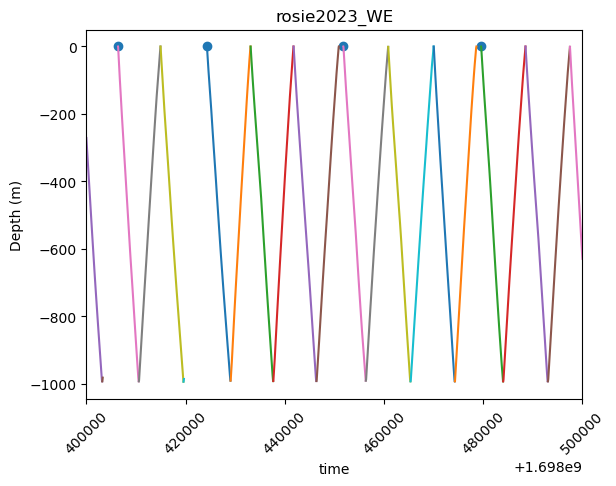

In [79]:
plt.plot(section.time_1970,-section.depth )
plt.scatter((true_times)  , np.linspace(0,0,len(true_times)))
plt.xticks(rotation=45)
plt.ylabel('Depth (m)')
plt.xlabel('time')
 
#plt.axvline(section.time_1970[0,60])
#plt.xlim((walle2019_dec_WE.gridded_time[0,583]),walle2019_dec_WE.gridded_time[0,595])
plt.xlim(1.6984e9, 1.6985e9)
plt.title('rosie2023_WE')

for i in range(len(section.time)):
    if (section.time_1970[0,i] >1.6984e9 and section.time_1970[0,i] < 1.6985e9):
        if section.profile_direction[0,i] == -1: #if ascending 

            print(i)

Text(0.5, 1.0, 'rosie2023_WE')

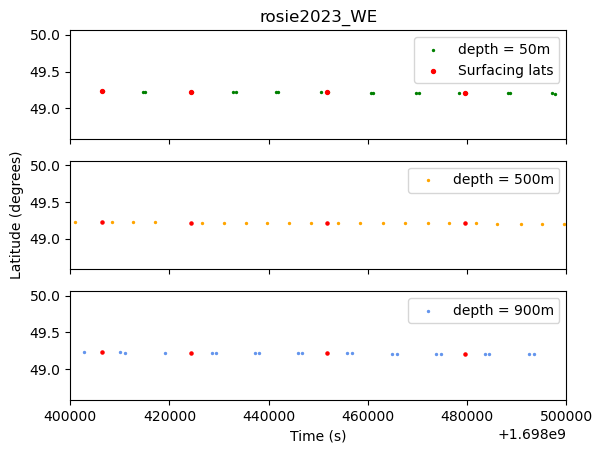

In [271]:
fig, axs = plt.subplots(3,1,sharex=True)

axs[0].scatter(section.time_1970[50,:],section.new_lats[50], c='green',marker='o' , s=2,label='depth = 50m')
axs[0].scatter(true_times,true_lats, marker='o', s=8, label = 'Surfacing lats', c='red')


axs[1].scatter(section.time_1970[500,:],section.new_lats[500], c='orange',marker='o' ,s=2, label='depth = 500m')
axs[1]. scatter(true_times,true_lats, marker='o', s=5,c='red')

axs[2].scatter(section.time_1970[900,:],section.new_lats[900], c='cornflowerblue',marker='o' ,s=2, label='depth = 900m')
axs[2]. scatter(true_times,true_lats, marker='o', s=5,c='red')


axs[0].legend(); axs[1].legend(); axs[2].legend()

axs[2].set_xlabel('Time (s)')
axs[1].set_ylabel ('Latitude (degrees)')
plt.xlim(1.6984e9, 1.6985e9)

axs[0].set_title('rosie2023_WE')

In [80]:
dist_noise(section)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [81]:
section.to_netcdf(dist_path+'rosie2023_WE_corrected_dist.nc')

In [82]:
##### fine grid
ds = xr.open_dataset(dist_path+'rosie2023_WE_corrected_dist.nc')
interpolate_even_dist(ds ,'rosie2023_WE.nc', 'WE')

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

/opt/anaconda3/envs/eos431/lib/python3.12/site-packages/xarray/core/nputils.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)
/opt/anaconda3/envs/eos431/lib/python3.12/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Text(0.5, 0.98, 'rosie2023_WE')

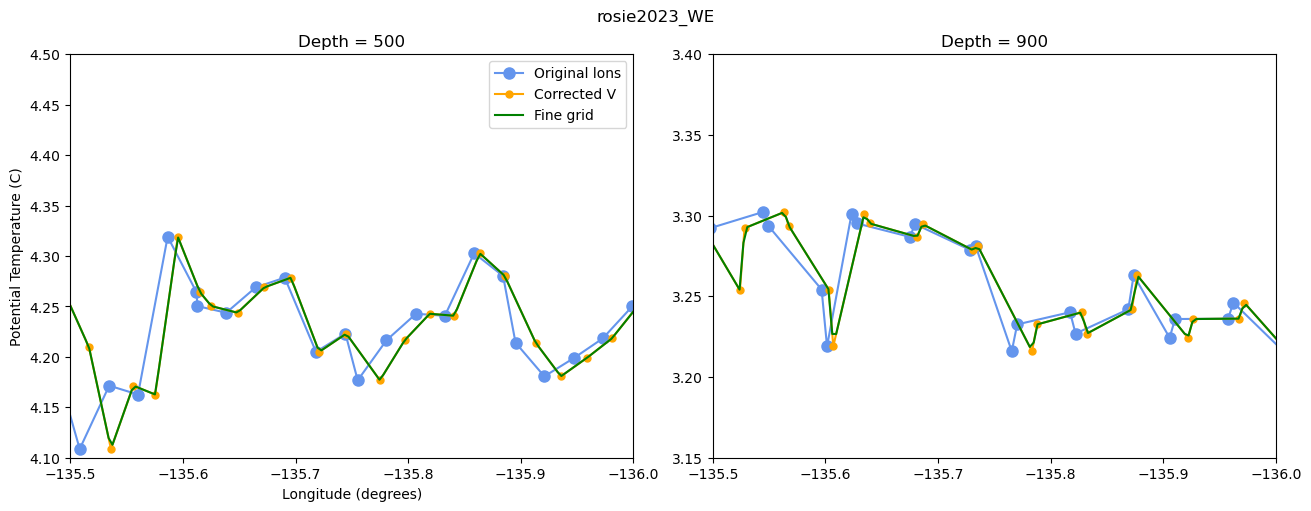

In [83]:
###compare data from original, corrected 'V' and interpolated data 
fig, axs = plt.subplots(1,2, layout='constrained',sharex=True, figsize=(13,5))


axs[0].plot(ds.longitude[500],ds.potential_temperature[500,:], marker='o', markersize=8,label='Original lons', color='cornflowerblue')  #original 
axs[0].plot(ds.new_lons[500],ds.potential_temperature[500,:], marker='o', markersize=5,label='Corrected V ', color='orange')  #original 


rosie2023_WE_interp = xr.open_dataset(fine_path + 'rosie2023_WE.nc')

axs[0].plot(rosie2023_WE_interp.longitude[500,:],rosie2023_WE_interp.potential_temperature[500,:], label ='Fine grid', color='green')  #interpolated
axs[0].set_ylim(4.1,4.5)

####

axs[1].plot(ds.longitude[900],ds.potential_temperature[900,:], marker='o', markersize=8,label='Original lons', color='cornflowerblue')  #original 
axs[1].plot(ds.new_lons[900],ds.potential_temperature[900,:], marker='o', markersize=5,label='Corrected V ', color='orange')  #original 
axs[1].plot(rosie2023_WE_interp.longitude[900,:],rosie2023_WE_interp.potential_temperature[900,:], label ='Fine grid', color='green')  #interpolated
axs[1].set_ylim(3.15,3.4)



axs[0].set_xlim(-135.5,-136)
axs[0].set_title('Depth = 500')
axs[1].set_title('Depth = 900')



axs[0].set_ylabel('Potential Temperature (C)')
axs[0].set_xlabel('Longitude (degrees)')
axs[0].legend()
fig.suptitle('rosie2023_WE')

/var/folders/4f/2tlph0394xl3ljq0c7zz4t380000gn/T/ipykernel_26171/3184873109.py:5: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.
  axs[0].pcolor(rosie2023_WE.longitude[:,:],-rosie2023_WE.depth,rosie2023_WE.potential_temperature, cmap=cmap, vmin=vmin, vmax=vmax)
/var/folders/4f/2tlph0394xl3ljq0c7zz4t380000gn/T/ipykernel_26171/3184873109.py:6: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.
  axs[1].pcolor(rosie2023_WE.new_lons[:,:],-rosie2023_WE.depth,rosie2023_WE.potential_temperature,cmap=cmap, vmin=vmin, vmax=vmax)
/var/folders/4f/2tlph0394xl3ljq0c7zz4t380000gn/T/ipykernel_26171/3184873109.py:7: UserWa

Text(0.5, 0.98, 'Walle2023_WE')

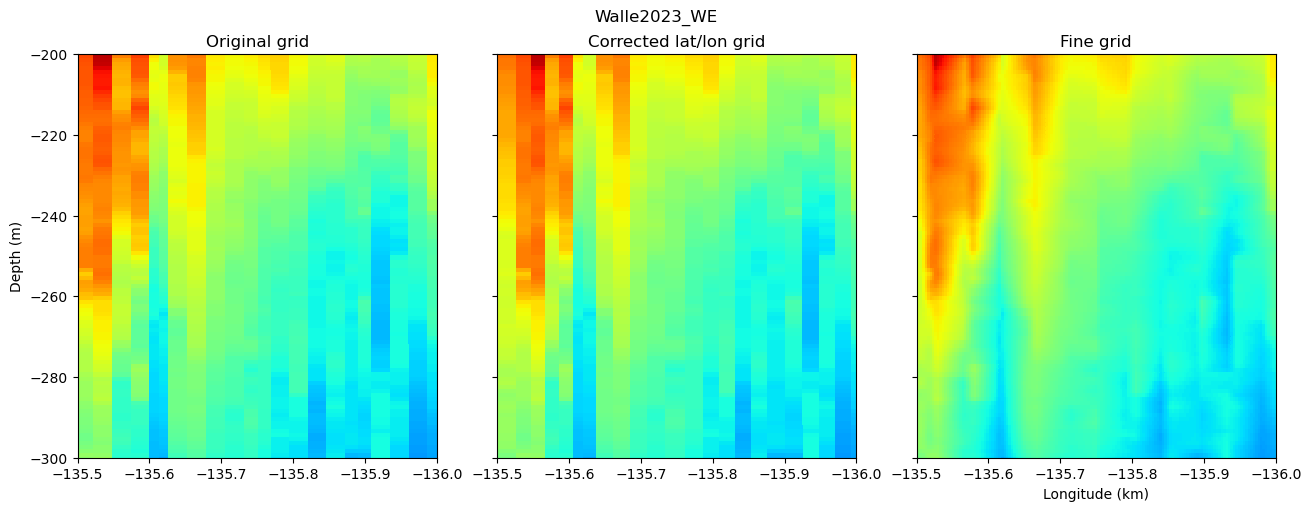

In [274]:
fig, axs = plt.subplots(1,3, layout='constrained',sharey=True,sharex=True, figsize=(13,5))

cmap='jet'; vmin=4; vmax=6

axs[0].pcolor(rosie2023_WE.longitude[:,:],-rosie2023_WE.depth,rosie2023_WE.potential_temperature, cmap=cmap, vmin=vmin, vmax=vmax)
axs[1].pcolor(rosie2023_WE.new_lons[:,:],-rosie2023_WE.depth,rosie2023_WE.potential_temperature,cmap=cmap, vmin=vmin, vmax=vmax)
axs[2].pcolor(rosie2023_WE_interp.longitude,-rosie2023_WE_interp.depth,rosie2023_WE_interp.potential_temperature,cmap=cmap, vmin=vmin, vmax=vmax)

axs[0].set_xlim(-135.5,-136)
axs[0].set_ylim(-300, -200)

axs[2].set_xlabel('Longitude (km)')
axs[0]. set_ylabel('Depth (m)')

axs[0].set_title('Original grid')
axs[1].set_title('Corrected lat/lon grid')
axs[2].set_title('Fine grid')
fig.suptitle('Walle2023_WE') 

# Walle2023

In [55]:
walle2023_WE.time

<xarray.DataArray 'time' (time: 710)> Size: 6kB
array(['2024-01-02T23:59:25.000000000', '2024-01-03T01:35:21.000000000',
       '2024-01-03T03:26:39.000000000', ..., '2024-02-20T23:18:20.000000000',
       '2024-02-21T00:53:28.000000000', '2024-02-21T02:27:47.000000000'],
      dtype='datetime64[ns]')
Coordinates:
    profile  (time) float64 6kB ...
  * time     (time) datetime64[ns] 6kB 2024-01-02T23:59:25 ... 2024-02-21T02:...
Attributes:
    source:            sci_m_present_time
    long_name:         Time
    standard_name:     time
    axis:              T
    observation_type:  measured

/var/folders/4f/2tlph0394xl3ljq0c7zz4t380000gn/T/ipykernel_16835/1093545133.py:9: UserWarning: Converting non-nanosecond precision timedelta values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  walle2023['gridded_time']= walle2023.time_1970.astype('timedelta64[s]') + np.datetime64('1970-01-01T00:00:00')


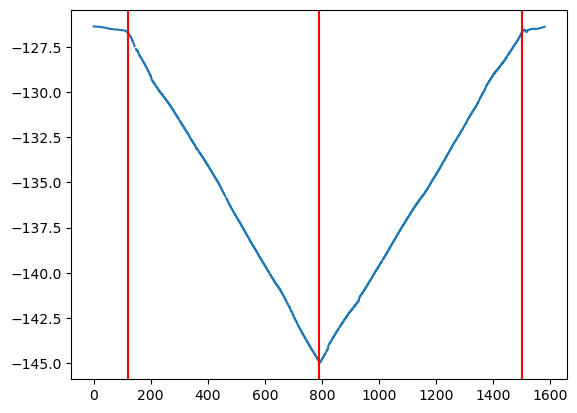

In [16]:
with xr.open_dataset(path+files[5]) as walle2023:
    x = np.linspace(0, len(walle2023.time), len(walle2023.time))
    plt.plot(x, walle2023.longitude[0,:])

    plt.axvline(x=790, c='red')
    plt.axvline(x=120, c='red')
    plt.axvline(x=1500, c='red')

    walle2023['gridded_time']= walle2023.time_1970.astype('timedelta64[s]') + np.datetime64('1970-01-01T00:00:00') 

    walle2023_EW = walle2023.isel(time=range(120,790,1))
    walle2023_WE = walle2023.isel(time=range(790,1500,1))

In [17]:
section = walle2023_EW
    
true_lons = np.empty(len(section.time))
true_lons[:] = np.nan  
####
true_lats = np.empty(len(section.time))
true_lats[:] = np.nan  

####
true_times = np.empty(len(section.time))
true_times[:] = np.nan  

for i in range(len(section.time)-1): 
    if section.profile_direction[0,i] == -1: #if ascending 
        distance_difference = np.abs(section.gridded_time[0,i+1] - section.gridded_time[0,i]) 
        time_difference = np.abs(section.gridded_time[0,i] - section.gridded_time[1,i]) 

        if time_difference >=  (np.array(37100000000)).astype('timedelta64[ns]'): #25 seconds  
            true_lats[i] = (section.latitude[0,i].values) #lat coordinate
            true_lons[i]= (section.longitude[0,i].values) #lon coordinate 
            true_times[i] = (section.gridded_time[0,i].values.astype(np.float64)/1e9 )

        elif distance_difference >=  140000000000: #consecutive profiles are 0.02 degrees longtiude apart
            true_lats[i] = (section.latitude[0,i+1].values) #lat coordinate
            true_lons[i] = (section.longitude[0,i+1].values) #lon coordinate 
            true_times[i] = (section.gridded_time[0,i+1].values.astype(np.float64)/1e9 )
        else:
            true_lats[i] = np.nan #lat coordinate
            true_lons[i] = np.nan #lon coordinate 
            true_times[i] = np.nan
    elif (np.isnan(section.time_1970[0,i] ) and ~np.isnan(section.time_1970[0,i+1] )):
        true_lats[i] = (section.latitude[0,i+1].values) #lat coordinate
        true_lons[i] = (section.longitude[0,i+1].values) #lon coordinate 
        true_times[i] = (section.gridded_time[0,i+1].values.astype(np.float64)/1e9 )
            
 
    else:
        true_lats[i] = np.nan #lat coordinate
        true_lons[i] = np.nan #lon coordinate 
        true_times[i] = np.nan


true_lats = true_lats[~np.isnan(true_times)]
true_lons = true_lons[~np.isnan(true_times)]
true_times = true_times[~np.isnan(true_times)]     





In [18]:
section['new_lons'] = (('depth','time'), np.where(np.isnan(section.potential_temperature), np.nan, np.nan))
section['new_lats'] = (('depth','time'), np.where(np.isnan(section.potential_temperature), np.nan, np.nan))


##########interpolate surface 

good_indx = ~np.isnan(section.time_1970[0,:])
sfc_time = section.time_1970[0,good_indx] 

#######
sfc_lons = np.interp(sfc_time,true_times, true_lons)
section.new_lons[0,good_indx] = sfc_lons

sfc_lats = np.interp(sfc_time, true_times ,true_lats)
section.new_lats[0,good_indx] = sfc_lats


################ interpolate other depths 
for i in range(1,len(section.depth)):
    good_indx = ~(np.isnan(section.time_1970[i,:])  )
    new_x = section.time_1970[i,good_indx]

    if len(new_x) > 0: 
        section.new_lons[i,good_indx] = np.interp(new_x,true_times, true_lons)
        section.new_lats[i,good_indx] = np.interp(new_x,true_times, true_lats)


In [ ]:
section.gridded_time[0,198]-section.gridded_time[0,197] > 140000000000

197
201
203
205


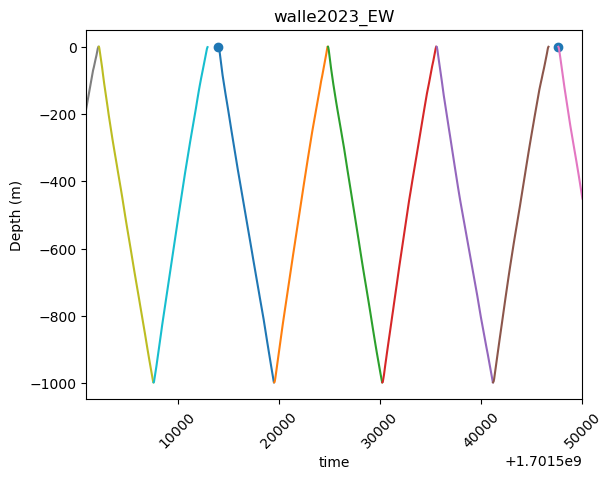

In [19]:
plt.plot(section.time_1970,-section.depth )
plt.scatter((true_times)  , np.linspace(0,0,len(true_times)))
plt.xticks(rotation=45)
plt.ylabel('Depth (m)')
plt.xlabel('time')

#plt.axvline(section.time_1970[0,60])
#plt.xlim((walle2019_dec_WE.gridded_time[0,583]),walle2019_dec_WE.gridded_time[0,595])
plt.xlim(1.701501e9, 1.70155e9)
plt.title('walle2023_EW')

for i in range(len(section.time)):
    if  (section.time_1970[0,i] > 1.701501e9) and (section.time_1970[0,i]< 1.70155e9) :
        if section.profile_direction[0,i] == -1: #if ascending 

            print (i)

Text(0.5, 1.0, 'walle2023_EW')

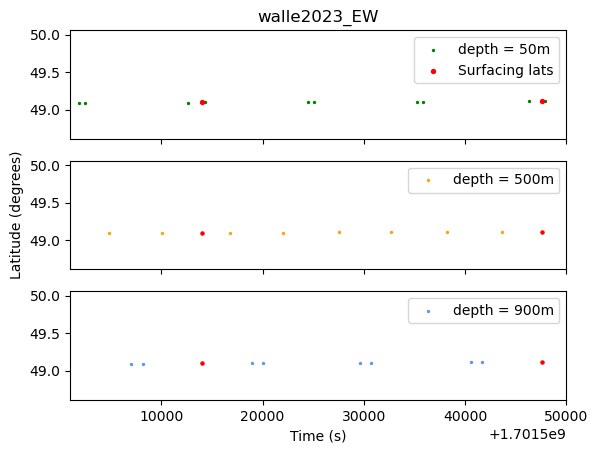

In [122]:
fig, axs = plt.subplots(3,1,sharex=True)

axs[0].scatter(section.time_1970[50,:],section.new_lats[50], c='green',marker='o' , s=2,label='depth = 50m')
axs[0].scatter(true_times,true_lats, marker='o', s=8, label = 'Surfacing lats', c='red')


axs[1].scatter(section.time_1970[500,:],section.new_lats[500], c='orange',marker='o' ,s=2, label='depth = 500m')
axs[1]. scatter(true_times,true_lats, marker='o', s=5,c='red')

axs[2].scatter(section.time_1970[900,:],section.new_lats[900], c='cornflowerblue',marker='o' ,s=2, label='depth = 900m')
axs[2]. scatter(true_times,true_lats, marker='o', s=5,c='red')


axs[0].legend(); axs[1].legend(); axs[2].legend()

axs[2].set_xlabel('Time (s)')
axs[1].set_ylabel ('Latitude (degrees)')
plt.xlim(1.701501e9, 1.70155e9)


axs[0].set_title('walle2023_EW')

In [88]:
dist_noise(section)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [89]:
walle2023_EW1 = section.drop_isel(time=[522,523,560,561 ])


In [90]:
walle2023_EW1.to_netcdf(dist_path+'walle2023_EW_corrected_dist.nc')

In [91]:
##### fine grid
ds = xr.open_dataset(dist_path+'walle2023_EW_corrected_dist.nc')
interpolate_even_dist(ds ,'walle2023_EW.nc', 'EW')

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

/opt/anaconda3/envs/eos431/lib/python3.12/site-packages/xarray/core/nputils.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)
/opt/anaconda3/envs/eos431/lib/python3.12/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Text(0.5, 0.98, 'Walle2023_EW')

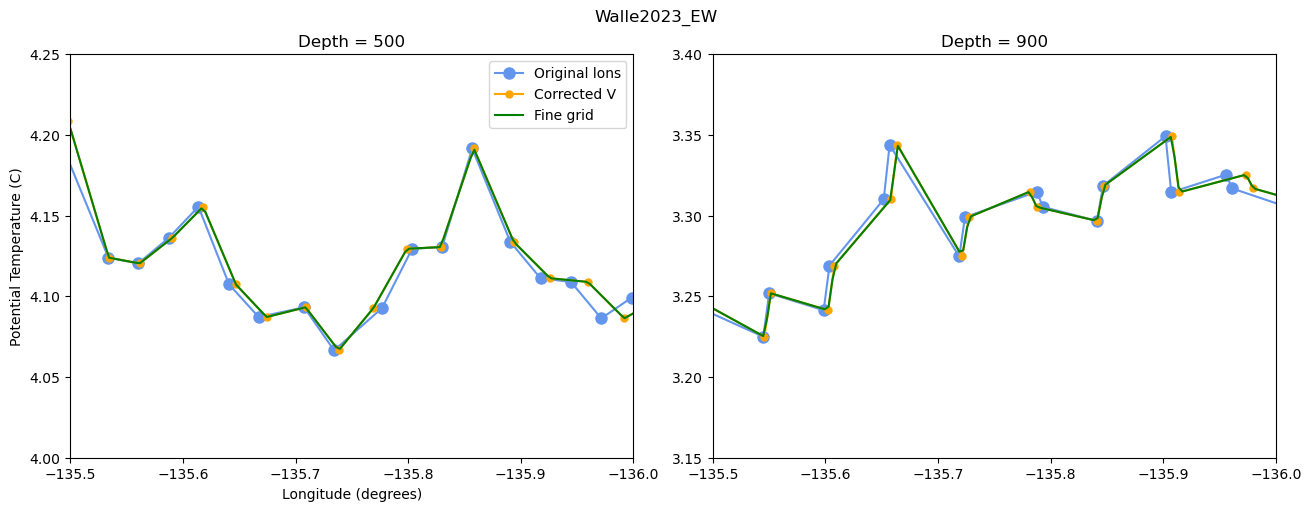

In [92]:
###compare data from original, corrected 'V' and interpolated data 
fig, axs = plt.subplots(1,2, layout='constrained',sharex=True, figsize=(13,5))


axs[0].plot(ds.longitude[500],ds.potential_temperature[500,:], marker='o', markersize=8,label='Original lons', color='cornflowerblue')  #original 
axs[0].plot(ds.new_lons[500],ds.potential_temperature[500,:], marker='o', markersize=5,label='Corrected V ', color='orange')  #original 


walle2023_EW_interp = xr.open_dataset(fine_path + 'walle2023_EW.nc')

axs[0].plot(walle2023_EW_interp.longitude[500,:],walle2023_EW_interp.potential_temperature[500,:], label ='Fine grid', color='green')  #interpolated
axs[0].set_ylim(4,4.25)

####

axs[1].plot(ds.longitude[900],ds.potential_temperature[900,:], marker='o', markersize=8,label='Original lons', color='cornflowerblue')  #original 
axs[1].plot(ds.new_lons[900],ds.potential_temperature[900,:], marker='o', markersize=5,label='Corrected V ', color='orange')  #original 
axs[1].plot(walle2023_EW_interp.longitude[900,:],walle2023_EW_interp.potential_temperature[900,:], label ='Fine grid', color='green')  #interpolated
axs[1].set_ylim(3.15,3.4)



axs[0].set_xlim(-135.5,-136)
axs[0].set_title('Depth = 500')
axs[1].set_title('Depth = 900')



axs[0].set_ylabel('Potential Temperature (C)')
axs[0].set_xlabel('Longitude (degrees)')
axs[0].legend()
fig.suptitle('Walle2023_EW')

/var/folders/4f/2tlph0394xl3ljq0c7zz4t380000gn/T/ipykernel_26171/3915072351.py:5: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.
  axs[0].pcolor(walle2023_EW.longitude[:,:],-walle2023_EW.depth,walle2023_EW.potential_temperature, cmap=cmap, vmin=vmin, vmax=vmax)
/var/folders/4f/2tlph0394xl3ljq0c7zz4t380000gn/T/ipykernel_26171/3915072351.py:6: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.
  axs[1].pcolor(walle2023_EW.new_lons[:,:],-walle2023_EW.depth,walle2023_EW.potential_temperature,cmap=cmap, vmin=vmin, vmax=vmax)
/var/folders/4f/2tlph0394xl3ljq0c7zz4t380000gn/T/ipykernel_26171/3915072351.py:7: UserWa

Text(0.5, 0.98, 'Walle2023_EW')

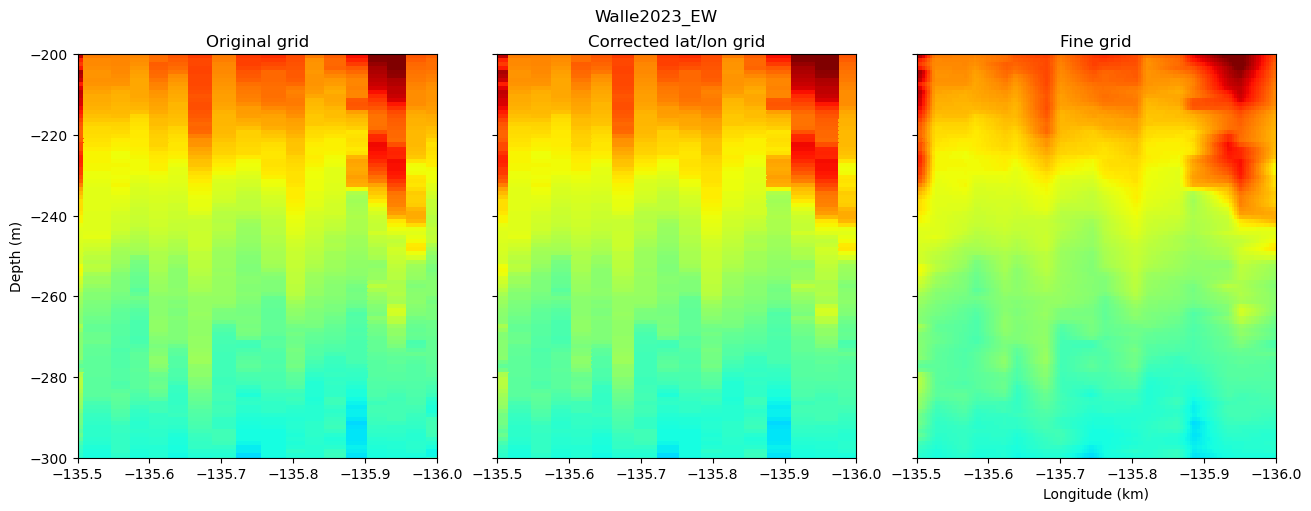

In [215]:
fig, axs = plt.subplots(1,3, layout='constrained',sharey=True,sharex=True, figsize=(13,5))

cmap='jet'; vmin=4; vmax=6

axs[0].pcolor(walle2023_EW.longitude[:,:],-walle2023_EW.depth,walle2023_EW.potential_temperature, cmap=cmap, vmin=vmin, vmax=vmax)
axs[1].pcolor(walle2023_EW.new_lons[:,:],-walle2023_EW.depth,walle2023_EW.potential_temperature,cmap=cmap, vmin=vmin, vmax=vmax)
axs[2].pcolor(walle2023_EW_interp.longitude,-walle2023_EW_interp.depth,walle2023_EW_interp.potential_temperature,cmap=cmap, vmin=vmin, vmax=vmax)

axs[0].set_xlim(-135.5,-136)
axs[0].set_ylim(-300, -200)

axs[2].set_xlabel('Longitude (km)')
axs[0]. set_ylabel('Depth (m)')

axs[0].set_title('Original grid')
axs[1].set_title('Corrected lat/lon grid')
axs[2].set_title('Fine grid')
fig.suptitle('Walle2023_EW') 

WE

In [111]:
section = walle2023_WE
    
true_lons = np.empty(len(section.time))
true_lons[:] = np.nan  
####
true_lats = np.empty(len(section.time))
true_lats[:] = np.nan  

####
true_times = np.empty(len(section.time))
true_times[:] = np.nan  

for i in range(len(section.time)-1): 
    if section.profile_direction[0,i] == -1: #if ascending 
        distance_difference = np.abs(section.gridded_time[0,i+1] - section.gridded_time[0,i]) 
        time_difference = np.abs(section.gridded_time[0,i] - section.gridded_time[1,i]) 

        if time_difference >=  (np.array(37100000000)).astype('timedelta64[ns]'): #25 seconds  
            true_lats[i] = (section.latitude[0,i].values) #lat coordinate
            true_lons[i]= (section.longitude[0,i].values) #lon coordinate 
            true_times[i] = (section.gridded_time[0,i].values.astype(np.float64)/1e9 )

        elif distance_difference >=  100000000000: #consecutive profiles are 0.02 degrees longtiude apart
            true_lats[i] = (section.latitude[0,i+1].values) #lat coordinate
            true_lons[i] = (section.longitude[0,i+1].values) #lon coordinate 
            true_times[i] = (section.gridded_time[0,i+1].values.astype(np.float64)/1e9 )
        else:
            true_lats[i] = np.nan #lat coordinate
            true_lons[i] = np.nan #lon coordinate 
            true_times[i] = np.nan
    
    elif (np.isnan(section.time_1970[0,i] ) and ~np.isnan(section.time_1970[0,i+1] )):
        true_lats[i] = (section.latitude[0,i+1].values) #lat coordinate
        true_lons[i] = (section.longitude[0,i+1].values) #lon coordinate 
        true_times[i] = (section.gridded_time[0,i+1].values.astype(np.float64)/1e9 )
            
    
    else:
        true_lats[i] = np.nan #lat coordinate
        true_lons[i] = np.nan #lon coordinate 
        true_times[i] = np.nan

true_lats = true_lats[~np.isnan(true_times)]
true_lons = true_lons[~np.isnan(true_times)]
true_times = true_times[~np.isnan(true_times)]     



section['new_lons'] = (('depth','time'), np.where(np.isnan(section.potential_temperature), np.nan, np.nan))
section['new_lats'] = (('depth','time'), np.where(np.isnan(section.potential_temperature), np.nan, np.nan))


##########interpolate surface 

good_indx = ~np.isnan(section.time_1970[0,:])
sfc_time = section.time_1970[0,good_indx] 

#######
sfc_lons = np.interp(sfc_time,true_times, true_lons)
section.new_lons[0,good_indx] = sfc_lons

sfc_lats = np.interp(sfc_time, true_times ,true_lats)
section.new_lats[0,good_indx] = sfc_lats


################ interpolate other depths 
for i in range(1,len(section.depth)):
    good_indx = ~(np.isnan(section.time_1970[i,:])  )
    new_x = section.time_1970[i,good_indx]

    if len(new_x) > 0: 
        section.new_lons[i,good_indx] = np.interp(new_x,true_times, true_lons)
        section.new_lats[i,good_indx] = np.interp(new_x,true_times, true_lats)


459
461
465
467
469
471
473
475


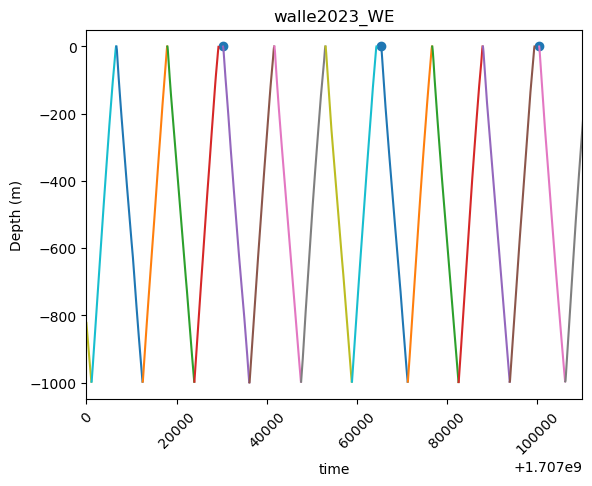

In [112]:
plt.plot(section.time_1970,-section.depth )
plt.scatter((true_times)  , np.linspace(0,0,len(true_times)))
plt.xticks(rotation=45)
plt.ylabel('Depth (m)')
plt.xlabel('time')

#plt.axvline(section.time_1970[0,60])
#plt.xlim((walle2019_dec_WE.gridded_time[0,583]),walle2019_dec_WE.gridded_time[0,595])
plt.xlim(1.707e9, 1.70711e9)
plt.title('walle2023_WE')

for i in range(len(section.time)):
    if section.profile_direction[0,i] == -1: #if ascending 
        if  (section.time_1970[0,i] > 1.707e9) and (section.time_1970[0,i]< 1.70711e9) :

            print (i)

Text(0.5, 1.0, 'walle2023_WE')

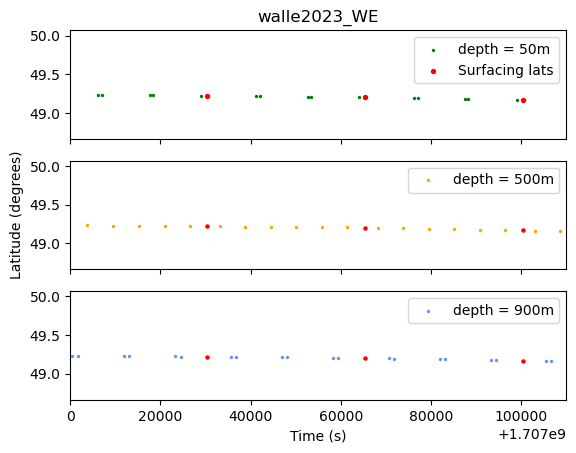

In [114]:
fig, axs = plt.subplots(3,1,sharex=True)

axs[0].scatter(section.time_1970[50,:],section.new_lats[50], c='green',marker='o' , s=2,label='depth = 50m')
axs[0].scatter(true_times,true_lats, marker='o', s=8, label = 'Surfacing lats', c='red')


axs[1].scatter(section.time_1970[500,:],section.new_lats[500], c='orange',marker='o' ,s=2, label='depth = 500m')
axs[1]. scatter(true_times,true_lats, marker='o', s=5,c='red')

axs[2].scatter(section.time_1970[900,:],section.new_lats[900], c='cornflowerblue',marker='o' ,s=2, label='depth = 900m')
axs[2]. scatter(true_times,true_lats, marker='o', s=5,c='red')


axs[0].legend(); axs[1].legend(); axs[2].legend()

axs[2].set_xlabel('Time (s)')
axs[1].set_ylabel ('Latitude (degrees)')
plt.xlim(1.707e9, 1.70711e9)

axs[0].set_title('walle2023_WE')

In [115]:
dist_noise(section)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [116]:
walle2023_WE1 = section.drop_isel(time=[139,608])


In [117]:
walle2023_WE1.to_netcdf(dist_path+'walle2023_WE_corrected_dist.nc')

In [9]:
##### fine grid
ds = xr.open_dataset(dist_path+'walle2023_WE_corrected_dist.nc')
interpolate_even_dist(ds ,'walle2023_WE.nc', 'WE')

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

Text(0.5, 0.98, 'Walle2023_WE')

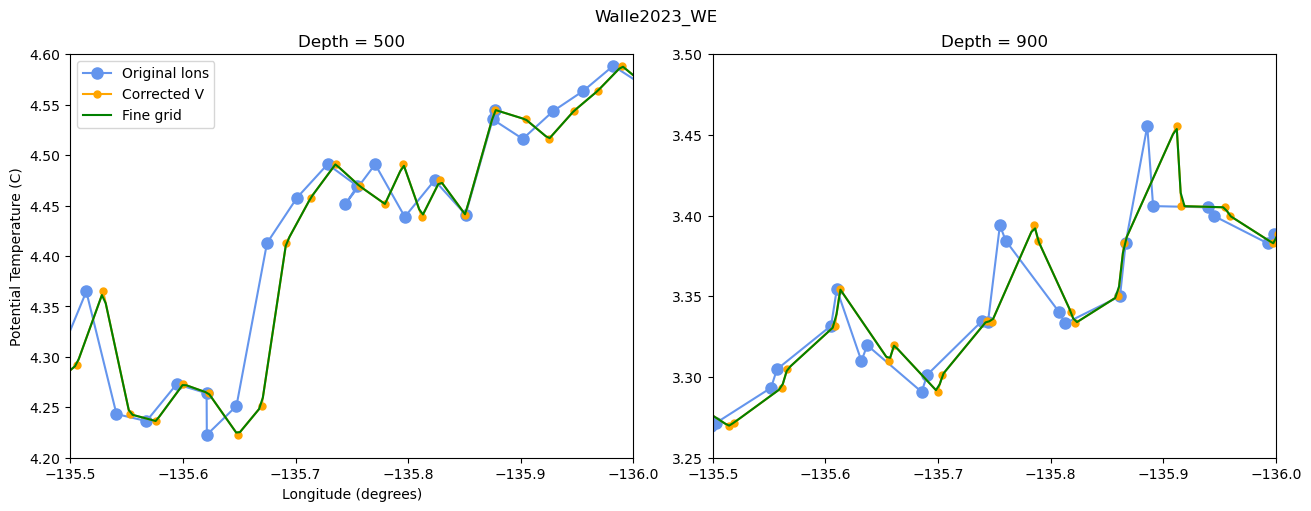

In [209]:
###compare data from original, corrected 'V' and interpolated data 
fig, axs = plt.subplots(1,2, layout='constrained',sharex=True, figsize=(13,5))


axs[0].plot(ds.longitude[500],ds.potential_temperature[500,:], marker='o', markersize=8,label='Original lons', color='cornflowerblue')  #original 
axs[0].plot(ds.new_lons[500],ds.potential_temperature[500,:], marker='o', markersize=5,label='Corrected V ', color='orange')  #original 


walle2023_WE_interp = xr.open_dataset(fine_path + 'walle2023_WE.nc')

axs[0].plot(walle2023_WE_interp.longitude[500,:],walle2023_WE_interp.potential_temperature[500,:], label ='Fine grid', color='green')  #interpolated
axs[0].set_ylim(4.2, 4.6)

####

axs[1].plot(ds.longitude[900],ds.potential_temperature[900,:], marker='o', markersize=8,label='Original lons', color='cornflowerblue')  #original 
axs[1].plot(ds.new_lons[900],ds.potential_temperature[900,:], marker='o', markersize=5,label='Corrected V ', color='orange')  #original 
axs[1].plot(walle2023_WE_interp.longitude[900,:],walle2023_WE_interp.potential_temperature[900,:], label ='Fine grid', color='green')  #interpolated
axs[1].set_ylim(3.25, 3.5)



axs[0].set_xlim(-135.5,-136)
axs[0].set_title('Depth = 500')
axs[1].set_title('Depth = 900')



axs[0].set_ylabel('Potential Temperature (C)')
axs[0].set_xlabel('Longitude (degrees)')
axs[0].legend()
fig.suptitle('Walle2023_WE')

/var/folders/4f/2tlph0394xl3ljq0c7zz4t380000gn/T/ipykernel_26171/3646259615.py:5: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.
  axs[0].pcolor(walle2023_WE.longitude[:,:],-walle2023_WE.depth,walle2023_WE.potential_temperature, cmap=cmap, vmin=vmin, vmax=vmax)
/var/folders/4f/2tlph0394xl3ljq0c7zz4t380000gn/T/ipykernel_26171/3646259615.py:6: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.
  axs[1].pcolor(walle2023_WE.new_lons[:,:],-walle2023_WE.depth,walle2023_WE.potential_temperature,cmap=cmap, vmin=vmin, vmax=vmax)
/var/folders/4f/2tlph0394xl3ljq0c7zz4t380000gn/T/ipykernel_26171/3646259615.py:7: UserWa

Text(0.5, 0.98, 'Walle2023_WE')

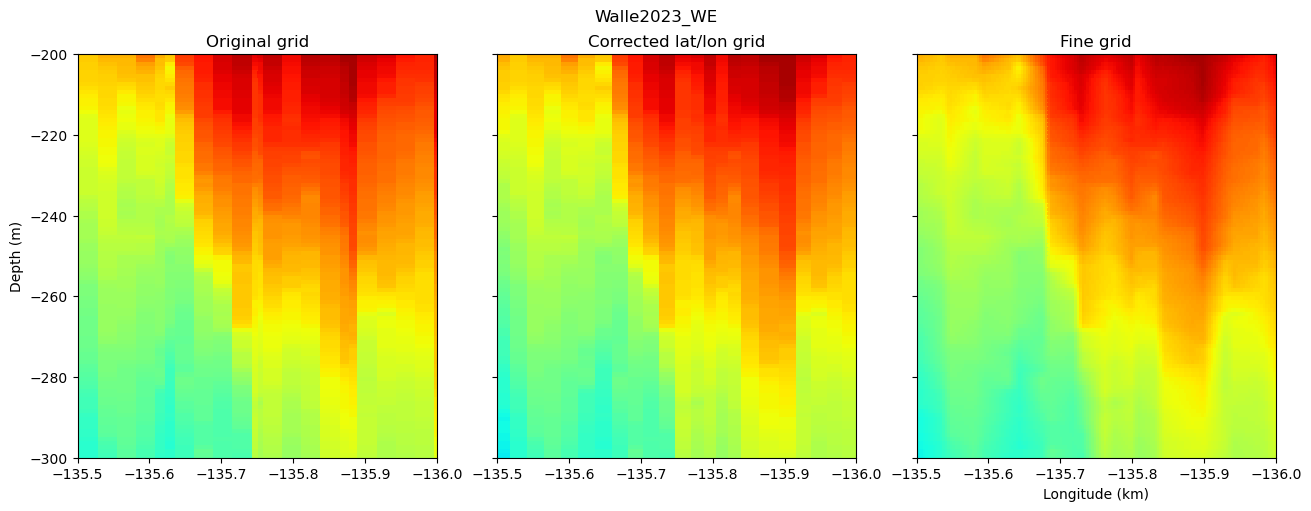

In [210]:
fig, axs = plt.subplots(1,3, layout='constrained',sharey=True,sharex=True, figsize=(13,5))

cmap='jet'; vmin=4; vmax=6.5

axs[0].pcolor(walle2023_WE.longitude[:,:],-walle2023_WE.depth,walle2023_WE.potential_temperature, cmap=cmap, vmin=vmin, vmax=vmax)
axs[1].pcolor(walle2023_WE.new_lons[:,:],-walle2023_WE.depth,walle2023_WE.potential_temperature,cmap=cmap, vmin=vmin, vmax=vmax)
axs[2].pcolor(walle2023_WE_interp.longitude,-walle2023_WE_interp.depth,walle2023_WE_interp.potential_temperature,cmap=cmap, vmin=vmin, vmax=vmax)

axs[0].set_xlim(-135.5,-136)
axs[0].set_ylim(-300, -200)

axs[2].set_xlabel('Longitude (km)')
axs[0]. set_ylabel('Depth (m)')

axs[0].set_title('Original grid')
axs[1].set_title('Corrected lat/lon grid')
axs[2].set_title('Fine grid')
fig.suptitle('Walle2023_WE') 